<a href="https://colab.research.google.com/github/nv-hiep/Anime_with_DCGAN/blob/main/supp_Anime_with_DCGAN_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating new Anime faces with DCGAN

DCGAN: Deep Convolutional Generative Adversarial Network

refs: https://www.tensorflow.org/tutorials/generative/dcgan

# Install packages

In [ ]:
!pip install animeface

     |████████████████████████████████| 2.8MB 19.9MB/s 


In [ ]:
!pip install gdown

# Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import glob
import numpy as np
import matplotlib.image as mpimg


import animeface

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import time
from keras import Input, Model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, BatchNormalization, Reshape
from keras.layers import concatenate, LeakyReLU, Lambda, Activation, UpSampling2D, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.gridspec as gridspec

from collections import deque
from keras.models import load_model

import argparse
from PIL import Image

#1. Anime-Face-Dataset

## 1.1 Download data

In [ ]:
#  https://drive.google.com/file/d/1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI/view?usp=sharing
# gdown --id <put-the-ID>
!gdown --id 1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI

Downloading...
From: https://drive.google.com/uc?id=1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI
To: /content/data.tgz
379MB [00:10, 36.2MB/s]


## 1.2 Unzip

In [ ]:
!tar -xf data.tgz
# unzip to directory: 'cropped' all the .jpg files

In [ ]:
filenames = glob.glob('cropped/*.jpg')
filenames[:10]

['cropped/21610_2008.jpg',
 'cropped/42797_2013.jpg',
 'cropped/34791_2011.jpg',
 'cropped/10256_2004.jpg',
 'cropped/36589_2012.jpg',
 'cropped/20849_2008.jpg',
 'cropped/62364_2019.jpg',
 'cropped/36404_2012.jpg',
 'cropped/6628_2003.jpg',
 'cropped/52426_2015.jpg']

## 1.3 Plot some images

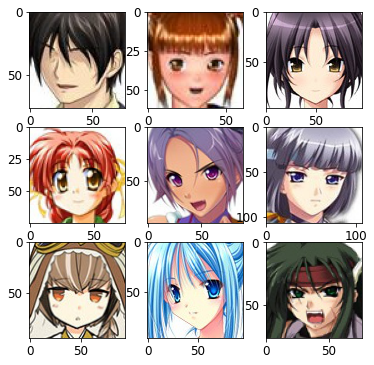

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(6,6))
axs = axs.flatten()

for i in range(9):
  ax = axs[i]
  ax.imshow( mpimg.imread(filenames[i]) )

plt.show()

Shapes of the images

In [ ]:
some_img = mpimg.imread(filenames[3]) # images with different sizes
print(f'Image shape: {some_img.shape}')
print(f'NUmber of samples: {len(filenames)}')

Image shape: (75, 75, 3)
NUmber of samples: 63632


In [ ]:
for i in range(4):
  some_img = Image.open(filenames[i])
    
  # summarize some details about the image
  print(some_img.format)
  print(some_img.size)
  print(some_img.mode)
  print()

JPEG
(77, 77)
RGB

JPEG
(62, 62)
RGB

JPEG
(96, 96)
RGB

JPEG
(75, 75)
RGB



In [ ]:
for i in range(5):
  # load the image and convert into numpy array
  some_img = np.asarray( Image.open(filenames[i]) )
    
  # <class 'numpy.ndarray'>
  print(type(some_img))
    
  #  shape
  print(some_img.shape)

  print()

<class 'numpy.ndarray'>
(77, 77, 3)

<class 'numpy.ndarray'>
(62, 62, 3)

<class 'numpy.ndarray'>
(96, 96, 3)

<class 'numpy.ndarray'>
(75, 75, 3)

<class 'numpy.ndarray'>
(90, 90, 3)



In [ ]:
# !mkdir data

if not os.path.exists('data/'):
  os.makedirs('data/')

In [ ]:
# A lot of images, I preprocessed and I knew the indices of good images
# If you want to do this yourself, ignore this cell
good_img_id = []

good_img_id_str = '0 1 2 5 6 8 10 11 12 13 16 18 20 23 27 28 29 32 34 35 36 41 43 44 46 47 50 51 52 53 54 55 56 57 58 59 61 62 64 68 71 73 76 77 78 79 80 81 82 83 84 85 86 88 90 91 92 94 95 96 99 101 102 103 104 105 106 108 109 112 114 115 116 118 119 122 124 125 126 127 128 129 130 131 133 134 137 138 139 140 142 145 148 150 151 154 156 157 158 159 163 168 169 171 173 174 177 178 179 180 181 182 183 184 185 189 192 195 197 198 202 203 205 206 208 209 211 213 217 218 222 223 226 229 230 233 236 237 238 239 240 241 242 243 244 245 247 248 249 250 257 258 259 260 261 263 264 266 269 270 272 273 274 276 279 280 282 283 285 286 288 289 292 294 295 296 297 298 299 302 304 305 306 309 310 311 313 314 315 318 319 321 325 326 327 328 330 332 334 335 336 339 340 343 344 347 348 349 350 352 354 357 358 359 360 361 362 364 365 366 368 370 371 372 373 375 376 385 386 387 390 393 394 395 396 397 398 399 402 403 404 405 406 407 408 410 412 414 415 416 417 419 420 423 425 426 427 428 430 432 433 434 435 436 438 440 443 445 449 452 454 456 458 459 461 463 464 468 470 471 472 474 478 480 481 482 483 484 485 486 487 488 489 491 492 493 494 497 498 500 502 503 506 507 508 509 510 511 512 513 514 515 516 517 518 521 523 524 526 529 530 534 535 536 537 538 540 541 544 546 547 550 554 555 556 557 559 563 564 566 567 570 571 572 573 575 578 579 580 582 583 584 585 586 587 590 594 595 598 599 600 602 603 604 605 607 608 610 611 612 619 620 624 626 630 631 632 633 634 635 636 637 638 639 640 642 644 650 651 652 653 654 655 659 660 661 662 663 665 669 671 672 673 674 675 676 679 680 681 682 683 685 686 688 690 691 692 693 694 695 696 697 699 700 701 703 706 707 711 713 715 716 720 721 722 723 727 729 731 732 733 736 739 740 741 743 744 745 746 747 750 752 754 755 756 758 759 760 762 763 764 765 767 771 772 773 776 777 780 782 783 784 785 786 787 791 793 796 799 801 804 805 806 810 811 813 815 816 817 818 821 822 824 826 827 830 831 832 836 837 838 839 840 841 842 843 845 848 849 850 851 852 853 854 855 856 857 858 861 862 863 865 867 869 870 871 872 874 875 877 881 882 883 884 885 887 889 893 895 896 898 899 900 902 903 904 905 906 907 909 910 914 916 918 920 921 922 923 924 928 930 931 935 936 937 938 939 942 945 948 949 951 952 954 955 956 957 959 960 961 962 964 965 966 967 968 970 971 972 973 974 976 977 978 981 983 984 985 987 990 992 994 996 999 1001 1004 1007 1009 1010 1011 1012 1014 1015 1016 1017 1018 1019 1020 1022 1023 1024 1025 1026 1028 1030 1031 1032 1033 1034 1035 1040 1041 1043 1044 1045 1048 1049 1051 1053 1054 1055 1057 1059 1063 1064 1065 1066 1067 1068 1070 1072 1073 1074 1076 1077 1083 1085 1087 1090 1091 1093 1094 1095 1097 1098 1099 1101 1103 1105 1106 1107 1109 1111 1113 1114 1116 1117 1118 1119 1120 1121 1123 1124 1126 1128 1129 1130 1131 1132 1133 1134 1138 1139 1140 1142 1143 1145 1148 1149 1150 1153 1155 1157 1158 1160 1162 1164 1166 1167 1168 1170 1171 1173 1176 1177 1178 1181 1182 1183 1184 1185 1188 1189 1194 1195 1198 1200 1201 1204 1206 1207 1208 1210 1211 1216 1217 1220 1222 1223 1224 1229 1230 1231 1237 1239 1240 1241 1243 1244 1247 1248 1249 1250 1251 1252 1254 1255 1256 1260 1262 1263 1264 1267 1269 1270 1271 1272 1273 1277 1278 1279 1281 1284 1288 1289 1290 1291 1293 1294 1297 1299 1300 1301 1302 1305 1306 1307 1309 1313 1315 1317 1318 1320 1322 1323 1324 1325 1326 1327 1328 1329 1331 1333 1334 1336 1337 1338 1341 1342 1345 1348 1349 1350 1352 1354 1357 1359 1361 1364 1370 1371 1372 1375 1377 1378 1379 1383 1384 1385 1386 1387 1388 1390 1391 1392 1393 1394 1396 1397 1400 1401 1403 1404 1405 1406 1407 1409 1410 1411 1412 1413 1414 1415 1417 1418 1420 1422 1424 1426 1427 1428 1430 1431 1433 1434 1436 1437 1438 1439 1440 1445 1446 1447 1448 1449 1450 1451 1455 1456 1457 1458 1460 1464 1466 1467 1468 1470 1471 1473 1474 1475 1476 1477 1480 1481 1483 1486 1489 1491 1492 1494 1495 1496 1497 1499 1502 1504 1505 1507 1509 1512 1515 1516 1517 1519 1520 1522 1523 1524 1526 1527 1528 1532 1533 1534 1535 1537 1540 1541 1542 1546 1547 1549 1552 1553 1554 1555 1557 1558 1559 1560 1561 1562 1563 1565 1567 1568 1569 1570 1571 1572 1573 1574 1576 1577 1578 1579 1581 1585 1586 1587 1588 1590 1591 1592 1593 1596 1597 1599 1600 1603 1604 1606 1607 1608 1609 1612 1614 1615 1616 1618 1622 1623 1624 1625 1627 1628 1630 1631 1632 1633 1636 1637 1638 1639 1640 1641 1642 1648 1650 1652 1653 1654 1655 1656 1658 1662 1666 1667 1668 1669 1671 1672 1674 1675 1679 1682 1683 1684 1685 1687 1688 1690 1692 1693 1694 1697 1700 1702 1703 1706 1707 1710 1712 1713 1714 1715 1716 1717 1720 1721 1724 1725 1726 1729 1730 1731 1733 1735 1739 1740 1741 1743 1744 1745 1746 1747 1748 1751 1755 1757 1758 1759 1760 1764 1767 1768 1769 1771 1772 1775 1778 1779 1780 1781 1782 1784 1785 1786 1788 1789 1793 1794 1797 1800 1802 1803 1806 1807 1808 1809 1810 1811 1815 1817 1818 1819 1820 1821 1822 1823 1825 1826 1827 1828 1829 1831 1835 1836 1838 1839 1840 1841 1843 1844 1845 1846 1847 1850 1853 1855 1857 1859 1860 1862 1863 1864 1865 1866 1871 1872 1876 1877 1878 1880 1882 1883 1886 1887 1890 1892 1893 1894 1895 1896 1897 1899 1902 1905 1906 1907 1908 1910 1911 1912 1913 1915 1916 1917 1918 1919 1920 1924 1927 1928 1929 1930 1931 1933 1934 1936 1937 1938 1939 1945 1946 1947 1948 1951 1955 1961 1962 1963 1966 1967 1968 1971 1973 1975 1977 1978 1979 1983 1984 1985 1986 1987 1988 1989 1995 1996 1997 1998 1999 2000 2001 2004 2005 2006 2008 2010 2012 2014 2015 2016 2017 2019 2020 2021 2022 2023 2026 2027 2029 2032 2033 2035 2038 2039 2040 2042 2043 2044 2045 2046 2048 2051 2055 2057 2058 2059 2061 2064 2067 2069 2071 2073 2074 2076 2078 2079 2083 2086 2089 2090 2091 2092 2093 2096 2097 2099 2100 2101 2105 2106 2108 2111 2113 2114 2117 2119 2120 2121 2122 2123 2124 2125 2126 2128 2129 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2145 2146 2148 2149 2151 2152 2153 2154 2155 2157 2158 2159 2162 2163 2165 2166 2173 2174 2178 2179 2181 2182 2184 2185 2187 2189 2190 2191 2192 2194 2196 2197 2199 2202 2203 2206 2207 2213 2215 2218 2219 2221 2223 2225 2226 2227 2228 2230 2231 2233 2234 2235 2238 2239 2242 2243 2244 2245 2246 2248 2251 2252 2255 2256 2257 2258 2260 2261 2262 2263 2264 2265 2266 2268 2269 2270 2272 2273 2276 2278 2280 2281 2282 2283 2285 2286 2287 2290 2291 2292 2293 2294 2295 2298 2299 2300 2304 2305 2306 2309 2311 2312 2313 2316 2318 2319 2322 2323 2325 2326 2327 2328 2329 2330 2334 2337 2339 2341 2344 2345 2346 2348 2349 2350 2351 2354 2356 2358 2362 2363 2364 2365 2366 2367 2371 2372 2373 2374 2376 2377 2378 2379 2380 2381 2382 2386 2387 2388 2390 2392 2393 2395 2397 2398 2399 2402 2403 2404 2405 2410 2411 2415 2416 2417 2418 2422 2423 2425 2427 2428 2429 2430 2434 2435 2437 2439 2440 2441 2443 2446 2448 2449 2452 2455 2457 2458 2459 2460 2461 2462 2463 2464 2465 2469 2470 2471 2477 2479 2480 2483 2484 2486 2491 2492 2493 2494 2495 2496 2498 2500 2509 2511 2513 2514 2515 2516 2519 2521 2523 2525 2526 2527 2530 2531 2532 2534 2535 2536 2538 2540 2541 2542 2544 2545 2546 2547 2548 2549 2551 2552 2554 2556 2559 2560 2562 2564 2565 2566 2568 2571 2572 2573 2574 2575 2576 2578 2580 2582 2583 2584 2587 2588 2589 2590 2591 2594 2595 2596 2597 2598 2600 2602 2603 2604 2606 2612 2614 2615 2618 2621 2625 2626 2627 2628 2630 2632 2635 2636 2637 2638 2639 2640 2642 2644 2645 2647 2650 2655 2656 2657 2658 2659 2661 2663 2664 2668 2669 2670 2671 2674 2676 2678 2679 2681 2682 2683 2684 2687 2688 2689 2693 2694 2695 2696 2697 2698 2699 2701 2703 2704 2706 2709 2711 2712 2713 2714 2715 2719 2720 2722 2723 2724 2726 2727 2729 2730 2733 2734 2736 2737 2738 2739 2740 2741 2744 2745 2746 2748 2749 2750 2751 2752 2754 2756 2757 2758 2760 2761 2762 2763 2767 2769 2771 2773 2775 2778 2779 2780 2782 2783 2785 2786 2787 2788 2789 2790 2791 2792 2793 2794 2797 2798 2799 2800 2801 2802 2804 2805 2807 2809 2810 2813 2816 2820 2821 2822 2823 2824 2825 2826 2827 2828 2830 2832 2836 2839 2842 2847 2848 2849 2851 2852 2855 2857 2858 2859 2860 2863 2864 2865 2868 2871 2874 2875 2876 2877 2879 2881 2882 2883 2884 2886 2889 2890 2891 2892 2893 2894 2898 2899 2900 2902 2903 2904 2905 2906 2908 2909 2911 2917 2918 2919 2922 2924 2925 2926 2928 2930 2933 2934 2935 2937 2938 2940 2941 2942 2945 2946 2948 2949 2950 2952 2953 2954 2958 2959 2961 2962 2963 2967 2970 2972 2974 2976 2977 2978 2979 2980 2981 2983 2986 2987 2989 2991 2992 2995 2997 2998 2999 3005 3007 3008 3012 3013 3016 3017 3018 3020 3021 3022 3023 3024 3025 3026 3030 3033 3034 3036 3037 3038 3039 3040 3042 3043 3044 3046 3047 3048 3053 3054 3055 3056 3057 3058 3060 3061 3062 3063 3066 3067 3068 3069 3072 3073 3074 3075 3077 3078 3081 3082 3083 3084 3085 3086 3088 3090 3093 3099 3100 3101 3102 3105 3106 3109 3110 3111 3112 3113 3114 3116 3117 3121 3124 3126 3128 3130 3131 3136 3139 3140 3141 3143 3144 3145 3146 3147 3148 3149 3151 3152 3153 3154 3155 3156 3157 3158 3161 3163 3164 3167 3168 3169 3172 3174 3175 3178 3181 3182 3183 3184 3185 3186 3188 3189 3190 3191 3192 3193 3195 3196 3198 3199 3200 3201 3202 3203 3206 3207 3208 3209 3210 3214 3216 3217 3219 3221 3224 3225 3226 3228 3229 3235 3238 3240 3242 3243 3246 3249 3252 3254 3256 3257 3261 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3280 3281 3282 3283 3285 3288 3290 3291 3292 3293 3294 3296 3297 3298 3299 3301 3303 3305 3306 3308 3309 3310 3311 3313 3314 3316 3317 3318 3319 3320 3323 3324 3325 3326 3328 3329 3333 3337 3338 3340 3341 3343 3344 3345 3350 3352 3354 3355 3358 3360 3362 3364 3365 3366 3368 3370 3371 3372 3373 3374 3378 3381 3382 3383 3384 3388 3389 3391 3393 3394 3401 3404 3407 3408 3409 3410 3411 3412 3413 3414 3415 3417 3418 3419 3421 3422 3425 3430 3432 3433 3435 3438 3439 3440 3441 3442 3445 3447 3451 3452 3456 3457 3460 3461 3462 3464 3465 3466 3467 3468 3469 3470 3471 3475 3476 3477 3478 3479 3480 3481 3484 3485 3486 3489 3490 3491 3492 3496 3498 3499 3501 3503 3505 3506 3507 3508 3509 3510 3512 3514 3515 3517 3518 3519 3525 3526 3527 3528 3529 3530 3531 3533 3534 3535 3539 3541 3542 3544 3545 3546 3549 3551 3554 3557 3558 3559 3561 3562 3563 3565 3566 3567 3570 3573 3576 3577 3579 3581 3582 3584 3585 3587 3590 3593 3596 3599 3602 3603 3604 3605 3606 3608 3609 3611 3615 3617 3620 3621 3622 3630 3631 3632 3634 3635 3636 3639 3640 3641 3646 3648 3650 3652 3655 3656 3657 3658 3660 3661 3663 3665 3666 3667 3671 3672 3673 3674 3676 3678 3679 3680 3683 3686 3688 3696 3699 3700 3703 3705 3706 3707 3708 3709 3710 3712 3713 3714 3715 3718 3720 3724 3728 3729 3730 3731 3732 3735 3738 3739 3740 3741 3743 3744 3748 3751 3756 3762 3763 3765 3767 3768 3769 3770 3771 3772 3774 3775 3776 3777 3778 3779 3784 3786 3787 3789 3790 3791 3792 3794 3797 3798 3799 3801 3802 3803 3805 3807 3810 3811 3812 3813 3814 3816 3820 3822 3823 3824 3826 3827 3830 3832 3834 3836 3839 3844 3845 3847 3849 3850 3851 3853 3856 3858 3859 3860 3861 3862 3864 3867 3868 3870 3871 3873 3875 3876 3878 3879 3880 3882 3883 3884 3887 3888 3891 3893 3895 3896 3897 3899 3901 3902 3905 3906 3910 3911 3912 3916 3918 3919 3920 3922 3924 3925 3927 3928 3930 3931 3933 3936 3938 3940 3941 3944 3945 3946 3949 3950 3951 3952 3953 3958 3959 3960 3961 3962 3965 3966 3968 3969 3970 3971 3973 3974 3975 3977 3979 3980 3981 3982 3984 3988 3989 3991 3992 3994 3995 3997 3998 4000 4001 4003 4005 4007 4008 4009 4011 4012 4015 4016 4019 4020 4021 4022 4024 4026 4027 4030 4034 4035 4038 4040 4041 4042 4045 4046 4047 4048 4049 4051 4052 4053 4055 4056 4057 4058 4060 4061 4063 4064 4065 4068 4071 4073 4074 4075 4076 4078 4081 4083 4084 4085 4088 4089 4090 4092 4093 4094 4095 4096 4098 4101 4102 4104 4106 4107 4108 4109 4110 4112 4120 4122 4123 4126 4127 4128 4129 4130 4132 4133 4134 4135 4137 4138 4141 4142 4143 4154 4159 4160 4161 4162 4163 4164 4165 4166 4172 4173 4175 4177 4181 4184 4188 4189 4190 4192 4193 4194 4195 4198 4199 4200 4201 4203 4205 4206 4207 4209 4211 4213 4218 4219 4220 4221 4224 4225 4227 4232 4234 4235 4239 4242 4246 4248 4249 4250 4252 4253 4255 4261 4263 4264 4266 4269 4271 4272 4274 4275 4278 4279 4280 4281 4283 4285 4286 4287 4289 4291 4294 4295 4297 4298 4302 4303 4304 4305 4306 4308 4310 4312 4316 4318 4323 4324 4325 4326 4331 4332 4335 4337 4338 4339 4340 4342 4343 4345 4348 4351 4352 4353 4354 4357 4358 4360 4365 4366 4367 4368 4374 4376 4377 4380 4381 4382 4384 4385 4386 4387 4388 4390 4395 4396 4397 4398 4405 4408 4409 4411 4412 4413 4414 4415 4418 4419 4420 4422 4423 4427 4428 4430 4436 4437 4439 4440 4443 4445 4446 4449 4452 4455 4457 4458 4460 4461 4462 4465 4466 4467 4468 4470 4471 4472 4473 4474 4475 4476 4477 4479 4480 4483 4485 4487 4488 4489 4490 4496 4497 4499 4500 4501 4502 4503 4504 4506 4507 4508 4510 4513 4515 4519 4521 4522 4525 4526 4527 4528 4529 4531 4532 4533 4534 4536 4538 4539 4548 4550 4551 4553 4555 4558 4559 4560 4561 4562 4563 4564 4565 4566 4567 4569 4571 4572 4575 4577 4579 4580 4581 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593 4594 4596 4597 4598 4599 4600 4601 4602 4603 4604 4605 4609 4610 4614 4616 4617 4618 4619 4620 4621 4622 4623 4624 4627 4628 4629 4631 4640 4642 4643 4644 4645 4646 4647 4648 4649 4651 4652 4654 4655 4656 4657 4659 4661 4663 4664 4665 4668 4670 4671 4673 4676 4677 4678 4681 4683 4684 4686 4688 4689 4690 4691 4692 4693 4696 4698 4701 4705 4709 4710 4711 4713 4715 4716 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728 4729 4730 4731 4733 4734 4735 4736 4737 4741 4742 4743 4744 4745 4746 4749 4750 4753 4754 4755 4756 4757 4759 4760 4761 4762 4764 4765 4767 4772 4773 4774 4775 4776 4778 4779 4780 4783 4784 4785 4788 4789 4790 4791 4793 4794 4795 4796 4798 4800 4802 4806 4808 4809 4811 4812 4814 4815 4816 4817 4819 4821 4822 4823 4824 4825 4827 4828 4830 4831 4832 4835 4836 4838 4839 4840 4843 4846 4848 4849 4850 4851 4853 4854 4855 4856 4857 4858 4860 4863 4865 4866 4867 4868 4869 4870 4873 4875 4877 4879 4880 4881 4882 4886 4888 4889 4890 4891 4892 4894 4897 4898 4899 4900 4901 4906 4909 4911 4912 4914 4915 4917 4921 4922 4923 4924 4925 4926 4927 4931 4935 4936 4937 4938 4939 4940 4945 4946 4948 4949 4950 4952 4954 4955 4956 4958 4959 4960 4961 4962 4964 4966 4967 4968 4971 4972 4973 4974 4976 4978 4979 4980 4982 4985 4986 4987 4988 4989 4990 4993 4994 4995 4997 4999 5000 5002 5005 5006 5009 5011 5012 5013 5015 5016 5018 5020 5021 5022 5023 5024 5027 5028 5029 5032 5034 5035 5037 5038 5040 5041 5045 5046 5047 5048 5049 5050 5052 5055 5059 5064 5067 5068 5073 5075 5076 5077 5078 5079 5081 5082 5083 5084 5085 5086 5087 5092 5095 5096 5097 5100 5101 5103 5104 5106 5108 5110 5112 5113 5118 5121 5123 5124 5125 5126 5127 5128 5131 5132 5133 5134 5136 5137 5138 5139 5141 5142 5144 5150 5151 5152 5153 5157 5158 5159 5164 5166 5167 5168 5171 5172 5173 5174 5175 5176 5177 5178 5180 5183 5185 5187 5188 5190 5193 5194 5195 5196 5197 5200 5202 5204 5205 5206 5207 5210 5212 5214 5216 5217 5219 5221 5225 5226 5230 5232 5234 5235 5236 5237 5240 5241 5242 5244 5245 5246 5248 5253 5254 5255 5257 5259 5262 5264 5266 5267 5268 5269 5270 5271 5272 5274 5275 5276 5284 5286 5287 5289 5294 5295 5297 5298 5301 5303 5305 5306 5307 5309 5312 5313 5315 5316 5317 5318 5319 5320 5321 5322 5325 5326 5331 5334 5335 5336 5337 5338 5340 5341 5342 5343 5346 5347 5349 5350 5351 5352 5354 5355 5358 5363 5364 5365 5366 5367 5368 5369 5370 5372 5374 5376 5377 5379 5380 5381 5382 5383 5384 5385 5388 5389 5390 5391 5392 5394 5395 5396 5397 5400 5401 5402 5403 5406 5407 5410 5411 5412 5413 5414 5420 5422 5423 5425 5426 5427 5429 5432 5433 5434 5435 5436 5437 5438 5439 5441 5442 5443 5450 5453 5454 5456 5457 5459 5460 5462 5464 5465 5466 5467 5469 5471 5472 5474 5476 5477 5478 5481 5482 5483 5484 5485 5486 5487 5488 5489 5491 5492 5493 5494 5496 5497 5500 5501 5502 5503 5505 5506 5509 5510 5512 5513 5514 5516 5518 5523 5525 5527 5531 5532 5534 5537 5539 5540 5541 5542 5543 5544 5545 5547 5548 5549 5550 5551 5552 5554 5556 5558 5560 5561 5565 5566 5567 5570 5571 5572 5574 5575 5577 5579 5581 5582 5583 5586 5587 5588 5590 5592 5593 5595 5597 5601 5603 5604 5605 5606 5607 5608 5611 5612 5613 5615 5617 5618 5619 5621 5623 5624 5625 5626 5627 5628 5631 5632 5637 5638 5641 5642 5643 5646 5649 5653 5655 5656 5657 5658 5659 5661 5662 5663 5664 5665 5668 5670 5671 5672 5673 5674 5675 5676 5677 5679 5682 5683 5684 5686 5688 5689 5690 5691 5695 5696 5697 5698 5699 5700 5701 5703 5704 5707 5711 5713 5715 5716 5717 5719 5720 5722 5725 5728 5729 5730 5731 5732 5734 5736 5738 5739 5740 5741 5742 5743 5745 5750 5753 5754 5755 5756 5757 5758 5761 5762 5763 5765 5766 5768 5769 5772 5773 5774 5775 5776 5779 5780 5782 5783 5787 5788 5789 5795 5797 5800 5801 5805 5808 5809 5810 5812 5813 5816 5818 5819 5822 5826 5828 5829 5832 5833 5834 5835 5837 5838 5840 5841 5842 5843 5844 5846 5847 5848 5849 5851 5852 5858 5859 5860 5861 5862 5864 5867 5868 5870 5871 5872 5873 5874 5875 5876 5877 5878 5881 5882 5885 5886 5887 5889 5890 5892 5893 5894 5895 5897 5898 5899 5900 5901 5905 5907 5908 5916 5917 5918 5919 5921 5922 5923 5925 5926 5927 5929 5930 5931 5934 5939 5940 5944 5945 5947 5948 5949 5951 5952 5953 5956 5957 5961 5962 5963 5964 5965 5966 5968 5969 5970 5971 5973 5974 5975 5977 5980 5982 5983 5984 5988 5990 5993 5996 5997 5999 6000 6001 6002 6003 6004 6005 6006 6008 6013 6014 6016 6017 6018 6019 6020 6022 6023 6024 6025 6026 6027 6028 6029 6031 6034 6035 6036 6038 6043 6047 6048 6049 6051 6053 6054 6056 6059 6060 6061 6063 6064 6065 6066 6067 6069 6070 6072 6074 6075 6081 6082 6083 6084 6086 6087 6089 6090 6091 6092 6093 6094 6096 6097 6098 6100 6101 6106 6107 6110 6112 6113 6117 6119 6121 6123 6124 6125 6126 6127 6128 6129 6131 6132 6133 6135 6136 6137 6141 6142 6146 6147 6148 6149 6152 6153 6154 6155 6156 6157 6158 6160 6161 6162 6163 6164 6167 6169 6170 6172 6174 6175 6176 6179 6180 6181 6183 6184 6186 6188 6191 6193 6194 6197 6198 6199 6200 6203 6207 6209 6210 6213 6216 6219 6220 6221 6222 6223 6224 6234 6238 6239 6240 6242 6243 6245 6246 6249 6252 6253 6254 6255 6257 6258 6259 6261 6263 6264 6270 6272 6273 6274 6275 6276 6279 6280 6281 6283 6285 6288 6289 6293 6294 6295 6296 6297 6300 6301 6302 6303 6304 6305 6306 6307 6311 6313 6316 6317 6318 6319 6321 6322 6323 6325 6328 6329 6333 6334 6336 6337 6338 6342 6343 6344 6345 6349 6351 6354 6356 6357 6358 6359 6363 6364 6366 6367 6368 6369 6374 6375 6378 6380 6385 6386 6387 6388 6389 6390 6391 6392 6394 6395 6396 6397 6398 6399 6400 6402 6403 6405 6409 6410 6412 6413 6414 6415 6416 6417 6418 6422 6424 6425 6426 6427 6429 6431 6433 6436 6437 6438 6439 6440 6442 6443 6444 6446 6447 6448 6450 6453 6454 6458 6459 6462 6463 6465 6467 6468 6469 6471 6472 6473 6474 6475 6476 6477 6480 6481 6482 6483 6485 6486 6490 6491 6493 6494 6495 6496 6497 6498 6501 6502 6504 6506 6507 6510 6511 6513 6514 6515 6518 6520 6521 6522 6524 6525 6527 6529 6530 6531 6532 6533 6535 6536 6537 6538 6539 6541 6542 6544 6545 6547 6549 6551 6552 6553 6554 6555 6556 6559 6560 6561 6562 6563 6566 6567 6568 6570 6571 6572 6574 6575 6578 6580 6581 6584 6585 6586 6593 6597 6598 6601 6602 6603 6604 6606 6607 6612 6613 6614 6615 6618 6619 6620 6621 6622 6626 6629 6630 6634 6635 6636 6639 6640 6645 6647 6648 6652 6653 6654 6656 6657 6659 6660 6661 6665 6668 6670 6671 6672 6673 6674 6675 6678 6681 6686 6689 6692 6697 6698 6699 6700 6702 6703 6704 6709 6711 6712 6713 6717 6718 6719 6720 6721 6722 6723 6725 6726 6729 6730 6734 6736 6737 6738 6739 6740 6741 6742 6744 6746 6747 6748 6749 6751 6752 6754 6755 6756 6757 6759 6761 6762 6767 6768 6769 6771 6773 6774 6775 6778 6779 6781 6784 6786 6787 6788 6790 6793 6795 6797 6799 6800 6801 6802 6804 6806 6807 6808 6809 6810 6811 6812 6813 6814 6816 6820 6822 6828 6830 6831 6834 6836 6838 6839 6844 6845 6846 6847 6849 6851 6852 6853 6854 6855 6856 6857 6858 6859 6863 6864 6865 6869 6872 6873 6875 6877 6879 6880 6881 6883 6884 6885 6890 6891 6894 6895 6896 6899 6900 6901 6902 6903 6905 6906 6909 6912 6913 6914 6915 6916 6918 6924 6925 6926 6927 6929 6930 6931 6935 6936 6938 6939 6940 6942 6943 6944 6946 6949 6952 6954 6955 6956 6957 6959 6961 6963 6965 6966 6967 6968 6969 6972 6974 6975 6976 6978 6979 6980 6981 6983 6985 6986 6988 6991 6992 6995 6997 6998 6999 7001 7002 7003 7004 7008 7011 7012 7013 7014 7015 7016 7017 7019 7020 7028 7030 7031 7032 7034 7035 7039 7040 7041 7043 7045 7046 7047 7049 7050 7051 7053 7055 7057 7058 7059 7061 7062 7066 7067 7068 7069 7070 7071 7072 7074 7075 7077 7078 7081 7083 7084 7085 7086 7087 7089 7090 7092 7093 7094 7095 7102 7103 7104 7105 7107 7110 7111 7113 7115 7116 7117 7119 7120 7123 7124 7125 7129 7130 7132 7134 7135 7136 7137 7138 7139 7143 7145 7146 7147 7149 7150 7151 7153 7155 7156 7160 7161 7162 7163 7164 7165 7168 7171 7173 7176 7177 7179 7180 7181 7182 7186 7187 7188 7190 7192 7193 7194 7196 7197 7198 7200 7202 7204 7205 7206 7208 7209 7211 7214 7215 7217 7218 7219 7221 7222 7223 7224 7226 7228 7229 7232 7234 7237 7239 7240 7241 7242 7243 7244 7245 7246 7247 7248 7250 7253 7256 7260 7261 7262 7264 7265 7267 7268 7270 7272 7273 7274 7275 7276 7277 7278 7279 7280 7282 7283 7284 7285 7288 7289 7291 7292 7294 7296 7297 7299 7301 7302 7303 7305 7306 7308 7309 7310 7312 7313 7315 7317 7318 7319 7320 7321 7324 7326 7327 7329 7330 7333 7337 7338 7339 7340 7341 7342 7344 7346 7348 7350 7352 7355 7360 7362 7366 7367 7370 7371 7373 7374 7375 7376 7377 7378 7379 7380 7384 7386 7388 7389 7390 7392 7397 7398 7400 7401 7403 7404 7407 7408 7412 7413 7414 7418 7419 7420 7423 7426 7427 7429 7432 7433 7435 7437 7438 7441 7442 7443 7444 7445 7446 7450 7453 7455 7458 7462 7463 7464 7466 7467 7470 7471 7472 7473 7476 7477 7478 7484 7485 7488 7490 7491 7493 7497 7499 7502 7506 7508 7512 7518 7520 7522 7524 7526 7528 7530 7532 7534 7535 7536 7538 7540 7541 7543 7544 7546 7550 7557 7558 7559 7560 7561 7562 7568 7571 7572 7573 7574 7576 7579 7581 7582 7583 7586 7587 7589 7591 7597 7599 7600 7601 7602 7603 7604 7605 7607 7608 7611 7612 7614 7615 7617 7620 7621 7622 7625 7627 7631 7632 7634 7635 7636 7637 7639 7642 7644 7645 7646 7647 7651 7652 7653 7654 7655 7656 7657 7659 7661 7663 7664 7665 7667 7668 7669 7671 7673 7676 7680 7682 7685 7686 7687 7688 7691 7692 7694 7695 7696 7697 7700 7701 7702 7703 7706 7707 7708 7709 7710 7711 7712 7713 7714 7715 7716 7717 7718 7721 7722 7723 7724 7727 7728 7730 7731 7732 7733 7734 7735 7737 7739 7740 7742 7743 7744 7745 7747 7749 7753 7754 7756 7757 7763 7766 7767 7768 7771 7772 7774 7775 7777 7779 7781 7783 7788 7789 7792 7793 7796 7798 7799 7800 7801 7802 7804 7805 7807 7808 7809 7811 7816 7817 7818 7820 7822 7823 7824 7827 7829 7831 7833 7834 7835 7836 7839 7840 7841 7842 7843 7845 7847 7848 7849 7850 7851 7852 7853 7854 7855 7858 7859 7860 7862 7864 7865 7868 7869 7871 7873 7874 7875 7876 7877 7880 7883 7884 7885 7886 7888 7890 7891 7892 7894 7896 7897 7898 7899 7902 7903 7905 7908 7909 7910 7912 7913 7914 7915 7916 7917 7918 7919 7923 7924 7925 7927 7928 7929 7931 7933 7935 7936 7937 7938 7939 7942 7948 7950 7951 7952 7953 7955 7960 7961 7963 7964 7965 7966 7968 7970 7971 7972 7975 7976 7977 7978 7980 7982 7983 7984 7986 7990 7991 7992 7993 7994 7996 8002 8003 8004 8005 8006 8008 8011 8013 8015 8016 8017 8018 8022 8024 8025 8026 8027 8028 8030 8031 8032 8033 8034 8035 8038 8039 8040 8043 8045 8047 8048 8051 8054 8055 8056 8057 8058 8061 8062 8065 8066 8067 8068 8070 8071 8073 8074 8075 8076 8077 8078 8079 8080 8081 8082 8083 8084 8086 8088 8089 8094 8097 8098 8099 8100 8101 8104 8106 8107 8109 8110 8111 8113 8114 8115 8118 8119 8121 8122 8126 8129 8130 8132 8133 8136 8140 8142 8143 8146 8148 8149 8150 8154 8155 8156 8158 8159 8160 8162 8164 8167 8171 8172 8173 8174 8175 8181 8182 8184 8185 8186 8187 8189 8190 8191 8192 8194 8195 8198 8199 8200 8201 8203 8204 8205 8206 8207 8213 8215 8216 8217 8219 8220 8222 8223 8224 8226 8227 8229 8230 8234 8238 8239 8244 8248 8252 8256 8257 8258 8261 8264 8265 8267 8268 8270 8272 8273 8276 8278 8281 8284 8288 8289 8290 8292 8295 8296 8297 8298 8299 8300 8304 8305 8306 8307 8310 8311 8313 8314 8315 8317 8319 8320 8321 8323 8325 8326 8328 8329 8330 8333 8334 8336 8337 8339 8340 8341 8343 8345 8350 8352 8354 8355 8356 8358 8359 8360 8362 8368 8370 8371 8372 8374 8375 8377 8379 8381 8382 8384 8385 8386 8387 8388 8389 8390 8391 8392 8394 8395 8396 8397 8398 8399 8405 8407 8408 8409 8411 8413 8415 8419 8420 8422 8427 8428 8430 8431 8432 8434 8435 8436 8438 8439 8440 8441 8442 8443 8444 8445 8446 8449 8450 8451 8452 8454 8455 8456 8457 8458 8460 8461 8463 8464 8465 8470 8471 8473 8474 8478 8479 8480 8481 8482 8484 8485 8487 8488 8489 8491 8492 8493 8495 8496 8502 8504 8505 8507 8509 8510 8512 8515 8516 8518 8520 8521 8523 8524 8525 8526 8527 8530 8531 8535 8536 8538 8539 8541 8543 8546 8550 8551 8552 8553 8554 8555 8556 8559 8561 8562 8563 8564 8568 8569 8571 8572 8573 8574 8576 8577 8581 8582 8585 8586 8589 8590 8595 8599 8600 8601 8602 8603 8604 8605 8609 8610 8611 8613 8614 8615 8617 8618 8619 8620 8621 8622 8623 8625 8626 8628 8629 8631 8634 8638 8640 8641 8642 8643 8645 8650 8652 8654 8656 8658 8660 8662 8665 8666 8670 8672 8675 8678 8679 8680 8681 8682 8683 8685 8687 8689 8691 8695 8696 8697 8698 8700 8702 8703 8704 8705 8707 8708 8709 8710 8712 8714 8715 8716 8717 8718 8720 8722 8723 8731 8732 8733 8734 8735 8736 8737 8738 8741 8742 8743 8744 8745 8746 8747 8750 8751 8753 8754 8757 8766 8767 8769 8770 8771 8772 8773 8774 8778 8779 8783 8784 8785 8786 8788 8789 8790 8791 8793 8794 8799 8800 8801 8803 8808 8809 8810 8811 8812 8813 8816 8817 8819 8820 8821 8824 8825 8827 8828 8829 8833 8834 8836 8839 8840 8841 8842 8843 8844 8848 8849 8850 8851 8853 8856 8857 8858 8859 8862 8863 8864 8865 8866 8867 8868 8871 8872 8873 8874 8875 8878 8879 8880 8881 8882 8885 8886 8887 8890 8893 8894 8895 8897 8898 8899 8900 8901 8902 8903 8906 8911 8913 8916 8917 8920 8922 8924 8925 8929 8931 8932 8933 8934 8936 8940 8941 8942 8943 8944 8945 8947 8951 8952 8953 8955 8957 8958 8960 8962 8963 8964 8966 8968 8969 8970 8973 8974 8975 8976 8977 8979 8984 8985 8986 8989 8991 8992 8993 8995 8997 8999 9001 9002 9003 9004 9005 9006 9010 9011 9014 9016 9017 9019 9020 9021 9022 9023 9026 9032 9033 9035 9036 9037 9038 9039 9040 9042 9043 9045 9046 9049 9053 9054 9055 9057 9058 9062 9063 9064 9065 9066 9070 9071 9075 9077 9082 9083 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9097 9098 9099 9100 9103 9105 9108 9109 9110 9111 9112 9113 9115 9116 9118 9119 9120 9121 9122 9123 9124 9126 9128 9129 9130 9133 9134 9135 9138 9140 9141 9142 9143 9148 9149 9151 9152 9153 9154 9155 9156 9158 9159 9160 9161 9164 9165 9166 9167 9169 9170 9172 9173 9174 9176 9180 9182 9183 9184 9185 9186 9188 9189 9192 9193 9195 9197 9198 9199 9200 9202 9203 9204 9206 9207 9208 9209 9210 9211 9212 9213 9215 9217 9219 9221 9227 9228 9229 9231 9232 9234 9237 9239 9240 9242 9243 9244 9246 9249 9250 9252 9253 9256 9257 9259 9261 9262 9264 9266 9267 9270 9272 9274 9275 9277 9278 9282 9283 9284 9288 9289 9290 9292 9293 9294 9296 9297 9298 9302 9304 9306 9308 9310 9312 9313 9314 9315 9316 9318 9320 9321 9323 9325 9326 9330 9331 9332 9333 9335 9339 9341 9343 9348 9350 9351 9352 9353 9354 9358 9359 9360 9362 9363 9364 9365 9367 9368 9371 9372 9373 9380 9381 9384 9386 9388 9389 9391 9392 9393 9394 9396 9397 9398 9399 9402 9403 9404 9405 9406 9408 9409 9412 9413 9414 9416 9417 9418 9419 9420 9422 9423 9426 9427 9428 9430 9431 9434 9439 9441 9443 9447 9448 9450 9453 9454 9456 9457 9458 9459 9461 9462 9466 9467 9468 9469 9471 9472 9474 9475 9477 9478 9479 9480 9481 9482 9484 9485 9486 9487 9488 9489 9490 9491 9492 9494 9495 9496 9497 9501 9502 9503 9504 9506 9507 9509 9510 9511 9512 9514 9515 9516 9517 9518 9519 9520 9528 9530 9531 9532 9533 9535 9539 9541 9542 9543 9545 9546 9547 9548 9549 9551 9552 9557 9559 9560 9561 9562 9564 9565 9570 9572 9573 9574 9575 9576 9578 9584 9585 9589 9592 9596 9598 9600 9601 9602 9603 9604 9607 9608 9610 9611 9612 9616 9617 9620 9621 9625 9626 9627 9632 9633 9634 9636 9637 9638 9639 9640 9644 9649 9650 9652 9657 9658 9660 9661 9664 9665 9666 9667 9668 9669 9672 9674 9675 9677 9678 9679 9681 9686 9687 9688 9693 9699 9700 9702 9704 9705 9706 9707 9710 9712 9713 9714 9715 9716 9717 9718 9721 9722 9723 9725 9727 9729 9730 9732 9734 9735 9737 9738 9740 9741 9742 9743 9744 9746 9748 9749 9753 9755 9756 9757 9758 9759 9761 9764 9765 9766 9767 9769 9776 9778 9779 9780 9782 9784 9787 9788 9789 9790 9791 9792 9793 9794 9796 9797 9798 9799 9800 9801 9803 9804 9805 9807 9808 9809 9810 9811 9813 9816 9817 9818 9819 9821 9824 9825 9826 9827 9829 9830 9832 9837 9839 9841 9843 9848 9849 9850 9852 9853 9854 9855 9856 9857 9858 9861 9862 9863 9864 9866 9869 9870 9874 9875 9878 9879 9881 9883 9884 9889 9890 9894 9896 9899 9900 9905 9910 9911 9912 9913 9917 9919 9920 9927 9930 9933 9936 9937 9940 9941 9943 9944 9945 9947 9949 9950 9951 9954 9957 9958 9962 9965 9967 9968 9969 9971 9972 9973 9975 9976 9979 9981 9983 9984 9986 9988 9989 9990 9991 9994 9996 9997 9999 10004 10005 10007 10008 10012 10015 10016 10017 10019 10021 10022 10023 10024 10025 10027 10028 10029 10031 10032 10035 10037 10038 10039 10040 10041 10044 10045 10047 10048 10050 10051 10054 10059 10062 10063 10064 10065 10066 10067 10068 10070 10071 10072 10074 10075 10078 10079 10080 10082 10084 10086 10089 10090 10091 10092 10094 10096 10098 10100 10102 10106 10107 10108 10109 10110 10111 10112 10116 10118 10120 10123 10124 10125 10126 10127 10128 10129 10131 10132 10134 10135 10137 10139 10140 10141 10142 10144 10145 10146 10150 10153 10154 10155 10156 10157 10159 10163 10164 10165 10166 10167 10168 10169 10170 10173 10174 10175 10178 10179 10183 10186 10187 10188 10191 10192 10195 10196 10197 10198 10200 10201 10202 10203 10204 10205 10206 10207 10208 10212 10214 10215 10218 10219 10220 10221 10222 10225 10228 10229 10231 10234 10236 10237 10238 10240 10241 10243 10244 10245 10246 10247 10248 10249 10250 10251 10252 10254 10255 10257 10260 10261 10263 10264 10265 10266 10268 10269 10271 10272 10274 10276 10277 10278 10279 10280 10281 10282 10283 10285 10286 10287 10288 10290 10291 10292 10293 10296 10298 10300 10301 10303 10304 10305 10306 10309 10310 10311 10312 10314 10315 10317 10318 10319 10322 10326 10327 10329 10330 10331 10332 10333 10334 10338 10340 10342 10343 10345 10347 10348 10349 10350 10352 10357 10360 10362 10363 10365 10369 10371 10372 10373 10374 10376 10378 10379 10380 10382 10385 10386 10388 10390 10393 10395 10396 10398 10399 10400 10401 10402 10403 10405 10410 10411 10412 10413 10416 10418 10421 10422 10424 10426 10428 10431 10432 10433 10435 10436 10437 10438 10440 10441 10443 10444 10450 10451 10453 10455 10457 10458 10459 10460 10462 10464 10465 10467 10468 10469 10470 10471 10472 10473 10474 10475 10476 10477 10480 10481 10482 10483 10484 10485 10488 10489 10493 10494 10497 10498 10501 10502 10503 10508 10510 10512 10514 10518 10520 10521 10522 10524 10526 10528 10531 10532 10533 10534 10535 10536 10537 10538 10539 10542 10544 10547 10549 10550 10553 10554 10556 10557 10558 10559 10561 10562 10564 10565 10566 10567 10568 10570 10571 10574 10576 10577 10578 10579 10580 10581 10584 10585 10587 10588 10589 10590 10593 10594 10595 10596 10597 10599 10606 10607 10609 10610 10611 10612 10614 10616 10620 10621 10622 10623 10624 10626 10627 10628 10630 10633 10634 10635 10638 10639 10640 10641 10645 10646 10648 10650 10651 10652 10653 10655 10657 10658 10659 10661 10664 10665 10666 10667 10668 10669 10670 10674 10675 10676 10678 10679 10681 10682 10686 10688 10689 10691 10694 10696 10698 10699 10700 10701 10704 10706 10707 10708 10709 10710 10712 10714 10715 10716 10717 10718 10719 10720 10721 10722 10724 10727 10728 10729 10731 10736 10737 10739 10740 10742 10743 10744 10745 10746 10747 10748 10749 10751 10752 10753 10755 10756 10759 10760 10761 10763 10764 10765 10767 10769 10770 10771 10772 10773 10774 10780 10782 10783 10784 10785 10786 10788 10789 10791 10792 10793 10794 10796 10797 10799 10800 10801 10806 10807 10808 10809 10810 10813 10816 10817 10818 10820 10822 10823 10824 10826 10828 10829 10830 10831 10832 10836 10838 10840 10842 10843 10844 10845 10847 10849 10850 10851 10853 10854 10855 10858 10862 10864 10865 10866 10867 10870 10871 10872 10873 10874 10878 10879 10881 10882 10883 10885 10886 10888 10890 10891 10892 10894 10895 10896 10897 10898 10899 10900 10901 10902 10903 10906 10907 10909 10911 10912 10913 10915 10916 10918 10920 10922 10923 10925 10926 10928 10929 10930 10931 10935 10936 10938 10940 10942 10945 10946 10948 10949 10950 10951 10952 10960 10961 10964 10965 10967 10968 10969 10971 10973 10975 10977 10979 10982 10987 10988 10989 10990 10991 10993 10994 10995 10996 10997 11001 11002 11003 11009 11010 11013 11016 11017 11018 11019 11021 11023 11024 11025 11030 11031 11032 11035 11036 11037 11038 11039 11040 11041 11045 11048 11049 11050 11054 11056 11061 11064 11067 11069 11070 11071 11074 11075 11077 11078 11079 11080 11081 11083 11084 11085 11086 11087 11088 11089 11090 11092 11093 11095 11097 11098 11099 11100 11101 11103 11106 11110 11111 11112 11113 11116 11117 11120 11121 11124 11125 11126 11127 11129 11131 11133 11134 11135 11136 11137 11138 11139 11140 11144 11145 11146 11147 11148 11149 11152 11153 11154 11156 11157 11159 11161 11164 11165 11166 11167 11168 11170 11171 11172 11175 11176 11182 11184 11185 11188 11190 11192 11194 11195 11196 11197 11199 11200 11201 11202 11205 11207 11208 11209 11210 11213 11215 11216 11219 11220 11224 11225 11229 11232 11233 11235 11236 11237 11239 11241 11242 11243 11244 11245 11249 11250 11251 11253 11254 11264 11265 11266 11267 11269 11273 11275 11276 11279 11282 11289 11290 11292 11293 11295 11297 11298 11299 11300 11303 11304 11305 11306 11307 11308 11311 11312 11313 11315 11316 11317 11318 11319 11320 11321 11323 11324 11326 11327 11329 11330 11331 11332 11334 11336 11337 11339 11340 11341 11342 11344 11345 11348 11349 11350 11351 11354 11356 11358 11359 11361 11362 11365 11366 11367 11369 11371 11372 11373 11374 11376 11378 11379 11380 11381 11382 11384 11386 11389 11390 11391 11392 11394 11396 11398 11399 11400 11401 11402 11404 11405 11407 11408 11410 11412 11413 11416 11417 11418 11420 11421 11423 11425 11426 11428 11429 11432 11433 11434 11439 11440 11445 11446 11447 11448 11450 11452 11453 11454 11455 11457 11458 11459 11463 11465 11467 11468 11469 11470 11472 11473 11476 11477 11481 11482 11484 11487 11490 11491 11492 11493 11494 11497 11499 11504 11506 11507 11508 11509 11510 11512 11514 11515 11516 11518 11520 11521 11522 11523 11526 11527 11528 11530 11532 11533 11536 11537 11538 11539 11540 11542 11543 11548 11549 11550 11552 11553 11555 11557 11558 11560 11561 11563 11565 11567 11569 11571 11572 11579 11580 11581 11582 11583 11585 11586 11587 11589 11590 11592 11593 11594 11595 11597 11598 11599 11600 11601 11602 11603 11604 11605 11606 11607 11608 11610 11611 11612 11613 11616 11618 11619 11621 11622 11628 11629 11630 11635 11637 11641 11643 11646 11648 11650 11651 11652 11654 11655 11656 11657 11659 11660 11663 11664 11666 11667 11672 11673 11674 11676 11677 11678 11680 11681 11682 11683 11684 11685 11686 11687 11688 11694 11696 11697 11698 11699 11700 11701 11702 11703 11704 11706 11707 11708 11709 11710 11713 11714 11718 11719 11721 11722 11723 11724 11726 11730 11731 11732 11733 11739 11742 11743 11744 11746 11747 11748 11750 11751 11752 11755 11757 11758 11759 11760 11761 11763 11764 11766 11767 11768 11772 11775 11776 11777 11778 11779 11781 11782 11783 11784 11785 11786 11787 11788 11790 11791 11792 11793 11795 11797 11799 11801 11806 11808 11811 11815 11816 11817 11818 11819 11820 11821 11823 11828 11829 11833 11834 11835 11836 11837 11841 11842 11843 11844 11845 11848 11849 11850 11852 11853 11860 11861 11865 11866 11868 11877 11880 11881 11882 11884 11886 11887 11888 11889 11890 11891 11892 11894 11895 11896 11900 11901 11902 11903 11904 11905 11907 11908 11909 11910 11915 11917 11918 11919 11920 11923 11924 11925 11926 11928 11929 11930 11931 11932 11933 11936 11938 11939 11941 11943 11944 11945 11946 11948 11950 11952 11954 11956 11958 11959 11960 11963 11964 11965 11967 11971 11974 11976 11977 11979 11982 11986 11988 11989 11990 11993 11996 11998 11999 12000 12001 12003 12005 12010 12011 12012 12013 12014 12017 12018 12019 12020 12022 12023 12024 12027 12028 12029 12030 12032 12033 12035 12036 12037 12038 12041 12042 12043 12044 12046 12047 12052 12053 12054 12055 12057 12058 12059 12063 12064 12065 12068 12072 12073 12074 12075 12076 12077 12078 12079 12081 12082 12083 12084 12085 12087 12090 12092 12094 12096 12098 12099 12100 12104 12105 12106 12107 12108 12109 12111 12114 12116 12117 12118 12122 12123 12128 12129 12131 12132 12133 12134 12135 12137 12139 12140 12141 12142 12143 12145 12147 12148 12149 12150 12152 12154 12157 12158 12159 12160 12161 12166 12168 12172 12175 12177 12179 12180 12181 12183 12184 12185 12186 12188 12190 12191 12192 12194 12195 12197 12198 12199 12200 12205 12206 12207 12208 12209 12210 12211 12212 12213 12216 12217 12220 12223 12224 12225 12226 12227 12228 12229 12233 12234 12237 12239 12241 12243 12244 12247 12248 12250 12251 12253 12256 12257 12259 12260 12261 12262 12263 12265 12266 12267 12271 12272 12273 12274 12275 12277 12278 12279 12280 12281 12282 12283 12284 12288 12289 12291 12292 12294 12295 12297 12298 12300 12303 12308 12309 12312 12316 12318 12320 12321 12322 12325 12327 12330 12332 12334 12336 12337 12338 12341 12342 12344 12346 12348 12350 12351 12352 12353 12354 12357 12358 12359 12361 12363 12364 12365 12366 12367 12368 12369 12372 12374 12376 12377 12379 12380 12382 12383 12384 12386 12387 12388 12389 12390 12391 12393 12394 12395 12396 12398 12399 12400 12401 12402 12403 12404 12405 12406 12408 12409 12411 12413 12415 12416 12417 12418 12420 12421 12422 12425 12427 12429 12430 12432 12433 12434 12437 12438 12444 12446 12448 12449 12451 12453 12455 12456 12458 12460 12461 12463 12464 12466 12467 12468 12469 12470 12473 12475 12478 12479 12480 12481 12483 12485 12486 12489 12491 12492 12494 12495 12496 12497 12498 12501 12504 12505 12506 12510 12513 12514 12515 12516 12517 12519 12520 12522 12523 12524 12525 12530 12532 12533 12534 12536 12537 12538 12540 12542 12544 12547 12548 12549 12552 12553 12554 12556 12557 12558 12561 12562 12566 12567 12568 12569 12570 12572 12573 12574 12575 12576 12577 12578 12579 12580 12583 12586 12587 12588 12591 12592 12595 12596 12598 12599 12601 12602 12603 12604 12605 12606 12607 12608 12610 12612 12613 12614 12615 12621 12622 12624 12625 12627 12630 12631 12632 12633 12634 12635 12636 12638 12639 12640 12641 12642 12643 12644 12646 12647 12654 12655 12657 12659 12660 12663 12664 12667 12668 12669 12670 12674 12677 12680 12681 12686 12688 12689 12690 12692 12694 12695 12697 12698 12699 12700 12701 12703 12704 12705 12707 12708 12711 12713 12714 12715 12716 12719 12720 12721 12722 12725 12726 12727 12728 12730 12731 12732 12734 12736 12738 12739 12741 12746 12747 12749 12750 12751 12753 12756 12757 12758 12759 12761 12767 12771 12772 12774 12775 12778 12779 12780 12787 12788 12791 12792 12793 12797 12798 12800 12802 12804 12808 12809 12811 12814 12815 12816 12817 12822 12824 12825 12827 12829 12830 12831 12833 12834 12835 12836 12838 12839 12840 12841 12843 12844 12845 12846 12848 12849 12851 12852 12855 12856 12858 12859 12864 12866 12867 12870 12872 12874 12876 12878 12879 12880 12882 12883 12884 12885 12887 12889 12891 12895 12897 12900 12901 12902 12903 12904 12905 12906 12908 12910 12912 12916 12917 12918 12919 12920 12921 12922 12925 12929 12930 12932 12933 12934 12935 12938 12939 12941 12942 12943 12944 12946 12951 12952 12953 12954 12956 12958 12959 12960 12961 12964 12966 12967 12968 12974 12975 12977 12979 12980 12981 12982 12984 12985 12988 12989 12991 12994 12995 12997 12998 12999 13002 13005 13006 13007 13008 13009 13010 13011 13015 13016 13018 13019 13020 13021 13024 13025 13026 13027 13029 13030 13031 13032 13033 13035 13038 13040 13041 13042 13043 13044 13045 13046 13047 13048 13052 13056 13057 13059 13060 13061 13062 13063 13064 13065 13066 13067 13068 13071 13072 13075 13076 13078 13079 13080 13081 13082 13083 13085 13086 13087 13088 13094 13098 13100 13101 13102 13104 13105 13107 13110 13111 13113 13114 13115 13117 13118 13119 13122 13124 13125 13128 13129 13130 13131 13132 13133 13134 13135 13137 13138 13139 13141 13142 13145 13146 13147 13148 13149 13151 13156 13157 13159 13160 13162 13165 13167 13170 13171 13172 13173 13174 13175 13176 13177 13178 13179 13181 13184 13185 13188 13189 13190 13192 13194 13196 13197 13199 13200 13201 13202 13204 13205 13206 13207 13208 13209 13212 13214 13215 13217 13218 13219 13220 13221 13229 13233 13236 13237 13238 13239 13240 13242 13243 13244 13245 13247 13249 13250 13252 13254 13255 13259 13260 13262 13263 13264 13265 13266 13267 13269 13271 13274 13275 13276 13280 13281 13283 13284 13285 13286 13287 13288 13289 13290 13291 13293 13294 13296 13298 13299 13301 13303 13309 13311 13312 13314 13316 13317 13318 13319 13320 13321 13322 13324 13326 13329 13333 13334 13335 13336 13337 13338 13339 13342 13343 13345 13346 13350 13351 13352 13353 13356 13358 13359 13363 13364 13365 13366 13367 13368 13369 13370 13374 13375 13377 13378 13379 13380 13381 13382 13384 13385 13390 13391 13392 13393 13395 13396 13398 13399 13401 13402 13403 13404 13406 13407 13409 13410 13412 13413 13415 13417 13418 13420 13423 13424 13425 13426 13427 13428 13433 13434 13436 13437 13439 13440 13442 13443 13444 13445 13452 13454 13457 13459 13460 13462 13463 13472 13475 13480 13481 13482 13485 13487 13488 13490 13491 13492 13493 13497 13498 13499 13501 13502 13503 13505 13506 13507 13508 13510 13511 13512 13514 13515 13516 13518 13519 13520 13521 13522 13523 13524 13526 13528 13530 13531 13532 13533 13534 13535 13540 13541 13543 13546 13548 13552 13554 13556 13558 13559 13561 13563 13567 13568 13569 13570 13572 13573 13574 13575 13578 13579 13580 13582 13583 13586 13587 13588 13589 13590 13591 13593 13597 13599 13601 13602 13603 13604 13606 13607 13608 13609 13611 13612 13614 13616 13617 13618 13619 13620 13622 13624 13625 13626 13627 13630 13631 13633 13634 13635 13637 13639 13641 13642 13643 13645 13646 13647 13649 13650 13651 13652 13655 13656 13658 13661 13662 13664 13665 13667 13668 13670 13671 13674 13675 13676 13677 13679 13680 13681 13682 13683 13684 13685 13686 13687 13695 13696 13697 13698 13700 13701 13703 13704 13705 13706 13707 13711 13712 13714 13716 13720 13724 13726 13727 13731 13732 13735 13736 13739 13740 13741 13742 13745 13747 13748 13749 13750 13752 13754 13759 13762 13764 13768 13769 13770 13771 13772 13774 13778 13779 13782 13783 13786 13788 13789 13790 13791 13793 13794 13795 13797 13799 13800 13801 13803 13805 13806 13808 13810 13811 13812 13813 13814 13816 13817 13818 13820 13821 13823 13825 13831 13832 13833 13836 13837 13838 13839 13841 13843 13844 13845 13846 13848 13852 13855 13859 13860 13861 13862 13863 13864 13865 13866 13867 13869 13870 13871 13872 13873 13875 13876 13877 13879 13880 13881 13882 13884 13885 13886 13887 13890 13891 13892 13893 13894 13895 13896 13900 13904 13906 13907 13908 13910 13911 13915 13916 13917 13920 13921 13922 13923 13924 13925 13926 13928 13929 13932 13934 13935 13937 13938 13940 13941 13942 13943 13944 13946 13947 13950 13951 13952 13953 13955 13956 13958 13960 13961 13962 13964 13969 13971 13976 13977 13978 13981 13982 13983 13984 13985 13986 13987 13988 13989 13993 13994 13997 13999 14002 14003 14004 14007 14009 14011 14015 14016 14018 14019 14022 14023 14028 14029 14030 14032 14034 14035 14036 14037 14040 14041 14046 14047 14048 14049 14050 14051 14052 14054 14056 14057 14060 14061 14063 14066 14068 14069 14070 14073 14074 14075 14078 14081 14082 14086 14088 14090 14091 14092 14093 14094 14097 14098 14099 14102 14105 14107 14108 14111 14116 14117 14120 14121 14122 14124 14126 14127 14132 14133 14134 14136 14137 14138 14140 14141 14144 14145 14146 14150 14151 14153 14154 14155 14157 14158 14159 14160 14161 14167 14168 14171 14172 14174 14175 14176 14178 14179 14181 14183 14184 14185 14187 14188 14191 14192 14193 14196 14197 14198 14199 14201 14202 14204 14206 14207 14209 14212 14214 14215 14216 14217 14218 14219 14220 14221 14222 14227 14228 14229 14231 14232 14233 14234 14237 14238 14239 14240 14242 14245 14246 14248 14249 14253 14255 14256 14257 14259 14260 14261 14264 14265 14266 14268 14270 14272 14276 14277 14279 14283 14284 14285 14286 14287 14288 14291 14292 14297 14299 14301 14302 14304 14305 14306 14307 14309 14310 14311 14312 14313 14316 14318 14319 14320 14321 14325 14327 14330 14332 14333 14335 14336 14337 14338 14339 14340 14341 14342 14343 14345 14346 14348 14351 14352 14353 14355 14356 14361 14362 14367 14370 14372 14373 14374 14376 14377 14378 14380 14382 14387 14388 14389 14390 14391 14394 14395 14396 14397 14398 14401 14402 14405 14406 14407 14409 14410 14411 14412 14414 14415 14416 14418 14419 14420 14421 14423 14424 14425 14426 14427 14428 14429 14430 14431 14432 14433 14435 14436 14437 14439 14440 14442 14443 14446 14447 14448 14449 14451 14455 14456 14459 14462 14463 14464 14466 14468 14469 14471 14472 14473 14474 14475 14476 14477 14480 14481 14482 14483 14485 14486 14487 14488 14489 14490 14491 14494 14495 14496 14497 14498 14503 14504 14505 14506 14507 14508 14509 14513 14515 14516 14518 14519 14520 14522 14524 14527 14528 14531 14532 14535 14537 14538 14539 14542 14544 14546 14547 14548 14550 14552 14553 14555 14556 14557 14558 14559 14564 14565 14566 14567 14571 14572 14574 14576 14577 14579 14581 14582 14583 14584 14585 14587 14589 14590 14592 14593 14594 14596 14597 14598 14599 14600 14601 14602 14604 14605 14610 14612 14613 14615 14617 14619 14620 14622 14623 14625 14629 14630 14631 14632 14633 14634 14636 14638 14639 14642 14644 14646 14649 14650 14651 14653 14656 14658 14659 14660 14661 14662 14663 14664 14665 14667 14669 14670 14672 14673 14674 14675 14676 14677 14678 14680 14682 14683 14685 14686 14690 14692 14693 14694 14695 14696 14697 14698 14702 14703 14704 14705 14707 14708 14709 14711 14712 14715 14716 14718 14719 14721 14722 14723 14725 14726 14727 14728 14729 14730 14731 14734 14735 14736 14737 14738 14739 14740 14743 14745 14747 14748 14750 14752 14754 14756 14759 14760 14764 14766 14767 14768 14769 14770 14771 14773 14776 14777 14778 14779 14781 14783 14784 14786 14789 14790 14791 14793 14797 14798 14802 14803 14804 14807 14808 14809 14810 14811 14813 14815 14817 14818 14819 14820 14821 14822 14823 14825 14831 14832 14833 14834 14835 14836 14837 14840 14842 14843 14844 14847 14848 14851 14852 14853 14854 14855 14856 14857 14861 14862 14863 14864 14865 14867 14868 14869 14870 14871 14872 14873 14874 14875 14876 14878 14879 14880 14881 14882 14887 14888 14890 14891 14893 14900 14901 14902 14903 14904 14905 14907 14909 14910 14912 14914 14917 14918 14919 14920 14921 14922 14924 14925 14926 14927 14928 14930 14932 14933 14936 14938 14939 14940 14941 14943 14944 14945 14947 14948 14949 14950 14951 14952 14953 14954 14955 14956 14958 14960 14961 14962 14963 14964 14966 14968 14969 14970 14973 14976 14981 14982 14983 14984 14985 14986 14987 14988 14989 14990 14993 14994 15000 15001 15002 15003 15004 15006 15007 15008 15009 15010 15013 15017 15018 15021 15022 15023 15024 15027 15028 15031 15037 15040 15042 15043 15045 15047 15048 15049 15053 15054 15055 15056 15057 15058 15063 15066 15067 15068 15069 15073 15077 15078 15081 15082 15084 15085 15087 15088 15090 15091 15092 15093 15095 15096 15097 15099 15100 15101 15102 15103 15104 15107 15109 15111 15112 15115 15116 15117 15119 15120 15122 15125 15128 15129 15130 15131 15132 15133 15135 15136 15137 15138 15139 15142 15144 15146 15147 15148 15150 15152 15153 15155 15159 15161 15162 15163 15170 15175 15178 15179 15180 15182 15184 15185 15186 15187 15188 15189 15190 15191 15196 15198 15199 15201 15202 15203 15204 15207 15208 15211 15212 15213 15214 15215 15216 15220 15221 15222 15223 15224 15227 15228 15230 15231 15233 15237 15239 15240 15241 15242 15244 15249 15250 15252 15254 15257 15258 15263 15264 15265 15267 15269 15271 15272 15276 15277 15278 15280 15282 15285 15287 15289 15290 15291 15292 15293 15294 15295 15298 15300 15302 15304 15306 15308 15311 15314 15316 15318 15319 15320 15322 15323 15325 15326 15330 15332 15333 15336 15337 15338 15339 15341 15344 15345 15346 15352 15355 15357 15358 15359 15360 15361 15362 15363 15364 15365 15366 15369 15370 15371 15372 15375 15377 15378 15379 15383 15384 15385 15386 15390 15392 15393 15395 15396 15397 15398 15399 15400 15401 15402 15403 15406 15409 15412 15413 15414 15415 15416 15417 15418 15419 15420 15422 15427 15428 15429 15431 15432 15433 15434 15435 15436 15437 15439 15440 15441 15442 15443 15445 15446 15448 15449 15451 15452 15454 15455 15456 15457 15461 15462 15463 15467 15468 15471 15473 15474 15475 15478 15480 15482 15483 15484 15487 15488 15489 15490 15492 15493 15494 15495 15500 15501 15504 15505 15509 15510 15511 15512 15513 15514 15516 15517 15518 15519 15520 15521 15523 15524 15525 15526 15527 15528 15529 15530 15531 15533 15535 15537 15538 15539 15540 15541 15542 15544 15547 15549 15550 15551 15552 15554 15559 15560 15563 15564 15566 15567 15568 15571 15572 15576 15577 15581 15584 15585 15587 15588 15589 15590 15592 15593 15595 15596 15597 15599 15601 15602 15603 15604 15606 15607 15608 15609 15610 15611 15612 15613 15615 15616 15617 15619 15620 15624 15625 15626 15627 15628 15629 15630 15631 15632 15636 15638 15639 15640 15641 15645 15646 15647 15650 15651 15652 15654 15655 15656 15657 15658 15659 15660 15662 15666 15667 15669 15671 15672 15673 15674 15675 15676 15677 15680 15685 15687 15689 15690 15692 15696 15697 15698 15699 15700 15701 15702 15706 15707 15711 15712 15713 15715 15716 15717 15719 15722 15723 15726 15728 15729 15731 15734 15736 15740 15742 15744 15745 15746 15747 15749 15751 15753 15757 15758 15761 15762 15763 15764 15765 15766 15767 15768 15771 15772 15774 15776 15779 15780 15781 15782 15783 15785 15787 15788 15789 15791 15793 15796 15797 15798 15801 15802 15803 15804 15805 15807 15809 15813 15814 15821 15822 15824 15825 15829 15830 15836 15837 15839 15840 15841 15842 15843 15845 15846 15847 15848 15850 15851 15852 15855 15857 15858 15860 15862 15863 15865 15866 15867 15869 15870 15872 15873 15874 15879 15883 15886 15887 15889 15891 15893 15894 15895 15899 15902 15903 15904 15905 15907 15910 15912 15913 15915 15917 15918 15919 15920 15922 15924 15925 15930 15931 15932 15933 15934 15935 15936 15939 15940 15941 15942 15944 15945 15946 15947 15948 15953 15954 15955 15956 15957 15958 15959 15961 15963 15964 15965 15966 15969 15971 15973 15975 15977 15979 15986 15989 15993 15994 15995 15997 15998 15999 16000 16001 16004 16005 16006 16008 16012 16013 16014 16016 16018 16020 16021 16023 16025 16029 16031 16033 16034 16036 16037 16038 16040 16043 16044 16051 16053 16054 16056 16057 16058 16060 16061 16062 16064 16065 16066 16067 16071 16072 16075 16076 16077 16079 16081 16086 16087 16089 16091 16095 16096 16097 16099 16101 16102 16104 16105 16106 16107 16108 16111 16112 16113 16114 16115 16116 16118 16119 16121 16122 16125 16126 16135 16143 16144 16145 16146 16147 16153 16154 16155 16157 16158 16160 16163 16164 16165 16166 16167 16169 16170 16171 16173 16174 16175 16176 16177 16178 16180 16181 16183 16184 16187 16188 16191 16192 16193 16194 16196 16198 16199 16200 16201 16202 16203 16204 16205 16206 16208 16209 16212 16213 16216 16218 16220 16222 16224 16225 16232 16235 16236 16237 16238 16239 16240 16242 16243 16244 16245 16247 16248 16250 16251 16252 16253 16255 16256 16257 16258 16259 16261 16262 16263 16264 16266 16267 16269 16271 16272 16273 16274 16275 16277 16278 16280 16288 16289 16291 16292 16293 16294 16295 16296 16297 16298 16299 16301 16302 16304 16306 16307 16308 16309 16310 16311 16312 16314 16317 16318 16319 16320 16322 16323 16327 16329 16330 16331 16332 16334 16335 16337 16338 16339 16340 16342 16346 16349 16350 16351 16352 16353 16355 16356 16360 16361 16362 16363 16364 16365 16366 16368 16369 16370 16373 16374 16375 16376 16381 16382 16386 16387 16391 16392 16393 16395 16396 16398 16399 16400 16401 16403 16404 16405 16406 16408 16411 16412 16414 16415 16416 16418 16424 16425 16427 16428 16430 16433 16435 16437 16439 16440 16444 16445 16448 16453 16455 16456 16457 16458 16459 16460 16461 16462 16464 16465 16466 16467 16468 16469 16472 16473 16474 16477 16478 16480 16481 16482 16483 16484 16485 16486 16488 16489 16490 16491 16493 16494 16495 16496 16498 16499 16502 16503 16504 16505 16509 16512 16514 16515 16518 16520 16521 16523 16524 16525 16526 16527 16528 16529 16530 16531 16533 16534 16535 16536 16537 16539 16540 16541 16542 16544 16545 16547 16552 16553 16555 16557 16559 16561 16564 16565 16566 16567 16568 16571 16572 16575 16576 16578 16579 16580 16582 16584 16585 16587 16588 16589 16590 16591 16592 16594 16597 16599 16601 16603 16606 16609 16610 16612 16613 16614 16616 16618 16619 16620 16621 16622 16623 16624 16625 16628 16629 16630 16631 16632 16633 16634 16636 16638 16639 16640 16641 16642 16643 16646 16649 16650 16653 16654 16655 16659 16660 16662 16664 16668 16675 16676 16678 16681 16684 16687 16688 16691 16693 16694 16695 16696 16697 16698 16703 16706 16707 16708 16709 16711 16713 16717 16718 16719 16720 16722 16723 16724 16726 16727 16728 16734 16735 16736 16737 16738 16740 16741 16742 16746 16748 16751 16752 16756 16757 16759 16760 16762 16763 16764 16765 16768 16769 16770 16773 16775 16776 16778 16780 16781 16782 16785 16786 16787 16788 16789 16791 16792 16794 16795 16796 16800 16802 16804 16806 16809 16810 16811 16813 16814 16815 16818 16820 16823 16826 16827 16829 16831 16832 16835 16836 16838 16839 16843 16844 16845 16846 16847 16853 16854 16856 16859 16861 16862 16863 16866 16867 16868 16870 16871 16876 16878 16880 16881 16884 16885 16887 16889 16891 16893 16894 16898 16900 16902 16903 16904 16905 16906 16907 16908 16910 16911 16912 16914 16915 16916 16917 16918 16920 16921 16922 16923 16925 16927 16928 16929 16932 16934 16937 16938 16939 16941 16942 16943 16944 16945 16948 16950 16951 16952 16953 16955 16957 16958 16959 16960 16961 16963 16965 16966 16969 16971 16974 16975 16976 16977 16978 16979 16981 16982 16984 16985 16986 16988 16992 16993 16994 16996 16997 17000 17001 17004 17006 17007 17012 17013 17016 17018 17020 17022 17023 17024 17025 17026 17028 17029 17030 17031 17032 17033 17034 17035 17036 17037 17038 17039 17040 17041 17042 17043 17044 17046 17048 17049 17051 17053 17054 17056 17057 17059 17060 17061 17062 17066 17070 17071 17072 17074 17077 17078 17079 17080 17081 17083 17084 17085 17087 17088 17089 17090 17091 17092 17093 17096 17097 17098 17099 17100 17104 17105 17106 17109 17110 17112 17113 17115 17116 17119 17121 17122 17123 17124 17125 17127 17128 17129 17130 17131 17132 17133 17135 17136 17139 17140 17144 17145 17146 17147 17148 17150 17151 17153 17154 17155 17157 17158 17159 17160 17161 17162 17166 17168 17172 17173 17174 17175 17177 17182 17183 17184 17186 17187 17188 17189 17190 17191 17195 17197 17200 17204 17207 17208 17209 17212 17213 17215 17222 17225 17227 17230 17231 17232 17235 17236 17237 17239 17240 17242 17243 17245 17246 17251 17252 17255 17256 17257 17260 17262 17265 17266 17268 17269 17270 17271 17273 17274 17275 17277 17278 17280 17282 17283 17284 17286 17287 17288 17290 17292 17298 17301 17302 17303 17304 17306 17307 17311 17313 17316 17317 17318 17319 17320 17322 17323 17324 17325 17326 17328 17329 17330 17332 17333 17334 17335 17336 17337 17338 17340 17341 17344 17347 17349 17350 17352 17353 17354 17355 17359 17361 17362 17363 17364 17370 17372 17373 17375 17377 17378 17379 17380 17384 17385 17386 17388 17389 17390 17391 17392 17393 17394 17395 17396 17397 17399 17400 17401 17402 17403 17404 17405 17407 17409 17410 17412 17414 17415 17416 17418 17419 17420 17422 17423 17425 17427 17429 17432 17434 17435 17436 17438 17439 17441 17442 17443 17444 17445 17449 17451 17452 17454 17458 17463 17467 17469 17470 17471 17472 17473 17477 17478 17484 17485 17486 17487 17488 17490 17494 17495 17498 17500 17504 17505 17506 17507 17508 17509 17510 17511 17512 17513 17514 17516 17517 17519 17520 17522 17526 17528 17529 17530 17534 17536 17537 17538 17539 17540 17541 17542 17546 17549 17550 17551 17552 17554 17556 17561 17562 17564 17565 17568 17569 17570 17572 17576 17578 17579 17580 17581 17582 17583 17585 17588 17589 17590 17591 17593 17595 17597 17598 17599 17600 17602 17603 17605 17607 17610 17612 17614 17616 17618 17619 17621 17623 17625 17626 17627 17631 17632 17633 17634 17637 17638 17639 17640 17642 17643 17644 17645 17647 17649 17650 17651 17656 17659 17660 17661 17663 17664 17666 17668 17669 17671 17673 17674 17675 17676 17677 17679 17680 17681 17682 17684 17685 17686 17687 17688 17689 17690 17691 17692 17696 17697 17700 17701 17702 17703 17705 17706 17708 17709 17711 17714 17718 17719 17720 17723 17724 17728 17729 17731 17732 17734 17736 17737 17739 17742 17746 17747 17748 17749 17750 17752 17754 17755 17756 17757 17758 17759 17763 17764 17766 17768 17769 17770 17771 17775 17776 17777 17780 17782 17783 17785 17786 17787 17788 17791 17794 17796 17797 17798 17800 17801 17802 17803 17804 17805 17806 17807 17808 17809 17810 17811 17814 17815 17816 17817 17818 17819 17820 17823 17824 17825 17826 17830 17832 17834 17836 17838 17841 17842 17843 17844 17845 17846 17849 17851 17852 17853 17854 17858 17862 17865 17867 17868 17869 17872 17873 17875 17876 17878 17879 17880 17883 17884 17885 17886 17887 17888 17890 17892 17895 17897 17898 17901 17902 17903 17904 17905 17907 17909 17911 17912 17916 17917 17918 17919 17920 17921 17923 17927 17928 17929 17930 17931 17934 17937 17938 17939 17940 17941 17942 17943 17945 17947 17949 17952 17954 17957 17958 17959 17962 17963 17965 17966 17967 17968 17970 17971 17972 17973 17975 17977 17980 17984 17985 17988 17989 17993 17994 17995 17996 17997 18001 18003 18006 18008 18010 18012 18013 18014 18015 18016 18018 18022 18023 18025 18026 18027 18028 18029 18030 18031 18032 18033 18035 18037 18038 18041 18042 18045 18046 18047 18048 18050 18051 18053 18054 18058 18059 18063 18064 18068 18069 18070 18072 18073 18074 18078 18079 18085 18088 18091 18093 18094 18095 18096 18097 18098 18101 18104 18105 18106 18109 18110 18111 18112 18113 18115 18118 18119 18120 18122 18124 18125 18126 18128 18130 18134 18136 18138 18140 18142 18143 18144 18145 18147 18148 18149 18150 18153 18158 18159 18160 18161 18165 18166 18167 18169 18171 18172 18173 18175 18180 18181 18183 18185 18187 18188 18189 18190 18191 18192 18194 18195 18196 18198 18199 18200 18203 18205 18207 18208 18209 18212 18214 18215 18217 18218 18219 18220 18221 18223 18225 18228 18229 18230 18231 18233 18234 18236 18237 18238 18241 18242 18245 18251 18255 18257 18264 18265 18266 18267 18268 18272 18273 18274 18275 18276 18278 18284 18285 18286 18289 18291 18292 18294 18295 18296 18297 18300 18302 18305 18311 18314 18315 18316 18317 18319 18323 18325 18327 18329 18330 18331 18332 18334 18337 18338 18339 18341 18343 18345 18346 18352 18354 18355 18356 18357 18358 18359 18360 18361 18362 18364 18366 18367 18368 18369 18371 18373 18375 18381 18382 18383 18387 18390 18391 18392 18394 18397 18399 18402 18404 18405 18406 18407 18409 18412 18413 18414 18416 18417 18422 18424 18425 18426 18430 18433 18435 18436 18437 18438 18439 18442 18444 18445 18448 18450 18452 18455 18458 18459 18463 18464 18465 18466 18467 18468 18469 18475 18477 18478 18479 18481 18483 18484 18485 18486 18491 18494 18496 18498 18500 18501 18502 18503 18505 18506 18507 18509 18510 18511 18513 18515 18516 18517 18520 18524 18525 18528 18532 18533 18534 18535 18537 18541 18544 18545 18549 18550 18552 18555 18559 18560 18562 18563 18565 18566 18567 18568 18571 18572 18573 18574 18575 18577 18578 18579 18580 18583 18588 18590 18594 18596 18597 18598 18599 18600 18602 18603 18604 18607 18608 18609 18611 18612 18615 18617 18620 18622 18624 18625 18626 18628 18629 18631 18632 18633 18635 18637 18638 18640 18642 18643 18644 18645 18647 18649 18650 18651 18652 18653 18655 18658 18659 18660 18662 18664 18669 18671 18672 18674 18676 18677 18679 18680 18682 18683 18685 18689 18690 18691 18692 18695 18696 18698 18700 18702 18703 18705 18706 18707 18708 18709 18713 18715 18716 18717 18719 18721 18723 18724 18729 18730 18731 18732 18733 18734 18739 18740 18741 18742 18743 18744 18745 18748 18750 18751 18753 18754 18755 18763 18764 18765 18766 18768 18772 18774 18777 18778 18781 18782 18783 18785 18786 18787 18788 18789 18790 18792 18795 18799 18800 18801 18802 18804 18805 18806 18807 18809 18810 18812 18814 18815 18816 18817 18821 18822 18824 18825 18826 18827 18830 18831 18832 18833 18834 18836 18837 18838 18840 18841 18842 18843 18844 18845 18846 18847 18848 18850 18851 18853 18854 18856 18858 18860 18862 18863 18865 18866 18869 18871 18873 18874 18878 18880 18882 18886 18887 18888 18889 18890 18894 18895 18897 18898 18899 18902 18905 18906 18908 18910 18912 18913 18914 18915 18916 18917 18919 18926 18929 18930 18936 18937 18940 18941 18942 18943 18945 18948 18949 18950 18957 18958 18960 18962 18963 18964 18965 18966 18967 18972 18973 18974 18978 18979 18980 18981 18982 18983 18986 18988 18989 18995 18996 18997 18998 19000 19005 19006 19007 19008 19009 19010 19011 19012 19014 19017 19018 19019 19020 19028 19031 19032 19033 19035 19040 19041 19042 19043 19044 19046 19048 19050 19051 19055 19056 19057 19058 19059 19060 19062 19063 19064 19065 19067 19069 19073 19074 19075 19076 19077 19081 19082 19084 19085 19087 19090 19091 19093 19094 19096 19099 19100 19101 19102 19103 19104 19105 19107 19108 19110 19113 19114 19115 19116 19117 19118 19123 19125 19128 19129 19131 19133 19134 19136 19137 19139 19142 19143 19145 19146 19147 19150 19151 19153 19154 19155 19156 19157 19158 19159 19160 19161 19162 19166 19167 19170 19171 19174 19175 19179 19181 19184 19185 19186 19187 19190 19193 19194 19195 19196 19197 19202 19203 19204 19205 19206 19207 19208 19209 19212 19214 19217 19221 19222 19223 19225 19227 19229 19231 19232 19233 19234 19237 19238 19239 19241 19242 19243 19244 19245 19247 19248 19251 19252 19253 19254 19255 19257 19258 19259 19262 19263 19264 19265 19266 19267 19268 19269 19270 19271 19272 19273 19274 19275 19276 19277 19279 19284 19285 19286 19287 19288 19290 19291 19292 19295 19297 19299 19301 19302 19303 19304 19305 19306 19307 19308 19309 19311 19312 19313 19316 19321 19322 19323 19326 19328 19330 19334 19335 19337 19338 19339 19341 19342 19345 19346 19348 19350 19351 19354 19355 19356 19358 19361 19363 19365 19372 19373 19374 19375 19380 19381 19382 19383 19385 19386 19387 19390 19391 19394 19395 19397 19398 19399 19401 19402 19403 19405 19407 19408 19412 19414 19415 19417 19418 19419 19420 19422 19424 19426 19427 19431 19433 19434 19436 19437 19438 19440 19441 19442 19444 19445 19446 19447 19448 19449 19450 19451 19454 19456 19457 19458 19459 19462 19463 19464 19465 19468 19469 19472 19473 19474 19475 19476 19477 19479 19480 19481 19482 19485 19487 19488 19490 19493 19494 19495 19497 19498 19501 19503 19504 19506 19510 19512 19513 19514 19515 19516 19517 19520 19521 19526 19527 19530 19533 19534 19536 19537 19538 19539 19540 19543 19544 19545 19546 19547 19549 19550 19551 19553 19554 19560 19561 19562 19563 19565 19567 19569 19574 19576 19577 19578 19579 19580 19583 19585 19588 19590 19591 19594 19596 19599 19600 19601 19602 19603 19604 19608 19609 19610 19611 19612 19613 19615 19616 19618 19620 19621 19622 19623 19625 19626 19629 19630 19632 19634 19636 19637 19638 19639 19640 19643 19645 19646 19647 19648 19649 19654 19655 19657 19658 19661 19662 19664 19665 19667 19668 19669 19675 19676 19677 19681 19683 19684 19685 19687 19688 19694 19696 19698 19701 19703 19704 19707 19708 19710 19715 19719 19721 19723 19724 19725 19727 19728 19731 19734 19735 19736 19737 19739 19745 19749 19752 19753 19754 19759 19761 19762 19765 19766 19767 19768 19769 19770 19772 19773 19776 19778 19779 19780 19781 19782 19783 19784 19788 19789 19790 19792 19794 19796 19799 19802 19805 19806 19809 19811 19815 19817 19818 19820 19822 19823 19824 19825 19826 19829 19830 19833 19836 19838 19840 19841 19843 19844 19845 19846 19848 19849 19851 19852 19853 19855 19856 19857 19858 19860 19861 19862 19863 19864 19865 19866 19867 19868 19871 19872 19874 19876 19877 19879 19880 19882 19883 19886 19888 19890 19892 19893 19894 19896 19902 19903 19906 19907 19908 19909 19910 19911 19913 19919 19922 19923 19925 19928 19929 19930 19932 19934 19936 19941 19942 19943 19944 19945 19946 19947 19948 19950 19951 19952 19953 19954 19955 19956 19957 19958 19960 19961 19962 19964 19966 19967 19968 19969 19970 19973 19975 19976 19977 19978 19979 19980 19981 19983 19984 19985 19988 19990 19991 19993 19994 19996 19997 19998 20003 20006 20008 20009 20010 20011 20012 20013 20014 20016 20017 20018 20019 20020 20023 20024 20025 20026 20027 20028 20031 20034 20035 20036 20037 20039 20040 20043 20044 20045 20050 20055 20058 20059 20060 20064 20066 20070 20072 20073 20074 20075 20077 20080 20084 20086 20088 20089 20091 20092 20093 20094 20100 20102 20103 20106 20108 20111 20112 20113 20115 20116 20117 20118 20123 20124 20129 20131 20132 20134 20135 20137 20141 20145 20148 20150 20153 20156 20158 20161 20166 20169 20171 20172 20175 20176 20177 20178 20180 20182 20184 20187 20188 20189 20191 20193 20194 20195 20199 20201 20202 20204 20205 20206 20207 20208 20212 20213 20214 20215 20216 20219 20220 20221 20223 20224 20225 20226 20228 20229 20230 20231 20232 20233 20234 20235 20237 20238 20241 20243 20244 20247 20253 20254 20256 20257 20258 20259 20263 20264 20265 20266 20267 20268 20273 20274 20276 20278 20280 20286 20287 20290 20292 20293 20294 20295 20296 20298 20299 20305 20306 20307 20308 20309 20310 20311 20312 20313 20315 20318 20319 20321 20322 20323 20324 20326 20327 20328 20329 20330 20333 20334 20335 20336 20337 20339 20340 20342 20345 20346 20347 20348 20350 20352 20355 20357 20360 20361 20362 20363 20364 20366 20368 20369 20370 20371 20372 20373 20374 20375 20376 20377 20379 20382 20383 20384 20386 20390 20394 20396 20397 20398 20400 20401 20402 20403 20404 20410 20411 20412 20413 20414 20417 20419 20420 20422 20423 20424 20425 20429 20431 20433 20434 20435 20436 20438 20439 20442 20443 20445 20446 20448 20450 20451 20452 20454 20456 20457 20462 20465 20466 20467 20471 20472 20473 20476 20477 20479 20480 20481 20484 20485 20486 20487 20488 20489 20490 20493 20495 20497 20498 20500 20501 20503 20510 20511 20513 20516 20518 20520 20521 20525 20530 20531 20532 20534 20535 20536 20537 20539 20541 20543 20544 20547 20548 20549 20550 20552 20554 20556 20557 20561 20562 20565 20568 20569 20570 20571 20572 20573 20574 20575 20576 20577 20578 20582 20583 20584 20585 20587 20588 20589 20592 20593 20594 20596 20599 20602 20603 20604 20608 20609 20610 20611 20613 20614 20615 20619 20620 20621 20625 20626 20627 20632 20633 20634 20636 20637 20640 20641 20643 20644 20645 20646 20647 20648 20650 20652 20653 20654 20656 20657 20658 20659 20660 20662 20663 20664 20666 20667 20669 20673 20675 20680 20681 20682 20683 20685 20686 20687 20688 20689 20691 20692 20693 20694 20695 20697 20699 20703 20704 20705 20710 20712 20713 20714 20715 20717 20718 20719 20722 20725 20726 20727 20728 20732 20733 20735 20737 20740 20743 20744 20745 20747 20750 20751 20752 20754 20758 20760 20761 20767 20768 20769 20771 20772 20773 20774 20777 20778 20779 20781 20782 20783 20784 20786 20787 20788 20791 20793 20795 20796 20797 20798 20799 20800 20801 20802 20803 20804 20805 20806 20807 20808 20810 20811 20813 20814 20815 20816 20817 20819 20820 20822 20823 20829 20830 20831 20833 20835 20838 20840 20841 20842 20844 20847 20849 20851 20853 20855 20856 20857 20858 20859 20860 20862 20864 20865 20866 20868 20870 20873 20875 20877 20878 20880 20881 20882 20884 20885 20887 20888 20889 20891 20894 20896 20897 20898 20901 20902 20903 20906 20909 20910 20911 20914 20916 20917 20919 20920 20922 20929 20930 20931 20932 20933 20938 20940 20942 20943 20945 20947 20951 20957 20963 20964 20965 20967 20968 20970 20971 20972 20973 20975 20976 20978 20979 20980 20981 20982 20983 20984 20986 20988 20989 20995 20997 20998 20999 21002 21004 21005 21006 21007 21008 21009 21010 21011 21012 21014 21017 21019 21020 21021 21023 21024 21025 21026 21027 21029 21030 21031 21033 21034 21035 21036 21037 21039 21041 21043 21044 21048 21049 21051 21052 21054 21056 21057 21059 21062 21064 21065 21066 21067 21068 21070 21071 21073 21074 21075 21076 21079 21080 21081 21082 21083 21084 21085 21087 21089 21091 21094 21095 21097 21098 21099 21100 21103 21104 21105 21106 21107 21108 21110 21113 21117 21118 21119 21120 21123 21125 21126 21129 21130 21131 21134 21135 21139 21140 21142 21143 21145 21146 21150 21151 21152 21157 21160 21163 21165 21168 21171 21172 21173 21174 21175 21176 21177 21178 21179 21180 21181 21182 21183 21184 21185 21186 21190 21191 21192 21194 21195 21196 21198 21199 21201 21203 21204 21205 21207 21209 21210 21212 21213 21214 21215 21216 21219 21220 21225 21226 21227 21228 21230 21231 21233 21235 21238 21239 21240 21242 21243 21245 21251 21252 21253 21254 21255 21256 21258 21260 21261 21262 21263 21266 21268 21269 21270 21272 21274 21275 21276 21277 21279 21280 21282 21283 21284 21285 21286 21288 21292 21293 21294 21295 21296 21298 21301 21302 21305 21309 21311 21313 21314 21315 21316 21319 21322 21323 21325 21328 21329 21330 21333 21334 21336 21338 21339 21342 21343 21345 21347 21348 21349 21350 21351 21352 21353 21362 21366 21367 21368 21370 21372 21373 21374 21375 21376 21378 21379 21381 21384 21385 21387 21389 21390 21392 21394 21395 21397 21398 21399 21403 21404 21407 21408 21409 21410 21412 21415 21416 21417 21418 21419 21420 21421 21423 21425 21427 21429 21430 21431 21432 21434 21436 21437 21438 21440 21446 21448 21449 21452 21453 21454 21455 21458 21459 21460 21461 21462 21464 21465 21466 21467 21469 21470 21472 21474 21475 21476 21481 21482 21483 21485 21486 21487 21488 21491 21492 21494 21497 21499 21501 21502 21505 21506 21507 21508 21510 21511 21513 21514 21515 21517 21518 21519 21520 21522 21524 21525 21526 21528 21529 21530 21531 21532 21533 21534 21535 21536 21537 21538 21539 21542 21544 21545 21546 21547 21548 21550 21551 21552 21553 21555 21556 21557 21559 21560 21561 21562 21563 21564 21566 21567 21568 21569 21570 21571 21572 21573 21574 21575 21578 21579 21581 21582 21584 21585 21586 21587 21588 21590 21593 21596 21598 21603 21604 21606 21609 21611 21612 21613 21616 21617 21618 21620 21622 21623 21624 21625 21626 21627 21628 21629 21631 21632 21634 21636 21639 21642 21645 21646 21647 21648 21651 21653 21654 21656 21657 21658 21659 21660 21662 21663 21665 21666 21667 21670 21671 21672 21674 21675 21677 21678 21681 21682 21683 21684 21685 21687 21688 21689 21691 21692 21693 21694 21697 21699 21700 21701 21703 21704 21709 21710 21712 21713 21714 21715 21717 21718 21719 21721 21722 21724 21726 21727 21728 21729 21730 21731 21732 21733 21734 21737 21739 21743 21744 21745 21746 21750 21752 21754 21756 21757 21759 21760 21761 21762 21766 21767 21768 21769 21772 21775 21776 21780 21782 21783 21785 21788 21789 21790 21791 21793 21795 21796 21797 21798 21801 21803 21804 21807 21809 21811 21812 21815 21816 21817 21819 21822 21824 21825 21826 21827 21829 21830 21832 21834 21836 21838 21841 21845 21848 21851 21852 21853 21854 21856 21858 21859 21861 21862 21863 21865 21867 21869 21872 21873 21874 21877 21878 21882 21884 21888 21891 21892 21893 21894 21896 21897 21900 21902 21903 21907 21908 21911 21912 21913 21914 21915 21916 21919 21920 21921 21923 21925 21927 21929 21930 21932 21933 21937 21940 21942 21943 21945 21947 21949 21951 21953 21954 21955 21956 21957 21959 21960 21962 21963 21965 21966 21967 21968 21969 21973 21974 21975 21976 21977 21980 21984 21985 21986 21987 21988 21990 21991 21992 21993 21995 21996 21997 21998 22000 22001 22003 22004 22006 22007 22009 22010 22011 22012 22013 22016 22018 22021 22024 22025 22026 22027 22029 22035 22037 22038 22040 22042 22045 22046 22047 22049 22050 22051 22052 22053 22055 22058 22059 22062 22063 22064 22066 22067 22069 22071 22072 22073 22075 22076 22077 22078 22079 22080 22081 22083 22084 22085 22088 22089 22090 22092 22093 22094 22095 22097 22099 22101 22103 22104 22105 22109 22112 22114 22115 22116 22117 22118 22120 22125 22128 22129 22130 22133 22134 22135 22136 22137 22139 22140 22141 22142 22143 22144 22145 22148 22150 22152 22153 22155 22158 22159 22160 22161 22163 22166 22167 22172 22173 22175 22176 22177 22181 22184 22188 22190 22191 22192 22193 22194 22195 22198 22200 22201 22202 22203 22204 22205 22206 22207 22208 22210 22211 22212 22213 22214 22215 22216 22220 22221 22222 22224 22226 22229 22230 22231 22232 22233 22236 22237 22241 22244 22245 22246 22247 22248 22249 22250 22253 22255 22257 22258 22262 22264 22265 22266 22267 22269 22270 22272 22274 22279 22280 22281 22284 22287 22288 22289 22296 22297 22300 22301 22304 22305 22306 22307 22309 22310 22311 22312 22313 22318 22319 22320 22323 22324 22325 22327 22328 22330 22333 22335 22338 22344 22345 22349 22351 22352 22353 22354 22356 22357 22358 22359 22360 22363 22364 22365 22366 22367 22370 22378 22379 22380 22381 22382 22384 22385 22386 22387 22390 22391 22392 22396 22398 22399 22401 22402 22403 22404 22405 22406 22407 22408 22411 22412 22413 22414 22415 22416 22417 22418 22420 22423 22424 22425 22427 22428 22430 22431 22432 22433 22436 22437 22439 22440 22443 22445 22448 22449 22450 22451 22453 22454 22455 22456 22457 22459 22460 22463 22464 22465 22466 22467 22468 22469 22471 22472 22473 22474 22475 22477 22478 22479 22481 22482 22483 22484 22490 22491 22492 22493 22494 22495 22496 22497 22498 22500 22501 22502 22503 22506 22508 22509 22510 22511 22512 22513 22515 22517 22518 22520 22521 22522 22524 22525 22526 22527 22528 22529 22530 22531 22532 22534 22536 22537 22538 22539 22540 22541 22544 22546 22548 22549 22553 22554 22555 22556 22558 22559 22560 22564 22565 22567 22569 22571 22572 22573 22574 22575 22576 22580 22581 22583 22584 22585 22586 22588 22590 22591 22592 22593 22594 22596 22601 22602 22603 22605 22608 22609 22610 22611 22615 22620 22621 22622 22626 22628 22629 22630 22632 22633 22635 22637 22638 22639 22641 22643 22644 22645 22647 22649 22653 22654 22656 22659 22660 22661 22662 22664 22667 22672 22673 22674 22675 22680 22681 22683 22687 22689 22690 22691 22692 22695 22696 22698 22702 22705 22706 22710 22712 22713 22714 22715 22718 22720 22721 22723 22725 22726 22727 22729 22731 22732 22733 22734 22736 22738 22739 22742 22744 22752 22754 22755 22757 22758 22759 22763 22765 22766 22767 22768 22777 22780 22781 22782 22783 22784 22786 22791 22792 22793 22795 22797 22798 22799 22803 22804 22805 22806 22808 22809 22810 22811 22812 22813 22815 22817 22818 22819 22826 22827 22830 22831 22832 22833 22834 22838 22843 22844 22846 22847 22848 22849 22850 22851 22852 22855 22856 22859 22861 22862 22863 22865 22868 22869 22871 22872 22873 22874 22876 22877 22879 22880 22883 22884 22885 22886 22888 22889 22890 22891 22892 22893 22895 22896 22898 22900 22902 22903 22905 22908 22915 22916 22917 22921 22922 22925 22926 22927 22928 22929 22931 22933 22934 22939 22940 22941 22942 22943 22946 22947 22948 22949 22950 22952 22954 22955 22958 22960 22961 22966 22967 22968 22969 22970 22973 22974 22975 22977 22978 22979 22981 22982 22987 22988 22989 22990 22991 22992 22994 22995 22996 22998 23000 23001 23004 23007 23008 23009 23010 23012 23013 23014 23015 23017 23018 23019 23021 23023 23025 23026 23027 23028 23029 23030 23031 23032 23035 23036 23037 23039 23040 23042 23043 23044 23045 23046 23051 23054 23055 23056 23057 23059 23061 23063 23065 23067 23069 23070 23071 23072 23074 23075 23078 23080 23085 23087 23088 23089 23090 23091 23093 23096 23100 23101 23102 23104 23106 23107 23108 23111 23112 23113 23115 23116 23119 23120 23121 23122 23123 23124 23127 23131 23132 23135 23136 23137 23138 23139 23141 23142 23145 23146 23147 23149 23150 23153 23155 23156 23157 23158 23159 23162 23163 23165 23166 23167 23169 23170 23171 23172 23174 23175 23177 23178 23180 23182 23186 23188 23190 23194 23195 23198 23200 23201 23202 23204 23205 23209 23211 23212 23214 23215 23217 23218 23219 23220 23222 23225 23227 23230 23235 23236 23237 23238 23242 23243 23244 23247 23249 23250 23251 23253 23254 23256 23257 23258 23259 23260 23264 23267 23268 23269 23270 23271 23272 23273 23275 23276 23278 23280 23283 23284 23285 23286 23287 23289 23291 23293 23295 23298 23301 23302 23303 23306 23307 23309 23310 23311 23313 23314 23316 23319 23320 23321 23322 23323 23325 23326 23327 23332 23333 23335 23336 23337 23339 23341 23343 23346 23347 23348 23349 23352 23353 23354 23355 23356 23358 23359 23362 23364 23365 23367 23369 23371 23372 23374 23375 23377 23379 23382 23383 23384 23385 23386 23387 23388 23389 23390 23392 23397 23398 23399 23400 23401 23402 23403 23404 23407 23413 23414 23415 23417 23420 23421 23423 23424 23425 23426 23427 23428 23430 23431 23432 23436 23438 23440 23441 23442 23443 23444 23445 23446 23448 23449 23450 23451 23454 23455 23457 23458 23459 23460 23462 23466 23467 23468 23469 23472 23473 23474 23475 23476 23477 23478 23481 23482 23484 23485 23486 23487 23489 23490 23491 23492 23495 23497 23498 23502 23503 23506 23509 23512 23514 23515 23517 23518 23522 23523 23525 23526 23530 23533 23534 23536 23537 23538 23542 23543 23544 23547 23548 23549 23550 23552 23553 23554 23558 23560 23561 23562 23563 23565 23566 23567 23568 23570 23571 23573 23576 23578 23580 23581 23582 23584 23590 23591 23593 23595 23596 23599 23600 23601 23602 23606 23607 23608 23610 23611 23612 23615 23616 23619 23621 23625 23626 23627 23629 23630 23631 23632 23633 23634 23636 23637 23640 23643 23644 23645 23647 23648 23650 23653 23654 23655 23656 23658 23659 23660 23661 23662 23665 23667 23668 23669 23671 23673 23676 23677 23679 23680 23681 23683 23685 23686 23690 23691 23692 23693 23694 23698 23700 23704 23705 23706 23707 23709 23711 23712 23714 23716 23717 23718 23720 23722 23723 23726 23728 23729 23732 23733 23734 23736 23737 23740 23741 23742 23743 23744 23746 23749 23750 23755 23756 23757 23758 23759 23760 23761 23765 23766 23768 23770 23771 23772 23773 23777 23778 23781 23783 23785 23789 23790 23791 23794 23798 23799 23801 23803 23805 23806 23808 23809 23814 23817 23821 23822 23823 23824 23827 23830 23833 23837 23839 23840 23842 23846 23847 23849 23850 23852 23856 23859 23860 23861 23862 23864 23867 23868 23870 23872 23873 23874 23876 23878 23879 23880 23883 23885 23886 23887 23890 23891 23892 23894 23895 23897 23898 23899 23900 23903 23904 23906 23909 23911 23913 23915 23918 23921 23923 23926 23928 23933 23934 23937 23941 23942 23945 23949 23950 23951 23952 23953 23956 23957 23958 23959 23961 23963 23964 23967 23968 23969 23970 23975 23976 23977 23978 23979 23980 23981 23982 23983 23984 23986 23987 23988 23989 23992 23994 23995 23998 23999 24005 24006 24009 24010 24013 24014 24017 24018 24019 24020 24021 24022 24023 24025 24027 24028 24029 24030 24031 24034 24035 24036 24037 24038 24039 24040 24043 24044 24045 24051 24052 24054 24056 24057 24058 24059 24060 24062 24063 24065 24066 24067 24068 24069 24070 24076 24077 24079 24081 24083 24086 24088 24093 24095 24096 24097 24099 24101 24102 24105 24106 24107 24109 24111 24113 24116 24120 24121 24123 24124 24127 24130 24131 24132 24133 24134 24136 24138 24139 24142 24143 24144 24145 24146 24147 24149 24151 24152 24155 24156 24157 24159 24160 24161 24162 24163 24166 24168 24169 24174 24175 24178 24180 24181 24182 24183 24186 24187 24188 24190 24195 24196 24200 24201 24202 24203 24204 24206 24207 24208 24209 24210 24214 24217 24218 24221 24223 24224 24225 24227 24228 24229 24230 24232 24233 24235 24237 24238 24239 24240 24243 24245 24246 24248 24249 24251 24252 24253 24254 24255 24256 24257 24259 24260 24262 24264 24266 24267 24268 24269 24270 24272 24273 24276 24277 24281 24282 24283 24284 24286 24287 24290 24291 24292 24293 24296 24297 24298 24301 24302 24303 24305 24306 24313 24315 24318 24319 24320 24323 24324 24331 24332 24333 24336 24338 24340 24341 24342 24344 24346 24348 24349 24350 24351 24352 24353 24354 24357 24359 24360 24362 24363 24364 24366 24367 24369 24371 24372 24375 24376 24380 24381 24382 24383 24385 24386 24387 24388 24389 24390 24391 24392 24393 24394 24397 24399 24400 24402 24405 24406 24410 24412 24413 24414 24416 24419 24420 24422 24425 24427 24428 24429 24431 24434 24435 24436 24437 24438 24441 24442 24443 24446 24447 24448 24450 24451 24452 24453 24455 24456 24458 24459 24460 24461 24462 24464 24465 24467 24469 24472 24473 24475 24476 24478 24481 24482 24483 24484 24485 24486 24487 24488 24489 24493 24495 24500 24501 24504 24506 24513 24515 24516 24518 24521 24523 24524 24527 24528 24530 24531 24533 24534 24537 24538 24540 24541 24542 24544 24545 24549 24550 24551 24552 24553 24554 24555 24556 24557 24559 24562 24564 24565 24567 24568 24572 24573 24575 24576 24582 24584 24586 24592 24593 24594 24595 24597 24599 24600 24601 24602 24603 24607 24608 24609 24611 24613 24614 24616 24617 24618 24619 24620 24621 24628 24631 24637 24638 24639 24640 24641 24642 24646 24648 24649 24650 24651 24656 24658 24660 24661 24663 24665 24666 24668 24669 24671 24672 24673 24674 24675 24676 24681 24682 24683 24684 24685 24686 24687 24689 24690 24692 24693 24694 24695 24696 24698 24700 24701 24702 24703 24706 24707 24708 24709 24711 24712 24713 24714 24716 24717 24722 24724 24726 24727 24728 24729 24730 24731 24732 24733 24735 24736 24737 24741 24742 24743 24745 24746 24747 24748 24750 24752 24753 24754 24755 24756 24758 24762 24764 24765 24766 24767 24768 24770 24771 24775 24776 24777 24780 24783 24786 24787 24788 24791 24793 24794 24795 24796 24799 24800 24801 24802 24803 24806 24808 24810 24811 24812 24813 24815 24816 24817 24818 24821 24822 24823 24825 24831 24833 24834 24835 24840 24842 24843 24844 24846 24847 24848 24850 24853 24857 24858 24859 24860 24861 24865 24866 24867 24873 24874 24875 24876 24878 24879 24881 24882 24884 24885 24887 24888 24890 24893 24894 24895 24897 24899 24904 24905 24908 24910 24911 24912 24915 24916 24917 24918 24920 24921 24924 24929 24930 24931 24932 24934 24935 24937 24939 24940 24941 24943 24944 24946 24951 24952 24953 24954 24958 24959 24960 24961 24963 24965 24966 24967 24969 24970 24972 24973 24976 24979 24981 24983 24984 24985 24991 24992 24993 24994 24995 24998 25001 25002 25003 25005 25008 25009 25010 25013 25014 25021 25022 25024 25025 25027 25028 25031 25035 25040 25042 25044 25045 25046 25048 25053 25055 25056 25060 25061 25062 25064 25069 25070 25073 25074 25075 25076 25079 25081 25084 25085 25086 25087 25089 25092 25093 25094 25095 25097 25099 25102 25103 25104 25105 25110 25111 25112 25113 25114 25115 25116 25117 25119 25121 25122 25123 25128 25131 25135 25136 25138 25141 25142 25143 25145 25147 25150 25151 25152 25153 25154 25155 25156 25157 25163 25165 25168 25169 25170 25172 25174 25175 25177 25178 25179 25180 25181 25182 25184 25186 25188 25189 25190 25191 25192 25194 25196 25198 25200 25201 25202 25204 25205 25206 25210 25217 25218 25221 25222 25225 25228 25229 25231 25236 25239 25240 25241 25242 25245 25247 25249 25250 25252 25253 25254 25256 25257 25258 25259 25261 25263 25265 25266 25267 25273 25274 25275 25276 25277 25278 25280 25281 25282 25283 25285 25286 25287 25288 25289 25291 25293 25294 25295 25299 25300 25302 25303 25306 25308 25309 25311 25312 25315 25316 25319 25320 25321 25322 25323 25329 25330 25331 25333 25334 25335 25336 25337 25338 25339 25345 25346 25349 25352 25353 25355 25356 25360 25361 25362 25363 25365 25366 25368 25369 25371 25372 25374 25377 25378 25381 25383 25384 25386 25387 25389 25390 25391 25392 25393 25394 25395 25397 25398 25399 25400 25402 25403 25404 25406 25407 25410 25411 25413 25414 25418 25420 25421 25422 25423 25425 25428 25429 25430 25436 25437 25441 25442 25444 25449 25450 25451 25453 25457 25459 25461 25462 25463 25464 25465 25466 25468 25470 25475 25477 25478 25481 25484 25485 25486 25487 25489 25491 25492 25494 25496 25497 25498 25499 25500 25501 25504 25505 25506 25507 25508 25510 25512 25513 25514 25515 25516 25517 25521 25523 25525 25527 25528 25530 25532 25533 25534 25536 25537 25538 25539 25540 25541 25543 25546 25549 25552 25553 25554 25558 25559 25562 25563 25565 25566 25567 25568 25569 25570 25572 25573 25577 25578 25580 25581 25582 25584 25585 25586 25587 25588 25590 25592 25593 25595 25598 25599 25600 25601 25602 25606 25607 25608 25609 25610 25611 25612 25613 25615 25616 25618 25620 25621 25623 25624 25625 25627 25629 25631 25632 25637 25638 25640 25642 25643 25644 25645 25646 25647 25650 25651 25653 25654 25655 25656 25658 25659 25660 25662 25663 25665 25670 25674 25675 25677 25679 25680 25681 25683 25684 25685 25686 25687 25688 25689 25690 25691 25692 25695 25696 25698 25700 25702 25703 25704 25706 25707 25708 25709 25710 25711 25712 25713 25715 25717 25718 25719 25720 25722 25723 25724 25728 25729 25731 25732 25733 25734 25735 25736 25737 25738 25739 25740 25741 25742 25743 25744 25745 25746 25750 25751 25753 25755 25757 25758 25761 25762 25763 25767 25769 25770 25771 25772 25773 25774 25775 25777 25778 25780 25782 25784 25785 25787 25788 25789 25790 25791 25792 25794 25795 25798 25799 25800 25801 25802 25803 25807 25810 25812 25814 25815 25816 25817 25818 25819 25821 25824 25825 25826 25827 25828 25829 25830 25832 25835 25836 25837 25838 25839 25841 25844 25846 25847 25849 25852 25853 25856 25859 25861 25864 25866 25867 25868 25872 25874 25875 25877 25883 25885 25887 25888 25889 25890 25892 25893 25897 25898 25899 25902 25905 25906 25909 25910 25912 25913 25914 25915 25918 25920 25921 25923 25924 25925 25927 25930 25931 25932 25937 25938 25939 25941 25942 25943 25948 25950 25954 25955 25956 25958 25960 25963 25965 25968 25970 25971 25972 25975 25976 25977 25978 25979 25982 25984 25985 25987 25988 25990 25991 25992 25995 25996 25997 26000 26001 26002 26003 26005 26008 26009 26010 26013 26014 26016 26020 26021 26026 26029 26030 26033 26034 26035 26036 26038 26039 26041 26046 26048 26049 26050 26051 26052 26053 26056 26057 26059 26063 26064 26065 26067 26068 26071 26073 26075 26077 26078 26079 26080 26084 26087 26088 26090 26091 26092 26094 26097 26099 26100 26101 26102 26104 26105 26106 26110 26111 26112 26113 26114 26115 26116 26119 26121 26122 26123 26125 26126 26127 26130 26131 26134 26135 26136 26137 26140 26142 26144 26145 26146 26147 26148 26152 26153 26156 26157 26158 26160 26162 26163 26164 26165 26166 26167 26168 26169 26170 26171 26172 26173 26174 26176 26178 26179 26181 26182 26183 26184 26185 26186 26187 26188 26190 26191 26192 26193 26194 26197 26200 26201 26203 26204 26205 26210 26211 26212 26214 26215 26216 26218 26219 26220 26221 26223 26224 26227 26230 26235 26236 26239 26241 26242 26245 26246 26248 26249 26250 26251 26254 26256 26257 26258 26259 26260 26261 26262 26263 26264 26265 26266 26268 26269 26270 26271 26272 26274 26275 26277 26278 26280 26281 26282 26283 26284 26285 26292 26293 26294 26295 26296 26298 26299 26302 26303 26304 26305 26306 26307 26308 26310 26311 26313 26314 26316 26317 26319 26320 26321 26323 26324 26325 26326 26328 26330 26331 26332 26336 26337 26338 26340 26344 26346 26347 26348 26349 26351 26353 26354 26355 26356 26357 26359 26361 26364 26366 26367 26368 26369 26370 26372 26373 26377 26384 26385 26387 26388 26389 26390 26392 26394 26395 26397 26398 26399 26400 26402 26403 26404 26407 26413 26414 26415 26418 26419 26420 26422 26423 26425 26426 26428 26430 26431 26435 26436 26437 26438 26439 26440 26441 26442 26444 26446 26449 26451 26456 26457 26462 26463 26464 26465 26469 26470 26471 26472 26473 26474 26477 26479 26481 26484 26486 26489 26490 26491 26492 26493 26494 26495 26496 26498 26500 26501 26502 26505 26507 26508 26509 26510 26511 26513 26516 26517 26518 26519 26521 26522 26523 26524 26525 26526 26528 26532 26533 26534 26535 26537 26539 26541 26543 26545 26546 26547 26548 26549 26551 26554 26555 26557 26558 26559 26563 26564 26567 26568 26570 26571 26572 26573 26575 26576 26578 26579 26580 26582 26584 26585 26586 26588 26590 26592 26593 26595 26596 26599 26600 26602 26605 26606 26607 26610 26612 26613 26614 26616 26618 26619 26621 26623 26625 26626 26629 26631 26632 26634 26635 26636 26638 26641 26643 26644 26645 26650 26651 26652 26653 26654 26655 26656 26658 26660 26661 26664 26665 26666 26667 26669 26670 26671 26672 26674 26675 26676 26677 26678 26679 26680 26681 26682 26683 26684 26685 26688 26689 26691 26692 26693 26694 26695 26696 26698 26699 26700 26701 26702 26704 26707 26708 26709 26711 26712 26715 26716 26717 26718 26723 26724 26725 26726 26728 26733 26735 26737 26739 26740 26742 26744 26745 26747 26748 26749 26751 26752 26753 26757 26758 26759 26761 26765 26766 26767 26768 26771 26772 26773 26774 26775 26776 26777 26778 26780 26781 26783 26784 26785 26787 26793 26794 26795 26797 26798 26799 26801 26802 26803 26805 26806 26807 26808 26809 26810 26811 26813 26814 26816 26817 26818 26821 26822 26823 26828 26829 26830 26831 26834 26837 26838 26839 26840 26841 26842 26843 26845 26848 26850 26852 26853 26855 26856 26857 26858 26859 26860 26861 26863 26864 26865 26867 26869 26871 26872 26876 26879 26881 26882 26889 26890 26891 26893 26895 26896 26898 26899 26900 26902 26903 26904 26907 26908 26909 26910 26911 26913 26918 26919 26920 26921 26922 26923 26924 26925 26926 26927 26929 26930 26933 26938 26939 26940 26942 26944 26946 26948 26949 26951 26952 26958 26959 26960 26961 26962 26963 26964 26965 26971 26972 26975 26978 26979 26980 26981 26982 26983 26985 26989 26992 26996 26997 26998 27001 27003 27004 27005 27006 27008 27009 27010 27012 27013 27014 27015 27016 27019 27020 27021 27022 27027 27028 27029 27038 27040 27042 27045 27047 27049 27052 27053 27057 27059 27060 27062 27068 27070 27071 27074 27075 27076 27077 27079 27080 27083 27086 27087 27089 27090 27095 27096 27097 27100 27103 27105 27106 27108 27110 27111 27113 27115 27117 27122 27127 27129 27131 27132 27136 27138 27139 27140 27141 27142 27144 27146 27147 27150 27152 27156 27165 27166 27167 27168 27169 27171 27172 27175 27176 27177 27178 27179 27180 27181 27182 27187 27189 27190 27191 27192 27194 27195 27196 27197 27198 27200 27202 27203 27205 27206 27208 27209 27210 27211 27212 27216 27217 27218 27219 27220 27221 27222 27225 27226 27227 27228 27229 27232 27233 27234 27235 27236 27237 27238 27240 27241 27243 27245 27249 27251 27252 27253 27255 27257 27258 27260 27261 27263 27264 27266 27267 27268 27271 27274 27275 27278 27280 27281 27283 27284 27285 27287 27290 27295 27299 27300 27301 27303 27304 27305 27306 27307 27308 27309 27310 27311 27312 27314 27316 27317 27318 27319 27324 27325 27326 27328 27330 27331 27332 27333 27335 27336 27337 27339 27340 27341 27342 27343 27345 27346 27347 27348 27349 27350 27352 27353 27354 27356 27359 27360 27362 27365 27366 27367 27368 27370 27374 27376 27377 27378 27379 27380 27381 27383 27384 27385 27388 27389 27391 27392 27393 27395 27398 27400 27401 27402 27405 27406 27407 27408 27409 27412 27414 27415 27417 27420 27421 27422 27423 27424 27427 27429 27430 27431 27432 27435 27439 27440 27441 27443 27445 27446 27448 27449 27450 27451 27452 27454 27455 27456 27459 27461 27462 27463 27465 27468 27470 27471 27472 27474 27476 27481 27483 27487 27489 27492 27493 27494 27501 27502 27503 27504 27506 27508 27513 27514 27518 27523 27524 27525 27526 27527 27528 27533 27534 27536 27541 27543 27544 27545 27546 27547 27549 27550 27554 27557 27558 27559 27561 27562 27563 27564 27568 27571 27572 27573 27575 27578 27579 27581 27582 27583 27584 27586 27589 27592 27594 27600 27601 27602 27603 27604 27606 27608 27610 27612 27613 27616 27617 27618 27621 27623 27624 27625 27626 27627 27629 27632 27633 27634 27637 27638 27639 27640 27641 27642 27643 27646 27648 27649 27650 27655 27656 27657 27658 27662 27663 27664 27665 27666 27667 27671 27675 27676 27679 27681 27683 27685 27686 27687 27688 27691 27692 27696 27698 27700 27702 27706 27707 27708 27709 27710 27715 27716 27720 27721 27722 27724 27725 27726 27728 27729 27730 27731 27735 27736 27740 27743 27746 27747 27749 27751 27753 27754 27756 27757 27758 27759 27760 27761 27762 27763 27764 27767 27770 27772 27773 27775 27777 27781 27784 27786 27787 27788 27791 27792 27793 27795 27796 27798 27800 27801 27803 27804 27805 27810 27812 27813 27815 27816 27818 27819 27822 27823 27824 27826 27827 27828 27830 27832 27833 27836 27837 27839 27841 27842 27846 27850 27856 27858 27860 27861 27862 27863 27865 27866 27867 27871 27872 27873 27875 27877 27879 27880 27882 27883 27885 27886 27889 27890 27891 27892 27894 27895 27897 27898 27900 27901 27902 27903 27904 27905 27906 27907 27910 27912 27914 27921 27923 27925 27926 27927 27929 27931 27934 27936 27937 27938 27939 27942 27943 27946 27947 27950 27951 27956 27957 27963 27965 27966 27968 27969 27970 27971 27972 27976 27977 27979 27982 27983 27984 27987 27988 27989 27990 27991 27993 27996 27998 27999 28000 28001 28003 28004 28005 28006 28011 28013 28015 28017 28018 28021 28022 28024 28025 28026 28027 28028 28029 28030 28031 28032 28033 28034 28035 28041 28044 28045 28046 28047 28049 28051 28053 28054 28055 28057 28058 28059 28061 28062 28063 28067 28069 28070 28071 28073 28074 28075 28076 28078 28083 28086 28092 28094 28096 28098 28099 28102 28103 28106 28109 28113 28116 28117 28125 28126 28133 28134 28135 28136 28137 28138 28142 28143 28146 28147 28150 28151 28152 28156 28157 28159 28160 28161 28162 28163 28164 28165 28166 28168 28169 28173 28174 28175 28177 28179 28180 28182 28183 28186 28187 28188 28189 28190 28191 28193 28194 28195 28196 28197 28199 28202 28204 28205 28206 28207 28208 28209 28211 28212 28213 28215 28218 28219 28222 28223 28225 28226 28227 28229 28235 28236 28237 28238 28239 28241 28245 28246 28247 28251 28252 28253 28254 28255 28256 28257 28259 28260 28262 28263 28264 28266 28267 28273 28274 28277 28278 28279 28280 28281 28284 28285 28287 28288 28289 28291 28293 28294 28295 28296 28300 28301 28302 28303 28304 28307 28309 28312 28314 28316 28317 28322 28325 28327 28328 28330 28331 28332 28335 28336 28337 28340 28341 28345 28346 28347 28349 28350 28352 28353 28356 28357 28360 28361 28362 28364 28365 28366 28367 28368 28370 28371 28372 28374 28375 28376 28377 28378 28379 28380 28382 28383 28384 28386 28387 28388 28389 28391 28393 28394 28395 28396 28398 28399 28400 28403 28406 28409 28410 28412 28413 28414 28417 28418 28419 28420 28421 28423 28424 28431 28433 28436 28437 28438 28439 28440 28441 28443 28444 28447 28448 28449 28450 28453 28454 28455 28456 28459 28461 28462 28463 28465 28466 28468 28469 28471 28472 28473 28474 28478 28479 28480 28481 28482 28484 28485 28486 28487 28490 28493 28495 28498 28499 28500 28502 28505 28506 28508 28509 28510 28511 28512 28514 28515 28516 28518 28519 28524 28525 28526 28528 28529 28531 28533 28536 28537 28538 28539 28541 28542 28543 28545 28546 28547 28549 28550 28554 28556 28560 28563 28564 28565 28568 28569 28571 28572 28575 28576 28579 28580 28581 28583 28585 28586 28587 28589 28590 28593 28594 28598 28600 28601 28602 28604 28605 28606 28607 28608 28610 28611 28612 28615 28616 28620 28621 28625 28626 28627 28628 28629 28630 28631 28633 28634 28637 28638 28639 28640 28641 28643 28645 28647 28649 28652 28653 28654 28655 28657 28658 28659 28660 28661 28662 28665 28666 28667 28670 28672 28673 28674 28675 28676 28678 28680 28681 28683 28684 28688 28689 28692 28693 28694 28695 28696 28699 28702 28705 28707 28710 28713 28715 28716 28717 28719 28721 28723 28725 28726 28727 28728 28730 28733 28734 28735 28736 28737 28738 28740 28741 28742 28745 28746 28747 28748 28749 28750 28751 28752 28753 28754 28755 28756 28757 28758 28760 28761 28763 28764 28765 28766 28768 28769 28770 28771 28772 28773 28774 28775 28776 28777 28781 28786 28791 28792 28794 28795 28796 28799 28801 28803 28804 28805 28806 28807 28809 28810 28811 28812 28813 28815 28817 28818 28819 28823 28824 28825 28826 28827 28828 28829 28830 28831 28832 28833 28835 28836 28837 28838 28839 28840 28841 28842 28843 28845 28848 28849 28855 28857 28859 28860 28861 28862 28864 28866 28867 28869 28871 28872 28875 28878 28879 28880 28881 28882 28883 28884 28886 28887 28888 28889 28890 28892 28893 28894 28896 28898 28900 28902 28904 28905 28906 28907 28908 28910 28911 28915 28916 28918 28922 28926 28927 28929 28931 28932 28935 28936 28939 28940 28941 28942 28943 28945 28946 28953 28955 28959 28960 28961 28963 28966 28967 28968 28969 28970 28971 28972 28973 28974 28976 28979 28981 28982 28983 28984 28987 28988 28989 28990 28991 28992 28995 28997 28998 28999 29001 29003 29004 29005 29006 29007 29009 29010 29014 29015 29016 29019 29020 29021 29023 29024 29025 29027 29032 29033 29036 29037 29040 29042 29043 29044 29045 29048 29049 29050 29051 29052 29053 29054 29056 29058 29059 29061 29063 29065 29066 29067 29068 29069 29072 29074 29075 29077 29078 29081 29083 29084 29086 29087 29089 29090 29095 29099 29100 29106 29107 29110 29111 29115 29116 29117 29118 29120 29121 29123 29125 29128 29129 29131 29132 29133 29134 29135 29140 29141 29142 29144 29145 29146 29148 29149 29150 29151 29154 29160 29162 29164 29165 29169 29171 29172 29173 29175 29176 29177 29181 29182 29183 29184 29185 29187 29188 29192 29193 29194 29199 29200 29202 29203 29205 29206 29208 29209 29211 29215 29216 29218 29219 29220 29221 29222 29223 29225 29226 29228 29229 29231 29232 29234 29235 29240 29241 29242 29243 29244 29245 29246 29247 29248 29250 29251 29252 29253 29254 29255 29256 29257 29258 29260 29261 29262 29266 29267 29269 29270 29271 29272 29273 29274 29275 29276 29278 29281 29282 29283 29291 29292 29294 29295 29297 29298 29299 29300 29301 29308 29309 29310 29314 29316 29318 29322 29323 29324 29325 29326 29327 29328 29330 29332 29336 29337 29338 29339 29340 29341 29342 29343 29344 29345 29346 29347 29348 29349 29350 29351 29352 29353 29354 29355 29356 29357 29358 29361 29362 29363 29364 29365 29372 29373 29377 29378 29379 29381 29385 29388 29389 29391 29392 29393 29397 29399 29401 29402 29404 29405 29407 29408 29409 29412 29415 29417 29418 29420 29423 29425 29432 29433 29434 29436 29437 29438 29441 29442 29444 29446 29447 29451 29453 29456 29458 29459 29465 29466 29471 29474 29476 29481 29482 29485 29486 29487 29488 29489 29490 29493 29494 29496 29497 29499 29500 29502 29508 29509 29510 29511 29513 29514 29515 29516 29517 29518 29519 29520 29523 29524 29525 29526 29527 29529 29531 29532 29533 29534 29535 29537 29539 29541 29545 29549 29550 29552 29553 29554 29555 29557 29558 29559 29560 29561 29564 29566 29567 29568 29569 29576 29577 29578 29579 29582 29584 29585 29586 29587 29589 29591 29592 29596 29599 29600 29603 29604 29605 29606 29607 29609 29610 29611 29612 29613 29615 29616 29617 29618 29619 29620 29622 29623 29625 29626 29627 29629 29631 29632 29633 29634 29635 29637 29638 29641 29642 29643 29644 29646 29648 29649 29650 29651 29653 29654 29655 29656 29657 29658 29660 29661 29663 29664 29665 29666 29674 29675 29676 29680 29681 29682 29684 29685 29686 29687 29690 29691 29693 29694 29695 29696 29697 29698 29700 29701 29702 29705 29706 29709 29710 29711 29714 29715 29718 29720 29723 29725 29727 29728 29729 29732 29735 29736 29739 29740 29741 29742 29743 29744 29747 29752 29755 29757 29758 29761 29764 29766 29767 29771 29773 29777 29778 29781 29783 29786 29787 29790 29791 29792 29793 29795 29797 29802 29803 29805 29806 29807 29809 29811 29813 29819 29822 29823 29824 29828 29830 29831 29832 29833 29835 29836 29837 29838 29839 29840 29841 29842 29843 29845 29846 29847 29848 29849 29850 29851 29853 29854 29856 29858 29860 29863 29864 29866 29867 29869 29870 29871 29872 29873 29875 29878 29881 29884 29885 29886 29887 29888 29889 29891 29892 29894 29897 29898 29899 29900 29901 29902 29903 29904 29906 29907 29909 29910 29911 29912 29913 29915 29916 29919 29920 29921 29922 29923 29924 29926 29927 29928 29929 29932 29933 29934 29936 29937 29941 29942 29943 29945 29946 29947 29951 29952 29953 29954 29955 29959 29961 29963 29964 29967 29968 29969 29971 29972 29973 29975 29977 29978 29979 29980 29981 29982 29983 29986 29988 29989 29990 29992 29996 29999 30002 30003 30004 30005 30007 30008 30009 30010 30011 30012 30014 30015 30019 30026 30027 30028 30029 30030 30031 30032 30033 30034 30037 30038 30044 30045 30046 30047 30049 30053 30056 30058 30059 30060 30061 30064 30065 30066 30069 30071 30072 30073 30074 30075 30077 30079 30080 30082 30085 30088 30089 30091 30093 30094 30095 30096 30097 30098 30099 30100 30104 30105 30106 30107 30108 30110 30111 30112 30113 30114 30115 30116 30118 30119 30121 30122 30124 30125 30130 30131 30132 30133 30134 30135 30136 30137 30138 30139 30140 30142 30144 30145 30146 30147 30148 30151 30153 30154 30160 30164 30165 30166 30167 30168 30169 30170 30171 30173 30179 30184 30185 30186 30187 30189 30190 30191 30192 30193 30194 30197 30200 30201 30202 30204 30205 30206 30207 30208 30209 30211 30212 30213 30214 30215 30216 30218 30219 30220 30221 30223 30225 30230 30232 30233 30238 30239 30240 30241 30243 30244 30245 30246 30247 30250 30251 30252 30254 30256 30257 30258 30259 30260 30261 30263 30264 30265 30266 30269 30271 30272 30273 30274 30277 30282 30284 30286 30287 30288 30289 30290 30291 30293 30294 30295 30296 30297 30299 30300 30301 30303 30305 30307 30308 30310 30311 30313 30315 30316 30317 30318 30319 30320 30321 30322 30324 30329 30330 30331 30332 30333 30335 30336 30338 30339 30344 30345 30346 30347 30349 30350 30353 30354 30357 30358 30359 30361 30364 30365 30366 30367 30369 30370 30371 30373 30374 30375 30377 30380 30381 30383 30384 30385 30387 30388 30390 30391 30393 30394 30395 30396 30397 30399 30400 30407 30409 30411 30413 30414 30415 30416 30418 30421 30424 30425 30426 30427 30431 30433 30438 30439 30440 30441 30443 30446 30448 30449 30451 30452 30453 30456 30457 30460 30462 30463 30467 30468 30470 30472 30473 30474 30476 30478 30481 30483 30484 30488 30489 30491 30495 30496 30497 30500 30503 30505 30506 30507 30508 30509 30510 30511 30513 30515 30518 30519 30520 30521 30522 30526 30528 30530 30531 30535 30537 30538 30541 30542 30543 30546 30547 30548 30549 30550 30552 30554 30555 30556 30558 30559 30560 30562 30565 30566 30567 30568 30571 30574 30575 30576 30577 30579 30580 30581 30583 30585 30588 30590 30591 30592 30594 30595 30596 30603 30604 30606 30608 30609 30612 30613 30616 30621 30622 30625 30627 30629 30630 30631 30632 30633 30634 30636 30637 30638 30639 30643 30644 30646 30647 30648 30650 30652 30653 30655 30656 30658 30659 30661 30664 30665 30666 30667 30669 30673 30675 30676 30677 30679 30681 30682 30683 30684 30685 30686 30688 30690 30692 30693 30694 30695 30698 30700 30703 30704 30705 30706 30707 30710 30711 30713 30714 30715 30716 30722 30723 30724 30727 30728 30729 30733 30735 30736 30737 30739 30742 30745 30746 30747 30749 30751 30752 30753 30754 30759 30761 30762 30764 30765 30769 30770 30772 30774 30776 30777 30778 30781 30783 30786 30788 30789 30791 30793 30794 30795 30797 30798 30799 30802 30803 30804 30805 30808 30809 30810 30814 30815 30816 30817 30818 30822 30823 30825 30826 30827 30829 30832 30833 30835 30840 30841 30842 30843 30844 30845 30846 30847 30849 30850 30851 30852 30853 30855 30856 30857 30858 30859 30862 30866 30867 30868 30869 30870 30873 30875 30876 30877 30878 30879 30880 30882 30886 30889 30890 30891 30895 30898 30901 30902 30903 30904 30906 30907 30910 30911 30913 30914 30915 30917 30918 30919 30923 30924 30925 30926 30929 30931 30932 30935 30936 30940 30941 30942 30943 30944 30945 30947 30948 30949 30950 30952 30955 30956 30958 30959 30960 30961 30964 30967 30968 30969 30972 30973 30974 30976 30978 30979 30981 30987 30988 30989 30990 30991 30993 30994 30995 31002 31004 31007 31011 31014 31015 31017 31018 31020 31021 31022 31024 31027 31028 31030 31032 31034 31036 31040 31042 31045 31046 31047 31049 31051 31052 31053 31056 31057 31058 31060 31061 31062 31063 31064 31065 31066 31068 31069 31071 31073 31074 31079 31082 31086 31091 31093 31094 31097 31099 31100 31102 31103 31104 31105 31109 31111 31112 31113 31114 31117 31120 31123 31126 31127 31128 31129 31130 31132 31133 31134 31137 31138 31140 31141 31144 31145 31146 31147 31148 31151 31153 31156 31161 31162 31165 31168 31169 31171 31174 31175 31176 31178 31180 31183 31184 31185 31187 31188 31189 31195 31196 31198 31199 31200 31205 31206 31208 31209 31210 31211 31213 31214 31216 31218 31221 31224 31225 31229 31230 31233 31235 31237 31238 31239 31240 31241 31242 31243 31245 31247 31248 31251 31255 31257 31258 31261 31262 31263 31265 31267 31272 31274 31275 31277 31278 31279 31280 31281 31282 31283 31285 31289 31290 31294 31295 31296 31298 31299 31300 31301 31304 31306 31307 31308 31309 31310 31312 31314 31315 31316 31317 31318 31319 31320 31321 31322 31324 31326 31328 31329 31332 31333 31335 31337 31339 31341 31342 31345 31346 31347 31348 31349 31351 31353 31357 31358 31360 31364 31365 31367 31368 31369 31370 31371 31372 31373 31378 31380 31382 31385 31387 31388 31389 31390 31392 31394 31395 31396 31397 31398 31401 31403 31406 31410 31411 31412 31415 31416 31419 31420 31421 31423 31424 31427 31428 31431 31432 31433 31434 31435 31437 31438 31439 31440 31441 31442 31444 31446 31448 31450 31451 31454 31455 31456 31457 31458 31459 31460 31462 31463 31464 31465 31466 31468 31469 31470 31471 31473 31474 31475 31478 31480 31482 31483 31484 31485 31486 31487 31488 31489 31490 31493 31494 31495 31499 31500 31501 31502 31503 31506 31507 31508 31510 31511 31512 31513 31514 31515 31516 31519 31521 31524 31525 31527 31528 31529 31530 31531 31534 31535 31536 31539 31540 31543 31545 31546 31547 31550 31552 31553 31554 31556 31558 31559 31561 31562 31563 31564 31565 31567 31569 31571 31572 31574 31575 31577 31581 31582 31583 31584 31585 31587 31589 31590 31593 31598 31602 31606 31609 31610 31611 31612 31613 31615 31622 31625 31626 31627 31629 31630 31636 31637 31638 31641 31642 31643 31644 31645 31647 31654 31656 31657 31659 31662 31663 31666 31668 31669 31670 31671 31672 31676 31677 31679 31680 31683 31684 31687 31688 31689 31690 31691 31692 31693 31698 31700 31703 31704 31705 31707 31708 31710 31711 31712 31713 31714 31715 31717 31720 31722 31723 31724 31725 31726 31727 31729 31732 31736 31738 31739 31741 31744 31746 31747 31748 31749 31751 31752 31753 31757 31761 31763 31764 31768 31770 31773 31774 31777 31781 31782 31784 31787 31789 31790 31794 31796 31798 31799 31800 31802 31803 31804 31806 31807 31808 31809 31810 31811 31812 31813 31814 31815 31818 31819 31821 31822 31823 31826 31827 31828 31829 31830 31831 31832 31833 31834 31835 31836 31837 31838 31841 31842 31843 31844 31847 31848 31854 31857 31858 31860 31861 31862 31864 31865 31866 31867 31868 31869 31870 31871 31873 31877 31878 31879 31880 31881 31882 31885 31886 31887 31891 31892 31893 31895 31896 31901 31902 31903 31906 31907 31908 31912 31913 31914 31916 31918 31919 31924 31926 31927 31929 31931 31932 31934 31935 31937 31939 31940 31945 31946 31948 31949 31950 31952 31954 31955 31956 31957 31958 31959 31960 31961 31962 31963 31964 31967 31968 31969 31971 31972 31973 31974 31976 31977 31981 31983 31987 31990 31991 31993 31994 31995 31996 31998 31999 32001 32005 32006 32009 32010 32011 32012 32015 32016 32017 32018 32019 32021 32022 32023 32024 32026 32029 32030 32032 32033 32034 32035 32036 32037 32038 32041 32042 32043 32044 32045 32047 32049 32053 32054 32056 32058 32059 32062 32064 32066 32068 32069 32072 32073 32076 32077 32078 32081 32083 32084 32085 32086 32088 32091 32092 32093 32094 32096 32098 32100 32101 32103 32105 32106 32108 32109 32110 32111 32115 32116 32117 32118 32121 32122 32123 32124 32125 32127 32129 32130 32131 32132 32133 32135 32137 32138 32141 32144 32145 32146 32148 32150 32151 32152 32154 32158 32160 32161 32162 32163 32166 32168 32169 32172 32176 32177 32178 32181 32182 32186 32188 32191 32192 32193 32194 32195 32196 32198 32201 32203 32205 32207 32208 32210 32215 32216 32217 32218 32220 32223 32226 32227 32228 32229 32231 32232 32234 32235 32237 32239 32242 32243 32244 32247 32252 32254 32255 32258 32259 32260 32263 32266 32269 32271 32275 32276 32278 32279 32280 32281 32282 32283 32284 32285 32286 32287 32289 32296 32297 32298 32301 32302 32305 32307 32308 32309 32310 32311 32312 32313 32314 32315 32319 32320 32324 32325 32327 32328 32329 32331 32332 32334 32336 32337 32338 32339 32340 32341 32346 32347 32348 32351 32352 32354 32356 32357 32358 32359 32360 32362 32365 32366 32367 32368 32369 32372 32376 32377 32378 32379 32381 32386 32388 32389 32390 32391 32395 32396 32399 32403 32404 32413 32414 32419 32420 32423 32425 32426 32427 32428 32429 32431 32435 32439 32440 32441 32442 32444 32445 32448 32449 32452 32453 32454 32457 32458 32459 32460 32462 32465 32467 32469 32471 32472 32473 32474 32475 32476 32478 32479 32480 32481 32482 32483 32484 32485 32486 32487 32488 32489 32491 32492 32493 32494 32495 32496 32502 32503 32506 32507 32508 32510 32512 32513 32515 32520 32523 32525 32526 32527 32528 32531 32532 32533 32534 32536 32537 32540 32541 32543 32544 32546 32547 32548 32549 32551 32553 32555 32557 32559 32560 32561 32563 32564 32565 32567 32568 32569 32570 32571 32572 32573 32577 32581 32582 32585 32589 32590 32593 32596 32597 32598 32599 32600 32602 32604 32605 32608 32610 32611 32613 32617 32618 32620 32621 32625 32626 32627 32628 32629 32630 32631 32632 32634 32635 32636 32639 32641 32642 32643 32644 32645 32647 32648 32649 32650 32651 32653 32657 32660 32661 32662 32663 32664 32665 32666 32668 32670 32672 32673 32674 32675 32676 32680 32681 32683 32685 32687 32688 32690 32691 32692 32693 32694 32695 32696 32697 32699 32700 32702 32707 32708 32709 32710 32711 32712 32713 32714 32716 32717 32718 32719 32720 32721 32722 32723 32724 32725 32727 32728 32733 32734 32736 32737 32738 32739 32741 32744 32745 32746 32747 32748 32749 32752 32756 32757 32761 32764 32766 32770 32771 32772 32774 32776 32777 32778 32780 32782 32783 32784 32785 32787 32788 32790 32791 32792 32793 32796 32797 32798 32800 32801 32803 32807 32808 32809 32810 32811 32813 32814 32819 32820 32821 32822 32823 32824 32825 32827 32829 32831 32833 32834 32835 32836 32837 32838 32841 32845 32846 32847 32848 32849 32850 32851 32852 32855 32856 32857 32859 32861 32862 32863 32866 32867 32868 32870 32871 32872 32874 32876 32877 32878 32879 32880 32883 32884 32885 32888 32889 32892 32895 32896 32897 32899 32900 32901 32903 32904 32905 32908 32910 32911 32913 32915 32918 32919 32920 32921 32922 32923 32925 32927 32931 32933 32937 32938 32941 32942 32943 32946 32948 32950 32952 32953 32954 32956 32957 32961 32962 32964 32966 32968 32969 32971 32974 32977 32978 32980 32981 32983 32984 32986 32990 32991 32992 32993 32994 32996 32997 32998 33001 33003 33005 33008 33009 33011 33013 33014 33018 33019 33020 33022 33023 33024 33025 33026 33028 33029 33031 33032 33036 33037 33038 33039 33040 33041 33042 33043 33044 33047 33048 33049 33050 33051 33052 33054 33056 33060 33061 33062 33063 33068 33069 33070 33071 33073 33075 33076 33077 33078 33079 33080 33081 33083 33084 33085 33086 33087 33089 33092 33093 33094 33095 33096 33098 33099 33100 33101 33104 33105 33107 33108 33111 33113 33114 33116 33119 33122 33124 33126 33131 33132 33136 33137 33140 33141 33143 33144 33145 33147 33157 33159 33160 33161 33164 33167 33169 33170 33171 33172 33176 33178 33179 33180 33181 33183 33185 33187 33188 33189 33190 33191 33192 33194 33195 33196 33197 33198 33199 33200 33203 33206 33207 33208 33209 33210 33211 33214 33215 33216 33218 33219 33220 33221 33222 33223 33226 33227 33228 33229 33231 33235 33236 33237 33238 33243 33246 33247 33250 33251 33259 33260 33261 33262 33263 33264 33265 33267 33268 33271 33273 33274 33275 33277 33279 33280 33281 33282 33285 33286 33288 33290 33292 33293 33294 33296 33297 33298 33299 33301 33302 33303 33304 33307 33309 33310 33315 33317 33318 33319 33320 33321 33322 33323 33326 33327 33328 33329 33330 33331 33333 33335 33337 33341 33342 33344 33345 33349 33352 33353 33354 33357 33358 33361 33363 33364 33367 33368 33370 33371 33375 33376 33377 33379 33381 33382 33383 33384 33385 33391 33392 33396 33398 33401 33403 33404 33405 33406 33409 33410 33412 33416 33418 33420 33421 33422 33423 33424 33425 33426 33427 33429 33433 33434 33436 33440 33441 33444 33445 33447 33449 33451 33452 33454 33456 33458 33459 33460 33465 33467 33468 33469 33473 33475 33476 33477 33478 33480 33481 33483 33484 33485 33486 33487 33488 33490 33491 33492 33493 33494 33495 33497 33499 33501 33503 33504 33506 33509 33510 33511 33512 33513 33514 33515 33517 33518 33520 33523 33524 33525 33527 33530 33531 33532 33534 33535 33537 33538 33539 33544 33545 33546 33547 33548 33549 33553 33556 33557 33566 33567 33573 33575 33577 33578 33580 33582 33583 33584 33585 33586 33589 33592 33600 33601 33602 33605 33607 33608 33611 33612 33613 33614 33616 33617 33619 33620 33623 33627 33628 33629 33630 33632 33633 33635 33638 33641 33642 33644 33646 33648 33649 33650 33652 33654 33655 33660 33663 33664 33665 33666 33668 33669 33670 33673 33674 33675 33676 33677 33679 33682 33687 33688 33691 33694 33695 33696 33699 33700 33701 33702 33704 33707 33708 33709 33710 33712 33714 33715 33716 33719 33721 33722 33723 33725 33726 33727 33729 33731 33732 33733 33737 33739 33740 33745 33747 33749 33751 33753 33754 33755 33756 33757 33758 33763 33764 33766 33769 33770 33772 33774 33778 33780 33781 33782 33783 33785 33786 33787 33788 33789 33792 33793 33795 33797 33799 33800 33801 33802 33803 33805 33806 33807 33810 33811 33813 33815 33816 33817 33818 33820 33821 33826 33830 33831 33835 33838 33839 33840 33841 33842 33844 33850 33851 33852 33854 33860 33861 33866 33870 33871 33872 33873 33874 33875 33877 33878 33881 33885 33887 33889 33890 33892 33896 33898 33900 33901 33902 33903 33905 33909 33910 33911 33915 33917 33919 33920 33926 33927 33928 33931 33936 33938 33940 33941 33942 33944 33945 33949 33952 33955 33957 33958 33959 33961 33962 33967 33968 33970 33971 33972 33973 33974 33975 33976 33977 33978 33979 33980 33981 33982 33986 33987 33988 33990 33992 33993 33995 33998 34001 34003 34004 34010 34012 34013 34014 34015 34016 34017 34018 34019 34020 34021 34024 34025 34026 34027 34029 34031 34034 34036 34037 34040 34043 34044 34045 34046 34047 34048 34050 34051 34052 34055 34056 34057 34058 34059 34060 34061 34062 34063 34064 34065 34066 34068 34070 34071 34074 34075 34078 34079 34080 34081 34082 34083 34084 34087 34088 34089 34090 34092 34093 34095 34101 34102 34103 34105 34107 34108 34109 34110 34111 34112 34113 34115 34116 34118 34119 34120 34121 34122 34125 34126 34127 34129 34130 34132 34133 34134 34136 34137 34138 34141 34142 34143 34144 34145 34147 34148 34150 34151 34152 34154 34156 34159 34160 34162 34163 34164 34165 34167 34169 34172 34175 34176 34177 34179 34180 34183 34184 34186 34187 34190 34191 34192 34193 34195 34196 34198 34199 34202 34203 34204 34205 34206 34208 34209 34210 34212 34213 34215 34216 34217 34219 34221 34223 34224 34226 34227 34228 34230 34231 34232 34233 34234 34235 34237 34240 34241 34243 34248 34249 34250 34251 34252 34253 34255 34256 34257 34258 34259 34260 34261 34263 34268 34269 34274 34275 34276 34278 34279 34280 34281 34283 34286 34287 34289 34290 34293 34294 34297 34298 34299 34300 34301 34302 34303 34304 34306 34311 34312 34315 34320 34321 34322 34323 34324 34326 34327 34330 34331 34333 34335 34336 34340 34341 34342 34343 34345 34346 34348 34350 34351 34356 34357 34358 34360 34361 34362 34363 34365 34366 34367 34368 34369 34370 34371 34372 34373 34374 34376 34377 34378 34379 34383 34384 34388 34390 34392 34393 34394 34395 34397 34399 34400 34401 34402 34405 34407 34411 34412 34414 34415 34416 34417 34418 34419 34420 34422 34424 34425 34426 34427 34428 34429 34430 34432 34433 34434 34437 34438 34440 34443 34444 34445 34447 34452 34456 34457 34459 34460 34461 34462 34463 34464 34465 34467 34469 34470 34477 34478 34479 34484 34485 34487 34490 34491 34495 34497 34500 34501 34502 34503 34505 34506 34507 34509 34516 34517 34518 34520 34521 34523 34524 34526 34527 34528 34529 34530 34531 34532 34534 34535 34538 34540 34543 34546 34551 34552 34553 34554 34556 34557 34561 34562 34564 34566 34567 34569 34570 34571 34572 34573 34574 34577 34578 34579 34583 34587 34588 34589 34590 34591 34595 34596 34597 34602 34603 34606 34607 34608 34610 34612 34613 34616 34619 34621 34622 34624 34626 34630 34636 34637 34639 34640 34641 34642 34644 34645 34646 34651 34654 34655 34656 34657 34658 34660 34661 34662 34663 34665 34667 34669 34670 34671 34672 34673 34674 34675 34676 34678 34682 34683 34685 34687 34689 34690 34691 34694 34696 34699 34700 34702 34703 34704 34706 34707 34708 34711 34712 34713 34714 34715 34716 34717 34719 34720 34721 34724 34725 34726 34728 34732 34733 34735 34736 34737 34738 34739 34743 34745 34750 34751 34753 34754 34755 34757 34759 34760 34761 34764 34765 34766 34767 34772 34774 34776 34777 34778 34779 34782 34783 34788 34789 34791 34792 34795 34796 34797 34798 34799 34800 34801 34802 34803 34806 34807 34808 34812 34816 34817 34818 34820 34821 34824 34825 34827 34829 34830 34831 34834 34836 34837 34838 34839 34840 34842 34844 34849 34850 34851 34852 34853 34855 34857 34860 34861 34863 34864 34866 34868 34869 34874 34875 34876 34877 34879 34880 34882 34884 34885 34886 34887 34891 34892 34894 34895 34896 34899 34902 34906 34908 34909 34910 34911 34912 34913 34914 34916 34917 34918 34920 34921 34923 34924 34926 34927 34928 34929 34930 34932 34935 34936 34937 34940 34942 34944 34945 34948 34949 34951 34952 34954 34957 34958 34959 34960 34961 34962 34965 34966 34967 34968 34969 34971 34973 34977 34978 34979 34980 34981 34983 34984 34986 34987 34989 34990 34993 34994 34995 34996 34997 34998 34999 35001 35005 35006 35007 35008 35009 35012 35013 35014 35019 35021 35022 35024 35025 35026 35027 35028 35029 35031 35032 35034 35035 35037 35038 35040 35041 35042 35043 35045 35047 35048 35049 35050 35051 35052 35053 35054 35055 35058 35059 35060 35061 35064 35065 35067 35070 35072 35073 35075 35078 35079 35082 35083 35084 35087 35091 35092 35094 35095 35096 35097 35098 35099 35103 35104 35107 35109 35110 35111 35118 35119 35124 35126 35127 35128 35133 35135 35136 35138 35140 35141 35142 35144 35145 35146 35147 35148 35151 35153 35154 35155 35156 35159 35161 35162 35163 35166 35169 35170 35171 35172 35173 35174 35175 35177 35179 35180 35181 35182 35186 35187 35188 35190 35191 35195 35198 35199 35200 35201 35203 35207 35212 35213 35214 35218 35219 35223 35224 35227 35228 35229 35230 35231 35232 35235 35236 35237 35238 35242 35244 35245 35247 35248 35249 35250 35253 35254 35255 35257 35258 35260 35261 35263 35264 35267 35268 35269 35270 35271 35272 35273 35274 35275 35276 35278 35283 35284 35285 35288 35289 35291 35292 35295 35296 35297 35298 35299 35302 35303 35306 35307 35309 35312 35313 35314 35317 35320 35321 35324 35325 35328 35329 35331 35334 35335 35337 35339 35342 35343 35344 35347 35350 35351 35354 35355 35359 35360 35361 35364 35366 35369 35370 35372 35373 35374 35375 35376 35379 35383 35385 35386 35389 35390 35394 35397 35398 35402 35403 35404 35405 35407 35410 35412 35416 35417 35418 35420 35421 35424 35426 35427 35428 35430 35433 35434 35435 35436 35437 35438 35439 35440 35441 35442 35444 35449 35455 35456 35457 35459 35460 35461 35463 35465 35466 35467 35468 35471 35472 35473 35474 35478 35481 35482 35483 35484 35486 35488 35490 35491 35493 35494 35496 35497 35498 35499 35500 35502 35504 35505 35507 35510 35511 35513 35516 35517 35518 35520 35521 35523 35525 35526 35528 35530 35532 35533 35535 35536 35539 35540 35541 35542 35543 35545 35546 35547 35548 35549 35550 35552 35557 35558 35560 35562 35563 35564 35566 35567 35568 35569 35570 35571 35572 35574 35575 35576 35577 35579 35581 35582 35584 35585 35586 35587 35589 35590 35591 35593 35595 35596 35597 35598 35599 35600 35603 35605 35610 35611 35612 35613 35614 35615 35616 35617 35618 35619 35620 35621 35623 35624 35625 35627 35628 35629 35632 35633 35634 35636 35638 35642 35643 35646 35647 35648 35650 35652 35655 35656 35658 35661 35662 35663 35664 35667 35669 35670 35671 35672 35674 35675 35676 35679 35680 35681 35684 35685 35686 35687 35688 35689 35691 35693 35699 35701 35702 35703 35704 35705 35707 35708 35709 35710 35711 35712 35713 35714 35715 35716 35718 35720 35721 35722 35723 35725 35728 35730 35731 35732 35733 35739 35740 35741 35742 35743 35746 35747 35752 35753 35754 35756 35757 35758 35762 35763 35764 35765 35767 35770 35771 35773 35774 35776 35777 35778 35779 35782 35784 35785 35787 35789 35792 35793 35794 35796 35799 35800 35802 35805 35807 35809 35811 35812 35813 35814 35815 35816 35817 35820 35823 35824 35825 35826 35827 35829 35833 35834 35835 35836 35841 35844 35845 35847 35849 35850 35851 35852 35854 35856 35857 35858 35859 35860 35861 35862 35865 35866 35868 35869 35871 35872 35873 35874 35875 35878 35879 35880 35881 35884 35888 35889 35890 35894 35901 35905 35906 35907 35908 35909 35911 35912 35914 35915 35916 35917 35918 35920 35921 35922 35924 35925 35926 35927 35928 35929 35930 35931 35932 35934 35936 35937 35938 35939 35940 35945 35947 35952 35954 35955 35957 35958 35960 35961 35962 35964 35965 35967 35969 35971 35972 35973 35974 35976 35977 35978 35979 35980 35983 35984 35985 35987 35988 35989 35991 35992 35996 35997 35999 36002 36003 36004 36005 36006 36008 36009 36011 36012 36014 36016 36018 36019 36021 36023 36024 36027 36028 36029 36030 36031 36033 36034 36038 36040 36041 36042 36043 36044 36046 36049 36050 36053 36054 36055 36056 36058 36059 36062 36063 36067 36068 36069 36071 36073 36074 36075 36077 36078 36079 36080 36082 36083 36086 36088 36089 36092 36095 36096 36097 36098 36103 36104 36105 36106 36107 36108 36109 36110 36111 36112 36113 36114 36116 36117 36118 36119 36121 36122 36123 36124 36127 36131 36132 36133 36134 36135 36136 36137 36139 36140 36142 36144 36145 36148 36149 36150 36151 36156 36158 36159 36162 36164 36166 36167 36168 36169 36170 36171 36172 36173 36174 36176 36181 36186 36187 36188 36189 36191 36192 36193 36194 36195 36196 36198 36200 36202 36203 36205 36207 36208 36212 36217 36218 36219 36221 36223 36224 36226 36227 36229 36232 36234 36238 36240 36241 36242 36245 36246 36247 36250 36252 36255 36256 36258 36259 36261 36262 36264 36265 36266 36272 36276 36277 36278 36279 36281 36284 36285 36286 36287 36294 36296 36297 36298 36300 36302 36303 36304 36306 36309 36310 36311 36317 36321 36322 36323 36327 36328 36329 36330 36331 36332 36333 36336 36337 36338 36339 36341 36342 36343 36344 36346 36348 36349 36350 36352 36355 36356 36359 36361 36362 36363 36364 36365 36366 36369 36372 36374 36377 36378 36379 36380 36382 36385 36387 36388 36389 36391 36393 36395 36397 36398 36400 36403 36405 36406 36407 36409 36410 36412 36414 36416 36417 36418 36419 36420 36422 36423 36424 36425 36429 36430 36434 36435 36436 36437 36438 36440 36441 36442 36443 36445 36446 36448 36450 36451 36452 36453 36454 36455 36457 36458 36459 36462 36466 36467 36471 36473 36476 36478 36479 36480 36481 36482 36483 36486 36487 36488 36490 36493 36495 36497 36498 36500 36501 36502 36503 36504 36506 36507 36508 36509 36510 36511 36512 36514 36515 36518 36521 36523 36524 36527 36528 36529 36530 36532 36534 36535 36536 36538 36540 36541 36542 36545 36549 36550 36551 36553 36555 36558 36559 36561 36563 36564 36565 36570 36571 36572 36574 36580 36583 36585 36586 36587 36595 36596 36598 36599 36601 36603 36604 36605 36613 36615 36616 36617 36618 36620 36621 36622 36623 36624 36630 36631 36632 36634 36635 36639 36640 36641 36642 36643 36644 36645 36648 36649 36651 36653 36655 36656 36658 36659 36661 36662 36664 36666 36667 36668 36671 36672 36673 36675 36676 36677 36680 36681 36685 36687 36688 36689 36690 36692 36693 36695 36696 36698 36699 36700 36701 36702 36704 36705 36707 36711 36712 36714 36715 36716 36717 36720 36721 36724 36725 36728 36729 36730 36732 36733 36734 36735 36736 36737 36738 36740 36741 36742 36743 36744 36746 36749 36750 36755 36756 36757 36758 36759 36761 36762 36763 36764 36765 36766 36767 36769 36770 36773 36775 36777 36779 36782 36785 36786 36788 36790 36791 36792 36794 36798 36799 36800 36801 36806 36807 36808 36810 36811 36812 36814 36815 36817 36818 36820 36821 36822 36823 36824 36825 36827 36830 36831 36833 36834 36835 36836 36837 36838 36839 36840 36842 36843 36845 36846 36847 36848 36849 36852 36853 36859 36860 36862 36863 36864 36866 36870 36875 36876 36882 36883 36886 36887 36888 36889 36890 36892 36896 36897 36898 36899 36901 36902 36904 36905 36906 36907 36909 36911 36912 36914 36916 36917 36918 36923 36924 36925 36930 36931 36932 36933 36935 36938 36941 36942 36943 36944 36947 36948 36949 36950 36951 36952 36954 36956 36958 36961 36962 36963 36964 36965 36966 36967 36968 36969 36970 36971 36972 36973 36976 36978 36983 36984 36986 36990 36993 36997 37004 37005 37009 37010 37013 37014 37016 37017 37019 37020 37024 37026 37027 37028 37029 37031 37032 37034 37035 37036 37037 37038 37039 37040 37042 37043 37044 37045 37046 37047 37048 37049 37050 37052 37053 37058 37060 37061 37062 37064 37065 37067 37068 37069 37070 37071 37072 37073 37075 37076 37079 37080 37084 37085 37086 37087 37089 37091 37094 37095 37096 37098 37099 37100 37102 37103 37104 37105 37106 37110 37112 37115 37117 37120 37122 37125 37126 37130 37131 37133 37135 37136 37138 37139 37142 37144 37145 37146 37147 37148 37149 37150 37151 37152 37154 37156 37157 37159 37160 37164 37169 37170 37171 37173 37174 37176 37179 37180 37181 37184 37185 37188 37191 37192 37193 37195 37196 37197 37198 37199 37201 37202 37204 37206 37207 37208 37212 37213 37214 37216 37217 37224 37225 37226 37227 37228 37229 37233 37236 37237 37238 37240 37241 37243 37244 37246 37248 37250 37251 37252 37254 37256 37258 37259 37261 37263 37264 37266 37268 37269 37270 37272 37273 37274 37276 37277 37279 37281 37283 37285 37286 37288 37290 37294 37296 37297 37298 37300 37301 37302 37305 37306 37309 37315 37316 37317 37318 37320 37322 37324 37325 37327 37328 37330 37331 37332 37335 37336 37338 37341 37344 37346 37349 37351 37352 37355 37356 37357 37358 37359 37361 37362 37363 37364 37365 37366 37367 37368 37369 37370 37371 37373 37375 37376 37378 37379 37380 37381 37382 37384 37385 37386 37387 37388 37389 37391 37396 37398 37400 37403 37404 37405 37406 37407 37409 37410 37413 37414 37415 37416 37419 37420 37421 37422 37424 37425 37426 37429 37434 37435 37437 37440 37441 37442 37443 37448 37449 37452 37458 37465 37466 37467 37468 37470 37472 37473 37474 37477 37478 37479 37481 37483 37484 37486 37487 37488 37489 37490 37491 37493 37494 37496 37499 37502 37503 37504 37505 37507 37508 37509 37511 37513 37514 37518 37520 37521 37522 37527 37528 37531 37532 37533 37534 37536 37538 37539 37541 37544 37549 37551 37552 37555 37556 37558 37559 37560 37561 37562 37563 37564 37565 37567 37568 37569 37572 37573 37576 37578 37579 37584 37585 37586 37587 37588 37591 37592 37593 37594 37595 37596 37598 37599 37601 37603 37604 37606 37608 37609 37610 37611 37612 37615 37616 37617 37619 37621 37624 37626 37629 37630 37635 37636 37638 37640 37641 37642 37643 37644 37646 37647 37651 37652 37655 37659 37660 37661 37663 37664 37665 37666 37667 37668 37670 37672 37674 37676 37677 37678 37679 37680 37681 37682 37683 37685 37687 37688 37693 37695 37696 37698 37699 37700 37702 37703 37705 37706 37707 37708 37709 37710 37711 37712 37715 37719 37720 37721 37722 37723 37724 37725 37726 37729 37731 37733 37735 37736 37738 37740 37742 37744 37745 37750 37752 37753 37756 37757 37759 37765 37766 37769 37770 37772 37773 37775 37777 37780 37781 37783 37787 37789 37792 37793 37795 37796 37800 37801 37802 37803 37804 37805 37807 37808 37811 37813 37818 37821 37822 37823 37824 37829 37830 37832 37836 37838 37839 37840 37842 37843 37844 37845 37846 37847 37848 37850 37851 37852 37853 37856 37857 37858 37859 37863 37864 37866 37868 37869 37870 37871 37872 37873 37876 37878 37881 37882 37885 37886 37887 37889 37891 37892 37898 37899 37901 37903 37905 37906 37907 37908 37909 37910 37913 37914 37917 37918 37919 37920 37921 37922 37924 37925 37927 37929 37932 37935 37936 37937 37940 37942 37945 37946 37947 37948 37950 37951 37952 37953 37955 37956 37958 37959 37960 37961 37963 37964 37968 37969 37972 37975 37976 37977 37979 37980 37981 37982 37985 37986 37993 37994 37996 37997 37998 37999 38001 38002 38003 38005 38006 38007 38008 38009 38010 38013 38015 38016 38017 38018 38020 38021 38022 38031 38033 38034 38036 38039 38040 38043 38044 38045 38046 38048 38049 38053 38054 38055 38056 38057 38058 38059 38060 38061 38062 38063 38065 38067 38068 38069 38078 38079 38080 38082 38083 38085 38086 38090 38091 38093 38094 38095 38103 38104 38105 38107 38113 38114 38115 38116 38118 38120 38124 38125 38129 38131 38135 38136 38138 38139 38140 38141 38142 38143 38144 38145 38148 38150 38154 38156 38158 38162 38163 38164 38165 38166 38168 38170 38172 38173 38174 38175 38177 38178 38179 38181 38182 38184 38186 38187 38189 38190 38192 38193 38194 38196 38201 38202 38204 38205 38208 38210 38211 38212 38213 38219 38222 38225 38226 38227 38229 38231 38235 38236 38238 38239 38242 38243 38244 38245 38246 38247 38248 38251 38254 38256 38258 38260 38261 38262 38263 38264 38265 38269 38270 38271 38272 38275 38276 38277 38278 38279 38280 38281 38282 38283 38284 38285 38288 38290 38293 38296 38297 38300 38301 38302 38303 38306 38307 38308 38309 38313 38314 38316 38317 38318 38319 38320 38321 38322 38324 38325 38330 38331 38332 38333 38335 38337 38339 38340 38341 38342 38347 38348 38349 38353 38355 38356 38357 38358 38359 38360 38362 38366 38371 38372 38374 38375 38376 38377 38379 38380 38381 38383 38384 38386 38387 38389 38392 38393 38394 38395 38399 38400 38402 38403 38405 38410 38411 38412 38413 38414 38415 38416 38421 38422 38423 38425 38426 38427 38428 38429 38431 38432 38434 38435 38436 38437 38439 38440 38441 38442 38444 38445 38446 38448 38449 38450 38451 38452 38454 38455 38456 38458 38460 38461 38463 38464 38465 38468 38470 38472 38474 38477 38478 38481 38487 38489 38490 38492 38493 38494 38495 38497 38500 38502 38503 38504 38505 38506 38507 38508 38510 38511 38513 38515 38516 38518 38519 38520 38522 38523 38524 38525 38526 38531 38532 38533 38534 38536 38537 38540 38541 38542 38543 38546 38547 38548 38552 38553 38554 38556 38558 38559 38566 38567 38570 38572 38573 38575 38576 38580 38581 38583 38585 38586 38587 38588 38589 38591 38592 38594 38595 38596 38598 38603 38607 38609 38611 38614 38615 38618 38619 38620 38624 38627 38628 38631 38632 38633 38635 38637 38638 38642 38643 38646 38647 38649 38650 38654 38655 38656 38658 38659 38660 38662 38665 38672 38675 38676 38677 38679 38680 38682 38683 38688 38693 38698 38700 38701 38703 38704 38705 38706 38707 38709 38710 38712 38713 38717 38718 38722 38724 38725 38726 38729 38730 38731 38733 38739 38740 38743 38744 38749 38751 38752 38753 38755 38756 38757 38759 38760 38761 38762 38764 38767 38769 38770 38771 38772 38773 38774 38777 38781 38782 38785 38787 38790 38791 38792 38793 38794 38795 38796 38797 38798 38801 38802 38804 38808 38811 38812 38813 38815 38816 38818 38822 38823 38825 38828 38829 38830 38832 38833 38834 38838 38839 38843 38844 38848 38849 38850 38851 38852 38854 38855 38856 38857 38859 38861 38863 38864 38865 38867 38868 38869 38870 38871 38875 38876 38877 38879 38880 38882 38886 38887 38890 38892 38893 38895 38896 38899 38900 38901 38902 38903 38904 38906 38908 38909 38910 38912 38915 38916 38918 38919 38920 38922 38923 38924 38925 38926 38927 38928 38929 38931 38934 38938 38939 38941 38942 38946 38947 38948 38950 38951 38952 38953 38954 38958 38959 38960 38962 38964 38966 38967 38968 38969 38973 38974 38976 38977 38978 38984 38987 38989 38990 38991 38994 38996 38998 38999 39000 39002 39003 39005 39006 39007 39008 39009 39010 39012 39014 39017 39018 39020 39021 39022 39023 39024 39025 39026 39030 39031 39033 39034 39035 39036 39037 39039 39040 39041 39042 39044 39046 39047 39052 39055 39056 39057 39058 39060 39062 39066 39068 39069 39071 39072 39073 39075 39076 39077 39078 39079 39080 39083 39085 39086 39087 39088 39091 39092 39094 39096 39097 39098 39099 39102 39103 39104 39106 39107 39108 39111 39112 39119 39120 39122 39123 39125 39126 39128 39129 39132 39133 39134 39136 39137 39138 39139 39140 39143 39145 39146 39147 39150 39151 39153 39154 39155 39156 39157 39158 39159 39161 39162 39163 39166 39168 39169 39170 39173 39174 39175 39176 39177 39179 39180 39181 39182 39184 39185 39186 39188 39190 39191 39192 39193 39195 39196 39197 39199 39201 39202 39204 39205 39206 39208 39209 39213 39214 39215 39216 39217 39219 39221 39223 39224 39226 39227 39229 39230 39232 39233 39234 39235 39237 39240 39242 39243 39246 39247 39252 39253 39256 39257 39260 39262 39266 39267 39272 39277 39278 39279 39281 39282 39283 39287 39288 39291 39293 39295 39296 39301 39307 39309 39310 39311 39313 39314 39315 39317 39318 39319 39320 39322 39326 39330 39331 39332 39334 39338 39339 39342 39343 39344 39345 39348 39349 39350 39351 39353 39355 39356 39358 39359 39360 39361 39362 39366 39367 39368 39373 39374 39376 39380 39381 39382 39383 39384 39385 39386 39387 39389 39391 39392 39393 39395 39396 39397 39399 39400 39401 39406 39408 39409 39412 39413 39414 39416 39418 39419 39420 39421 39425 39426 39435 39439 39441 39442 39443 39444 39445 39446 39448 39450 39451 39452 39453 39454 39456 39457 39458 39460 39463 39464 39465 39466 39467 39468 39469 39471 39478 39480 39481 39482 39485 39486 39487 39488 39489 39490 39491 39493 39494 39496 39497 39498 39499 39501 39502 39507 39509 39510 39512 39513 39516 39519 39520 39521 39522 39523 39525 39526 39527 39529 39530 39531 39532 39535 39536 39538 39541 39543 39544 39546 39549 39551 39552 39554 39556 39557 39559 39562 39563 39564 39565 39566 39568 39569 39570 39573 39575 39576 39577 39578 39580 39581 39582 39583 39584 39586 39587 39590 39591 39592 39593 39597 39600 39601 39602 39604 39605 39609 39611 39612 39613 39614 39615 39618 39622 39623 39625 39627 39630 39633 39635 39636 39639 39640 39641 39642 39643 39644 39645 39646 39648 39651 39653 39656 39657 39658 39659 39661 39664 39666 39670 39672 39673 39674 39677 39679 39680 39681 39682 39683 39684 39686 39687 39688 39689 39690 39691 39692 39693 39699 39700 39701 39702 39703 39704 39707 39710 39711 39713 39714 39715 39716 39717 39718 39719 39721 39722 39723 39724 39726 39727 39728 39729 39731 39732 39734 39735 39736 39737 39738 39741 39742 39743 39744 39745 39746 39747 39750 39752 39753 39754 39757 39758 39759 39760 39762 39763 39765 39766 39767 39768 39770 39771 39773 39774 39775 39776 39777 39780 39782 39783 39785 39786 39787 39788 39790 39792 39793 39794 39795 39798 39800 39801 39802 39803 39804 39806 39807 39809 39810 39812 39813 39816 39818 39819 39821 39823 39824 39827 39829 39832 39833 39835 39836 39837 39838 39841 39843 39844 39845 39846 39847 39849 39850 39851 39853 39854 39856 39858 39859 39860 39861 39864 39865 39868 39869 39870 39871 39872 39873 39880 39881 39883 39884 39885 39886 39887 39888 39890 39891 39892 39893 39894 39896 39898 39899 39900 39901 39902 39905 39907 39908 39909 39910 39916 39917 39919 39920 39921 39922 39923 39925 39932 39933 39934 39935 39936 39937 39939 39941 39942 39946 39949 39952 39955 39956 39957 39959 39963 39964 39967 39968 39969 39972 39973 39974 39975 39976 39977 39978 39981 39983 39987 39988 39989 39990 39991 39992 39996 39997 39999 40000 40002 40005 40006 40008 40009 40010 40011 40013 40015 40019 40021 40023 40024 40026 40031 40035 40037 40038 40041 40043 40044 40045 40050 40051 40053 40054 40055 40058 40059 40060 40061 40062 40065 40067 40069 40070 40071 40073 40076 40078 40080 40082 40083 40085 40089 40090 40091 40093 40094 40095 40097 40099 40102 40104 40105 40106 40107 40110 40111 40112 40114 40115 40116 40119 40121 40124 40128 40130 40131 40132 40133 40134 40137 40138 40139 40140 40141 40142 40143 40146 40147 40149 40150 40151 40152 40153 40154 40156 40157 40160 40162 40164 40165 40166 40167 40169 40171 40174 40176 40177 40179 40181 40183 40185 40186 40188 40189 40191 40195 40196 40197 40198 40199 40200 40201 40202 40205 40206 40208 40209 40210 40214 40215 40216 40217 40219 40221 40222 40223 40225 40226 40227 40228 40229 40230 40231 40233 40235 40236 40237 40241 40243 40244 40246 40248 40250 40254 40255 40260 40262 40264 40265 40266 40269 40270 40273 40276 40278 40280 40282 40283 40285 40286 40287 40289 40290 40292 40294 40295 40296 40298 40299 40300 40301 40302 40303 40304 40305 40306 40308 40309 40310 40311 40312 40315 40318 40319 40321 40323 40324 40325 40326 40329 40330 40331 40333 40334 40336 40338 40341 40342 40344 40351 40353 40354 40355 40360 40361 40363 40364 40365 40366 40367 40368 40374 40376 40377 40379 40382 40383 40384 40385 40389 40391 40392 40393 40395 40396 40397 40400 40401 40402 40406 40407 40408 40409 40410 40411 40412 40414 40416 40417 40418 40419 40421 40422 40424 40425 40426 40427 40432 40434 40435 40436 40437 40438 40441 40442 40444 40445 40446 40448 40450 40452 40455 40456 40457 40459 40460 40467 40469 40472 40473 40475 40479 40480 40481 40486 40488 40489 40490 40491 40492 40495 40497 40498 40499 40501 40502 40504 40505 40506 40507 40508 40509 40510 40513 40514 40515 40516 40517 40518 40519 40521 40525 40526 40528 40530 40531 40534 40535 40537 40539 40542 40543 40544 40550 40551 40555 40557 40564 40565 40566 40567 40571 40572 40573 40574 40575 40578 40579 40580 40581 40584 40586 40587 40588 40589 40590 40592 40595 40596 40599 40602 40603 40604 40607 40608 40609 40610 40611 40612 40613 40616 40617 40618 40619 40620 40623 40626 40628 40631 40633 40638 40640 40641 40642 40643 40644 40645 40646 40648 40650 40651 40653 40654 40656 40659 40664 40665 40666 40667 40668 40669 40670 40672 40674 40675 40676 40681 40682 40684 40686 40687 40688 40690 40691 40692 40695 40696 40697 40698 40701 40702 40704 40705 40706 40707 40708 40709 40710 40711 40715 40716 40717 40718 40719 40720 40721 40723 40724 40725 40726 40727 40728 40729 40731 40733 40734 40736 40741 40742 40744 40745 40746 40747 40749 40750 40753 40754 40755 40757 40760 40763 40765 40766 40767 40769 40771 40772 40773 40774 40775 40776 40777 40778 40779 40780 40781 40783 40786 40787 40789 40790 40792 40793 40796 40798 40800 40801 40802 40803 40804 40808 40809 40814 40815 40816 40818 40819 40820 40821 40822 40823 40825 40826 40827 40828 40829 40830 40834 40835 40836 40838 40842 40843 40844 40845 40846 40847 40849 40851 40852 40853 40854 40855 40857 40858 40859 40863 40864 40865 40866 40867 40868 40871 40875 40879 40880 40886 40887 40888 40889 40890 40891 40892 40893 40894 40895 40897 40900 40906 40907 40908 40909 40910 40911 40913 40914 40919 40922 40926 40927 40928 40929 40931 40933 40936 40938 40940 40941 40944 40946 40948 40949 40950 40951 40953 40955 40958 40959 40961 40962 40964 40965 40966 40968 40969 40970 40971 40972 40973 40974 40977 40978 40979 40982 40985 40986 40987 40989 40991 40994 40995 40996 40997 40998 40999 41001 41002 41003 41004 41007 41008 41010 41011 41012 41013 41014 41015 41016 41017 41019 41021 41022 41023 41024 41025 41026 41028 41029 41030 41032 41033 41034 41036 41037 41039 41040 41042 41043 41044 41045 41046 41047 41048 41050 41054 41055 41056 41058 41059 41065 41067 41069 41070 41071 41072 41074 41075 41079 41080 41081 41082 41084 41085 41088 41089 41091 41092 41093 41094 41096 41097 41098 41099 41100 41104 41105 41106 41107 41108 41110 41111 41113 41114 41115 41116 41118 41120 41122 41124 41125 41126 41128 41130 41132 41133 41134 41135 41136 41137 41139 41140 41141 41142 41144 41145 41147 41150 41151 41152 41156 41157 41158 41159 41160 41162 41163 41164 41165 41166 41167 41168 41170 41175 41176 41177 41178 41179 41180 41181 41183 41185 41186 41187 41190 41191 41193 41194 41197 41199 41200 41201 41206 41208 41213 41214 41215 41217 41218 41219 41222 41224 41225 41226 41227 41228 41229 41231 41232 41233 41234 41235 41239 41245 41247 41248 41250 41251 41252 41254 41256 41257 41258 41259 41260 41262 41266 41268 41271 41275 41276 41277 41278 41281 41283 41284 41287 41291 41294 41295 41299 41300 41301 41302 41307 41311 41312 41313 41315 41316 41318 41320 41321 41325 41326 41328 41329 41330 41332 41333 41334 41337 41338 41341 41343 41345 41346 41347 41348 41355 41356 41357 41359 41360 41361 41362 41363 41364 41365 41366 41368 41369 41370 41371 41372 41373 41374 41375 41376 41377 41381 41383 41384 41385 41386 41387 41389 41391 41392 41393 41395 41396 41399 41400 41401 41403 41404 41407 41409 41410 41412 41413 41414 41416 41417 41418 41421 41422 41423 41424 41425 41429 41431 41432 41433 41436 41437 41439 41440 41441 41443 41444 41445 41447 41448 41451 41452 41454 41455 41457 41458 41463 41464 41465 41468 41469 41471 41472 41474 41475 41477 41478 41479 41480 41482 41483 41486 41487 41488 41490 41493 41494 41495 41498 41499 41501 41503 41504 41506 41508 41509 41510 41511 41512 41513 41514 41515 41516 41517 41519 41521 41522 41523 41525 41526 41532 41533 41535 41536 41537 41538 41540 41543 41544 41545 41548 41549 41552 41553 41554 41558 41560 41562 41563 41565 41570 41573 41574 41580 41583 41587 41588 41592 41594 41597 41598 41599 41601 41604 41605 41606 41607 41608 41609 41610 41611 41613 41614 41615 41616 41618 41619 41620 41622 41623 41624 41625 41626 41629 41631 41632 41633 41635 41636 41637 41638 41640 41641 41642 41643 41644 41645 41646 41647 41650 41651 41654 41657 41661 41662 41665 41666 41667 41669 41674 41676 41677 41678 41679 41682 41684 41686 41687 41688 41689 41692 41695 41697 41699 41700 41701 41702 41704 41706 41707 41709 41710 41711 41712 41714 41718 41719 41720 41721 41722 41727 41728 41729 41730 41731 41732 41733 41735 41736 41737 41738 41739 41740 41742 41744 41745 41746 41747 41749 41751 41752 41754 41756 41758 41761 41762 41763 41764 41769 41771 41772 41774 41775 41776 41777 41778 41780 41781 41782 41784 41785 41787 41789 41790 41796 41804 41805 41806 41812 41813 41814 41815 41816 41817 41819 41820 41821 41823 41825 41828 41829 41833 41835 41836 41837 41838 41839 41840 41841 41842 41843 41844 41847 41851 41852 41854 41855 41856 41858 41859 41860 41862 41863 41864 41865 41866 41868 41869 41872 41873 41876 41877 41878 41879 41882 41883 41884 41888 41892 41893 41894 41895 41896 41898 41900 41902 41903 41904 41905 41906 41907 41908 41909 41911 41912 41914 41915 41918 41919 41920 41922 41923 41924 41926 41927 41928 41929 41930 41931 41932 41936 41937 41939 41940 41942 41943 41944 41948 41949 41950 41952 41955 41956 41957 41959 41964 41965 41966 41969 41970 41971 41972 41974 41975 41977 41978 41980 41981 41982 41983 41984 41985 41987 41988 41990 41991 41992 41993 41994 41996 41997 41998 41999 42000 42001 42002 42003 42008 42009 42011 42012 42013 42014 42016 42017 42018 42019 42020 42022 42024 42026 42027 42029 42030 42031 42033 42034 42036 42038 42039 42040 42043 42044 42048 42050 42052 42053 42055 42056 42057 42059 42060 42061 42062 42064 42065 42066 42067 42068 42069 42070 42071 42072 42074 42075 42076 42078 42080 42081 42082 42084 42085 42086 42087 42088 42089 42090 42091 42094 42096 42099 42101 42103 42104 42105 42106 42107 42110 42111 42112 42113 42115 42117 42119 42120 42122 42123 42125 42126 42127 42128 42130 42131 42132 42133 42134 42135 42137 42138 42141 42142 42143 42144 42145 42148 42149 42150 42151 42152 42153 42154 42155 42157 42158 42159 42160 42161 42163 42164 42167 42169 42171 42172 42173 42174 42175 42176 42178 42179 42180 42181 42182 42184 42185 42186 42189 42192 42193 42195 42196 42197 42198 42199 42201 42202 42207 42210 42211 42214 42215 42217 42218 42219 42220 42223 42225 42228 42229 42231 42233 42234 42236 42237 42238 42239 42240 42241 42242 42243 42244 42246 42248 42249 42250 42252 42253 42254 42255 42256 42258 42260 42262 42264 42265 42266 42268 42269 42271 42277 42279 42281 42282 42283 42289 42290 42292 42293 42294 42297 42299 42300 42301 42302 42303 42304 42308 42310 42311 42312 42315 42316 42318 42321 42323 42324 42325 42326 42329 42330 42332 42336 42337 42338 42340 42342 42343 42345 42346 42347 42350 42351 42353 42354 42355 42357 42361 42368 42369 42370 42371 42372 42373 42375 42376 42378 42379 42380 42385 42388 42390 42391 42392 42393 42394 42397 42399 42402 42405 42406 42413 42414 42415 42417 42418 42419 42421 42422 42423 42424 42427 42430 42432 42433 42437 42438 42444 42445 42451 42452 42455 42456 42457 42460 42461 42462 42463 42464 42465 42469 42470 42471 42473 42474 42475 42476 42478 42479 42481 42483 42484 42485 42488 42489 42490 42491 42494 42496 42497 42498 42499 42504 42506 42507 42508 42509 42513 42514 42515 42516 42517 42518 42519 42520 42522 42524 42525 42526 42528 42529 42532 42533 42538 42539 42542 42544 42545 42546 42549 42551 42552 42553 42555 42556 42557 42558 42559 42560 42561 42564 42567 42570 42572 42573 42576 42577 42579 42580 42581 42582 42584 42587 42588 42589 42590 42593 42594 42595 42597 42598 42599 42603 42605 42609 42610 42611 42613 42614 42615 42616 42617 42621 42622 42623 42625 42627 42629 42630 42632 42634 42635 42637 42638 42641 42643 42644 42645 42646 42647 42649 42650 42651 42652 42653 42654 42655 42657 42659 42663 42664 42665 42667 42672 42675 42676 42677 42678 42681 42682 42683 42685 42687 42688 42689 42691 42692 42694 42695 42696 42697 42701 42702 42703 42705 42711 42713 42714 42715 42716 42717 42718 42720 42721 42722 42724 42725 42726 42730 42732 42734 42736 42738 42739 42740 42744 42745 42746 42747 42748 42750 42751 42752 42753 42754 42755 42759 42760 42761 42762 42765 42767 42768 42769 42770 42773 42778 42780 42782 42783 42784 42786 42787 42789 42790 42791 42792 42793 42794 42796 42797 42799 42801 42802 42805 42806 42807 42808 42809 42812 42813 42814 42816 42819 42820 42821 42822 42823 42828 42829 42830 42831 42836 42837 42838 42839 42840 42841 42843 42844 42848 42849 42850 42853 42855 42857 42858 42860 42863 42865 42866 42867 42868 42869 42870 42871 42872 42873 42874 42875 42877 42878 42880 42881 42882 42883 42885 42886 42887 42889 42893 42898 42899 42903 42904 42905 42906 42909 42912 42913 42915 42916 42917 42924 42926 42927 42928 42930 42932 42934 42938 42941 42944 42946 42947 42954 42955 42958 42961 42962 42965 42968 42970 42972 42973 42975 42976 42978 42979 42982 42984 42985 42987 42990 42991 42992 42993 42995 42997 42999 43000 43002 43003 43004 43005 43007 43009 43014 43015 43016 43018 43019 43021 43022 43025 43028 43030 43031 43033 43036 43038 43039 43040 43041 43043 43044 43045 43046 43047 43048 43049 43051 43052 43055 43056 43058 43059 43063 43064 43067 43069 43071 43073 43074 43075 43076 43077 43078 43080 43084 43086 43088 43090 43091 43092 43093 43094 43095 43096 43097 43101 43102 43105 43106 43108 43111 43114 43115 43116 43117 43118 43119 43120 43121 43122 43123 43124 43127 43128 43129 43130 43132 43133 43134 43136 43137 43138 43139 43141 43143 43144 43146 43148 43153 43154 43156 43157 43159 43160 43161 43162 43163 43164 43168 43170 43173 43175 43176 43178 43179 43180 43183 43187 43189 43193 43195 43196 43197 43200 43202 43207 43211 43216 43217 43218 43220 43221 43224 43225 43226 43227 43229 43231 43232 43233 43234 43236 43237 43238 43240 43241 43242 43244 43245 43247 43249 43255 43257 43258 43262 43264 43266 43268 43270 43271 43272 43273 43274 43277 43279 43280 43281 43284 43286 43288 43294 43295 43296 43297 43298 43299 43301 43306 43309 43311 43313 43315 43316 43317 43320 43321 43323 43324 43325 43330 43338 43339 43340 43341 43342 43343 43344 43345 43347 43348 43349 43350 43351 43352 43354 43356 43358 43359 43360 43365 43366 43370 43371 43373 43374 43375 43378 43379 43381 43382 43384 43391 43392 43393 43394 43395 43396 43397 43398 43399 43401 43404 43407 43408 43409 43410 43411 43412 43414 43417 43418 43420 43421 43423 43424 43426 43427 43430 43431 43434 43436 43437 43438 43439 43440 43445 43447 43448 43449 43450 43452 43453 43454 43457 43458 43459 43460 43461 43462 43463 43466 43467 43468 43469 43472 43474 43476 43477 43479 43482 43483 43484 43486 43489 43491 43492 43493 43495 43497 43498 43500 43501 43502 43504 43510 43511 43512 43513 43515 43521 43522 43524 43525 43526 43529 43531 43532 43533 43536 43538 43539 43541 43543 43545 43547 43548 43549 43550 43551 43552 43553 43554 43555 43557 43558 43559 43560 43561 43563 43564 43565 43568 43569 43570 43572 43573 43574 43576 43577 43580 43581 43582 43583 43586 43587 43588 43589 43590 43591 43592 43593 43594 43595 43597 43599 43601 43603 43605 43606 43607 43610 43611 43613 43616 43617 43618 43619 43621 43622 43623 43624 43626 43628 43632 43633 43636 43638 43639 43641 43642 43643 43648 43651 43655 43656 43657 43658 43659 43661 43662 43664 43666 43668 43669 43670 43671 43672 43673 43677 43678 43680 43681 43682 43683 43684 43685 43690 43694 43695 43696 43698 43701 43702 43703 43704 43705 43706 43707 43708 43709 43710 43712 43716 43717 43719 43720 43722 43723 43724 43725 43729 43731 43732 43733 43735 43736 43738 43739 43740 43741 43742 43744 43748 43749 43750 43752 43756 43757 43758 43759 43762 43765 43766 43769 43770 43772 43773 43775 43776 43777 43780 43782 43785 43787 43789 43790 43791 43795 43796 43797 43798 43799 43800 43801 43802 43804 43805 43806 43807 43808 43812 43813 43814 43815 43816 43818 43819 43820 43821 43823 43824 43825 43827 43829 43830 43831 43832 43834 43836 43837 43838 43842 43843 43844 43845 43847 43848 43852 43853 43859 43860 43861 43862 43864 43866 43867 43868 43869 43871 43872 43873 43874 43875 43879 43881 43882 43884 43888 43889 43890 43891 43893 43895 43896 43897 43898 43902 43904 43905 43906 43907 43909 43912 43914 43916 43917 43918 43920 43921 43924 43925 43927 43928 43929 43930 43934 43935 43936 43937 43938 43941 43942 43943 43944 43949 43951 43952 43953 43954 43955 43956 43958 43960 43964 43967 43970 43971 43972 43973 43974 43976 43977 43978 43979 43982 43983 43984 43985 43987 43990 43991 43993 43994 43996 43999 44000 44001 44002 44003 44004 44006 44007 44008 44009 44010 44013 44015 44016 44017 44018 44019 44020 44023 44024 44025 44031 44032 44033 44034 44035 44036 44037 44038 44039 44040 44041 44047 44049 44056 44058 44059 44064 44067 44068 44069 44071 44074 44075 44076 44077 44080 44081 44082 44085 44088 44089 44090 44091 44092 44094 44098 44099 44100 44102 44107 44108 44113 44114 44115 44121 44122 44127 44128 44130 44131 44132 44133 44134 44135 44137 44138 44140 44141 44143 44144 44145 44147 44148 44149 44150 44151 44152 44155 44156 44157 44159 44164 44166 44168 44169 44170 44171 44173 44174 44175 44176 44177 44178 44179 44181 44182 44185 44186 44187 44190 44191 44192 44193 44196 44201 44202 44205 44206 44207 44208 44209 44210 44211 44214 44215 44216 44219 44220 44223 44226 44227 44228 44232 44233 44235 44236 44237 44238 44239 44240 44243 44246 44247 44249 44250 44252 44253 44254 44255 44259 44262 44263 44264 44265 44266 44269 44271 44273 44274 44275 44277 44279 44281 44282 44285 44288 44289 44293 44294 44295 44296 44298 44300 44301 44304 44305 44307 44311 44313 44317 44318 44319 44320 44322 44324 44325 44327 44328 44329 44332 44335 44336 44338 44339 44340 44341 44346 44348 44349 44352 44353 44354 44356 44357 44358 44360 44362 44364 44365 44368 44369 44370 44372 44374 44375 44376 44378 44381 44383 44386 44387 44388 44390 44393 44394 44395 44401 44402 44403 44405 44408 44410 44411 44413 44414 44416 44419 44420 44421 44422 44424 44431 44432 44433 44434 44435 44438 44443 44444 44447 44450 44451 44452 44455 44458 44459 44461 44463 44464 44466 44467 44468 44469 44471 44473 44476 44477 44481 44482 44483 44484 44485 44487 44488 44489 44490 44493 44495 44496 44497 44503 44504 44505 44512 44513 44518 44519 44520 44522 44528 44530 44532 44533 44536 44539 44540 44543 44544 44545 44546 44550 44551 44553 44556 44558 44559 44561 44562 44564 44567 44568 44570 44571 44572 44574 44575 44576 44578 44580 44581 44582 44583 44585 44588 44590 44591 44592 44595 44599 44601 44602 44603 44605 44606 44607 44611 44612 44613 44614 44616 44619 44621 44622 44624 44626 44627 44629 44631 44635 44636 44637 44638 44639 44640 44642 44645 44648 44650 44655 44658 44660 44662 44664 44671 44673 44674 44678 44680 44681 44683 44685 44686 44687 44689 44690 44691 44694 44696 44699 44700 44703 44707 44708 44709 44710 44713 44714 44716 44719 44720 44722 44724 44726 44727 44728 44729 44730 44732 44733 44734 44735 44737 44738 44741 44744 44745 44746 44750 44751 44752 44755 44758 44759 44760 44761 44769 44770 44773 44774 44776 44777 44778 44779 44780 44783 44786 44788 44789 44791 44792 44794 44795 44796 44797 44799 44800 44801 44802 44803 44804 44805 44806 44807 44808 44811 44813 44816 44817 44819 44820 44823 44826 44827 44829 44830 44831 44832 44834 44835 44836 44837 44838 44839 44841 44842 44843 44844 44848 44849 44850 44851 44853 44854 44855 44856 44858 44859 44860 44861 44865 44869 44870 44871 44873 44874 44875 44877 44878 44879 44880 44882 44883 44886 44887 44890 44894 44895 44899 44900 44901 44904 44905 44906 44908 44909 44912 44913 44914 44916 44917 44920 44921 44922 44924 44926 44927 44929 44931 44932 44933 44934 44935 44937 44940 44941 44943 44946 44948 44949 44951 44953 44956 44957 44959 44960 44961 44962 44963 44967 44968 44969 44970 44972 44975 44976 44977 44978 44980 44981 44982 44983 44984 44985 44988 44989 44990 44992 44995 44996 44997 44998 44999 45002 45003 45004 45005 45006 45007 45009 45011 45012 45015 45017 45018 45026 45027 45028 45033 45035 45036 45040 45041 45042 45044 45046 45048 45050 45052 45053 45054 45055 45056 45059 45060 45062 45063 45064 45065 45066 45067 45070 45071 45072 45075 45076 45078 45079 45081 45083 45091 45094 45095 45096 45097 45100 45102 45106 45110 45114 45115 45119 45120 45121 45123 45125 45128 45129 45130 45131 45132 45134 45135 45137 45138 45139 45141 45142 45143 45144 45146 45147 45148 45150 45154 45155 45156 45157 45158 45159 45160 45161 45162 45164 45169 45170 45171 45174 45175 45176 45177 45178 45180 45181 45183 45184 45185 45186 45187 45189 45190 45191 45192 45198 45199 45203 45204 45205 45206 45213 45214 45215 45216 45217 45219 45226 45228 45230 45233 45235 45236 45238 45239 45241 45244 45247 45249 45255 45256 45258 45260 45261 45265 45267 45269 45271 45272 45273 45274 45276 45277 45279 45281 45282 45283 45284 45285 45286 45288 45289 45294 45296 45299 45300 45301 45302 45306 45309 45311 45312 45314 45315 45316 45317 45318 45320 45321 45324 45325 45326 45327 45328 45330 45331 45333 45334 45335 45336 45337 45341 45343 45344 45345 45348 45349 45350 45351 45354 45355 45356 45358 45360 45361 45362 45363 45369 45373 45374 45375 45379 45380 45383 45384 45385 45386 45389 45392 45393 45396 45398 45402 45404 45407 45408 45410 45411 45412 45413 45414 45415 45416 45417 45419 45421 45424 45425 45426 45427 45429 45430 45431 45432 45433 45435 45436 45437 45438 45439 45441 45442 45443 45444 45445 45446 45448 45450 45451 45452 45453 45455 45458 45461 45464 45465 45466 45473 45474 45475 45480 45482 45486 45488 45489 45491 45492 45493 45494 45495 45496 45498 45499 45501 45502 45503 45505 45510 45511 45514 45516 45517 45519 45520 45521 45523 45524 45525 45526 45527 45528 45531 45532 45533 45534 45535 45537 45538 45540 45541 45542 45544 45545 45546 45547 45548 45549 45550 45553 45554 45555 45556 45558 45559 45560 45562 45566 45570 45572 45575 45576 45579 45582 45583 45584 45587 45588 45590 45591 45593 45595 45597 45599 45600 45604 45605 45606 45607 45608 45609 45612 45615 45616 45619 45621 45623 45624 45625 45626 45629 45631 45633 45634 45636 45637 45638 45639 45640 45643 45644 45645 45651 45652 45653 45656 45661 45665 45666 45667 45669 45670 45671 45672 45676 45677 45678 45679 45680 45681 45682 45684 45685 45686 45687 45688 45689 45692 45693 45697 45699 45700 45701 45702 45703 45704 45706 45707 45708 45710 45711 45713 45714 45715 45716 45717 45718 45719 45720 45721 45723 45724 45727 45729 45732 45733 45734 45736 45737 45738 45739 45741 45742 45743 45745 45748 45749 45750 45752 45754 45758 45759 45761 45763 45764 45765 45766 45767 45768 45769 45770 45771 45772 45773 45775 45776 45779 45780 45781 45782 45784 45785 45786 45787 45788 45789 45795 45796 45798 45799 45801 45805 45806 45807 45808 45809 45811 45813 45814 45815 45817 45818 45821 45823 45825 45826 45827 45831 45832 45835 45836 45837 45839 45840 45841 45844 45845 45847 45849 45851 45853 45854 45855 45860 45861 45865 45867 45870 45872 45874 45875 45880 45881 45882 45883 45884 45885 45888 45890 45894 45895 45898 45899 45900 45901 45902 45903 45906 45907 45908 45910 45912 45914 45917 45918 45921 45923 45926 45927 45930 45931 45932 45934 45937 45938 45939 45940 45941 45943 45944 45945 45946 45948 45949 45951 45953 45954 45956 45957 45958 45959 45960 45962 45963 45964 45968 45969 45970 45971 45972 45973 45974 45976 45979 45981 45982 45985 45986 45987 45988 45990 45991 45996 45997 45998 45999 46000 46001 46002 46003 46006 46007 46009 46010 46011 46012 46013 46016 46017 46020 46021 46022 46028 46029 46030 46036 46037 46038 46042 46047 46048 46050 46051 46052 46053 46054 46056 46057 46058 46060 46068 46069 46072 46073 46075 46076 46078 46079 46080 46081 46082 46083 46085 46087 46088 46089 46090 46091 46094 46095 46097 46098 46100 46101 46102 46103 46104 46108 46109 46110 46111 46113 46115 46119 46120 46121 46124 46125 46127 46128 46130 46131 46134 46135 46136 46138 46139 46140 46144 46146 46148 46150 46152 46153 46156 46157 46158 46159 46160 46161 46162 46163 46165 46167 46172 46174 46176 46177 46178 46179 46181 46182 46183 46185 46186 46188 46189 46192 46193 46194 46195 46196 46197 46199 46200 46201 46205 46210 46211 46212 46213 46214 46215 46216 46217 46218 46222 46223 46224 46225 46227 46228 46229 46230 46231 46232 46238 46239 46240 46242 46243 46244 46246 46247 46248 46250 46251 46252 46254 46255 46256 46257 46258 46260 46261 46264 46266 46267 46270 46274 46275 46276 46280 46281 46282 46283 46289 46290 46292 46295 46297 46299 46300 46301 46302 46303 46304 46306 46308 46309 46310 46311 46313 46314 46318 46320 46321 46323 46324 46325 46329 46332 46334 46336 46338 46339 46340 46343 46344 46345 46346 46348 46351 46353 46354 46356 46357 46358 46359 46363 46367 46369 46372 46374 46379 46381 46382 46383 46384 46385 46386 46387 46388 46390 46391 46394 46396 46397 46399 46401 46403 46404 46406 46407 46408 46410 46412 46413 46422 46423 46424 46426 46427 46428 46429 46430 46432 46434 46437 46440 46442 46443 46445 46446 46447 46448 46449 46450 46451 46452 46453 46454 46455 46457 46458 46459 46460 46462 46464 46465 46466 46467 46470 46471 46473 46474 46477 46479 46483 46484 46485 46486 46487 46489 46490 46491 46492 46496 46498 46499 46500 46501 46502 46504 46505 46506 46507 46508 46509 46512 46514 46518 46521 46522 46523 46525 46526 46527 46529 46530 46532 46535 46537 46538 46540 46541 46542 46543 46544 46545 46546 46548 46549 46550 46551 46552 46553 46554 46558 46561 46562 46563 46566 46568 46570 46571 46572 46573 46575 46576 46578 46582 46583 46584 46587 46588 46590 46591 46593 46594 46595 46596 46597 46598 46599 46600 46603 46604 46605 46608 46609 46611 46612 46614 46615 46616 46619 46620 46622 46623 46626 46627 46628 46630 46631 46632 46635 46637 46642 46643 46644 46646 46647 46649 46650 46651 46652 46654 46656 46657 46660 46661 46662 46666 46668 46673 46675 46676 46677 46678 46680 46681 46683 46684 46685 46687 46688 46692 46695 46698 46699 46700 46701 46702 46704 46705 46707 46711 46712 46714 46715 46716 46718 46719 46720 46723 46727 46728 46729 46730 46731 46732 46733 46734 46735 46737 46739 46745 46747 46748 46749 46750 46753 46754 46755 46757 46759 46760 46762 46764 46765 46766 46767 46768 46769 46770 46773 46774 46775 46779 46780 46785 46787 46788 46791 46794 46795 46796 46797 46799 46800 46801 46802 46803 46806 46807 46808 46809 46812 46813 46814 46816 46819 46821 46822 46823 46824 46825 46826 46827 46828 46830 46831 46833 46835 46836 46837 46839 46840 46841 46843 46844 46845 46846 46847 46849 46850 46854 46855 46857 46859 46861 46863 46864 46866 46867 46868 46869 46875 46876 46878 46879 46880 46882 46883 46884 46888 46889 46890 46891 46892 46893 46894 46895 46897 46898 46899 46901 46903 46904 46905 46906 46907 46908 46909 46910 46911 46912 46914 46915 46918 46919 46922 46923 46924 46925 46926 46928 46929 46930 46933 46934 46935 46936 46937 46938 46941 46942 46943 46944 46946 46947 46948 46949 46953 46954 46955 46957 46960 46961 46963 46966 46967 46968 46975 46977 46978 46979 46980 46981 46983 46989 46991 46993 46994 46995 46997 47000 47001 47002 47004 47005 47006 47010 47011 47014 47015 47016 47017 47020 47022 47024 47025 47028 47030 47033 47034 47035 47039 47042 47043 47044 47047 47048 47049 47050 47052 47054 47056 47057 47059 47060 47061 47064 47066 47067 47068 47069 47074 47075 47077 47078 47081 47083 47084 47085 47089 47090 47091 47093 47094 47095 47097 47098 47099 47101 47102 47103 47104 47105 47106 47108 47109 47110 47112 47113 47114 47115 47117 47118 47120 47122 47123 47125 47126 47127 47129 47130 47133 47135 47136 47137 47138 47139 47140 47141 47142 47145 47149 47151 47152 47155 47156 47159 47164 47165 47167 47168 47169 47170 47171 47172 47173 47174 47175 47176 47177 47178 47179 47181 47182 47183 47184 47186 47187 47188 47190 47192 47195 47196 47197 47199 47201 47202 47205 47207 47209 47211 47214 47216 47217 47219 47223 47225 47226 47227 47230 47235 47236 47237 47239 47240 47241 47242 47245 47248 47250 47251 47253 47254 47256 47261 47262 47263 47269 47270 47273 47275 47276 47277 47278 47281 47282 47283 47284 47287 47288 47289 47290 47291 47292 47293 47294 47296 47297 47298 47299 47300 47301 47303 47304 47306 47308 47310 47311 47313 47314 47316 47322 47325 47326 47328 47329 47331 47332 47333 47334 47337 47339 47340 47341 47344 47346 47347 47349 47351 47352 47353 47354 47356 47357 47358 47359 47360 47362 47363 47365 47366 47369 47370 47371 47374 47375 47377 47378 47380 47381 47382 47383 47384 47385 47386 47389 47390 47394 47396 47400 47401 47402 47403 47405 47406 47410 47411 47412 47413 47416 47417 47419 47420 47421 47422 47423 47425 47426 47427 47429 47432 47433 47434 47435 47437 47438 47439 47440 47441 47442 47443 47444 47445 47447 47448 47449 47450 47451 47453 47454 47455 47456 47459 47461 47462 47464 47465 47467 47468 47469 47470 47471 47480 47484 47487 47493 47497 47498 47501 47502 47503 47504 47506 47508 47509 47512 47513 47514 47515 47516 47521 47522 47523 47524 47525 47526 47527 47529 47530 47531 47533 47537 47540 47542 47543 47544 47546 47548 47549 47551 47552 47553 47556 47557 47562 47565 47568 47570 47571 47572 47573 47574 47577 47580 47581 47582 47583 47584 47585 47587 47589 47592 47594 47595 47597 47599 47600 47603 47604 47606 47607 47609 47610 47612 47613 47614 47616 47617 47618 47619 47621 47624 47626 47629 47630 47631 47633 47638 47639 47640 47641 47644 47646 47648 47650 47652 47653 47654 47655 47656 47657 47658 47662 47663 47668 47669 47670 47672 47674 47676 47677 47678 47680 47683 47684 47686 47688 47690 47695 47697 47700 47702 47703 47704 47705 47708 47710 47711 47712 47714 47718 47719 47721 47724 47726 47727 47728 47729 47731 47732 47735 47736 47737 47738 47740 47743 47746 47751 47752 47755 47756 47757 47758 47761 47763 47764 47765 47767 47768 47769 47770 47774 47777 47778 47782 47783 47784 47785 47787 47789 47790 47792 47793 47794 47796 47797 47800 47801 47802 47803 47804 47806 47807 47808 47809 47810 47811 47812 47814 47816 47819 47823 47824 47825 47826 47828 47831 47833 47835 47836 47837 47838 47841 47842 47849 47851 47853 47854 47855 47856 47857 47858 47859 47860 47863 47864 47865 47866 47869 47870 47873 47874 47876 47877 47881 47882 47884 47887 47888 47890 47891 47892 47895 47898 47899 47901 47903 47904 47905 47906 47909 47911 47914 47915 47918 47920 47922 47923 47924 47925 47930 47933 47934 47935 47936 47937 47941 47942 47945 47947 47948 47950 47951 47953 47954 47955 47958 47960 47961 47964 47965 47966 47967 47968 47969 47970 47972 47977 47978 47979 47980 47982 47983 47987 47988 47990 47992 47994 47995 47997 47999 48003 48005 48006 48009 48010 48012 48014 48015 48016 48019 48020 48021 48022 48024 48030 48034 48036 48037 48038 48040 48041 48042 48044 48045 48048 48050 48051 48052 48053 48055 48056 48057 48059 48060 48062 48063 48068 48070 48071 48072 48075 48078 48079 48081 48083 48084 48087 48088 48089 48092 48093 48095 48097 48099 48102 48103 48106 48108 48109 48111 48112 48114 48115 48116 48117 48121 48122 48124 48128 48129 48131 48132 48133 48135 48136 48139 48142 48147 48150 48151 48154 48156 48158 48161 48163 48165 48168 48170 48171 48173 48174 48175 48178 48179 48180 48181 48182 48183 48184 48185 48186 48187 48188 48189 48192 48195 48198 48200 48201 48202 48203 48208 48211 48212 48217 48218 48220 48221 48222 48223 48224 48228 48229 48233 48235 48238 48239 48240 48241 48242 48243 48244 48245 48246 48247 48248 48250 48251 48252 48255 48257 48259 48260 48261 48262 48263 48264 48266 48267 48268 48269 48270 48271 48272 48273 48274 48276 48279 48280 48281 48282 48283 48284 48286 48287 48288 48289 48290 48291 48293 48294 48295 48296 48299 48300 48301 48302 48303 48304 48306 48307 48308 48313 48314 48315 48316 48321 48323 48324 48325 48329 48331 48332 48333 48334 48335 48340 48341 48343 48344 48345 48347 48349 48351 48355 48356 48357 48358 48359 48360 48361 48363 48364 48365 48366 48367 48369 48370 48372 48375 48376 48377 48379 48380 48381 48382 48383 48384 48385 48387 48389 48390 48394 48396 48397 48398 48400 48402 48403 48405 48407 48408 48409 48410 48413 48414 48415 48416 48418 48419 48423 48424 48425 48426 48428 48430 48431 48432 48433 48435 48436 48437 48438 48440 48443 48445 48447 48448 48449 48451 48455 48458 48459 48460 48464 48466 48468 48469 48470 48471 48472 48473 48474 48476 48480 48482 48483 48487 48489 48491 48492 48493 48495 48497 48498 48501 48502 48503 48505 48506 48508 48509 48510 48511 48516 48519 48520 48521 48524 48526 48527 48528 48532 48533 48535 48537 48538 48539 48541 48544 48545 48549 48550 48552 48554 48555 48556 48557 48558 48559 48560 48562 48564 48567 48569 48570 48571 48573 48574 48575 48579 48580 48585 48586 48587 48588 48590 48593 48595 48596 48599 48600 48602 48603 48606 48607 48608 48611 48612 48613 48615 48617 48618 48619 48621 48622 48623 48625 48626 48627 48628 48630 48631 48632 48634 48635 48636 48638 48639 48640 48641 48644 48647 48648 48650 48651 48652 48654 48655 48657 48659 48661 48664 48665 48667 48668 48669 48671 48673 48674 48675 48676 48677 48678 48679 48682 48683 48684 48686 48687 48690 48695 48697 48698 48700 48702 48703 48704 48706 48708 48710 48711 48716 48717 48720 48721 48722 48723 48724 48725 48726 48729 48730 48731 48732 48734 48735 48736 48737 48738 48740 48742 48743 48747 48748 48749 48750 48752 48753 48754 48755 48756 48757 48758 48759 48760 48761 48762 48764 48767 48769 48771 48772 48773 48774 48777 48778 48780 48782 48784 48785 48788 48789 48792 48795 48796 48798 48800 48801 48802 48803 48804 48807 48811 48812 48813 48814 48815 48817 48820 48821 48822 48823 48824 48825 48826 48828 48829 48830 48831 48834 48836 48837 48838 48842 48843 48845 48846 48849 48852 48854 48857 48858 48861 48862 48863 48865 48867 48869 48870 48871 48875 48876 48878 48880 48881 48882 48887 48888 48889 48890 48892 48893 48894 48896 48898 48902 48903 48904 48906 48908 48910 48911 48913 48914 48915 48917 48918 48919 48923 48925 48926 48927 48929 48931 48932 48934 48935 48936 48937 48939 48943 48944 48946 48948 48950 48952 48954 48955 48956 48957 48962 48964 48968 48970 48971 48974 48975 48976 48977 48978 48981 48983 48984 48987 48988 48990 48993 48995 48996 48997 48998 49000 49001 49003 49006 49007 49008 49012 49014 49016 49017 49018 49019 49022 49023 49024 49025 49026 49029 49031 49034 49038 49039 49040 49043 49044 49045 49047 49050 49051 49053 49055 49057 49058 49059 49060 49061 49063 49065 49066 49067 49068 49069 49073 49075 49077 49078 49081 49082 49084 49085 49086 49087 49092 49093 49094 49096 49097 49098 49100 49102 49103 49110 49113 49114 49115 49116 49118 49120 49121 49122 49125 49126 49128 49129 49131 49132 49133 49134 49135 49136 49137 49138 49139 49140 49142 49144 49145 49146 49147 49149 49150 49151 49152 49153 49154 49155 49156 49158 49159 49160 49161 49167 49170 49173 49174 49176 49177 49178 49179 49180 49182 49183 49184 49187 49188 49192 49193 49194 49195 49196 49198 49199 49200 49201 49202 49203 49205 49206 49209 49210 49212 49213 49214 49219 49220 49221 49223 49224 49225 49227 49230 49231 49232 49233 49236 49237 49238 49240 49241 49247 49251 49253 49254 49255 49256 49259 49260 49263 49267 49270 49271 49273 49275 49276 49278 49279 49282 49283 49284 49286 49290 49292 49295 49296 49297 49300 49302 49304 49305 49306 49307 49308 49309 49310 49312 49313 49314 49315 49316 49317 49319 49321 49322 49323 49326 49327 49328 49329 49332 49334 49338 49341 49342 49347 49352 49354 49356 49357 49359 49361 49362 49363 49364 49368 49370 49371 49372 49374 49375 49376 49379 49380 49381 49383 49384 49386 49387 49388 49389 49390 49391 49392 49393 49394 49395 49397 49398 49400 49402 49403 49404 49406 49407 49409 49410 49412 49413 49415 49417 49418 49419 49420 49422 49425 49426 49430 49432 49433 49435 49436 49437 49438 49439 49440 49441 49442 49443 49444 49446 49447 49448 49451 49453 49454 49455 49457 49458 49460 49461 49462 49463 49464 49466 49467 49468 49474 49475 49476 49477 49481 49482 49483 49485 49486 49487 49488 49490 49491 49492 49493 49495 49499 49500 49501 49502 49503 49505 49506 49507 49509 49511 49515 49516 49517 49519 49521 49522 49523 49524 49528 49529 49532 49533 49534 49535 49536 49537 49540 49541 49543 49545 49546 49548 49549 49550 49552 49553 49554 49555 49556 49559 49560 49561 49562 49564 49565 49567 49568 49569 49570 49573 49580 49581 49582 49584 49585 49586 49587 49588 49589 49590 49591 49593 49595 49597 49598 49599 49602 49603 49604 49605 49606 49607 49608 49611 49614 49615 49616 49617 49621 49622 49624 49625 49627 49628 49629 49631 49632 49633 49635 49637 49640 49641 49644 49646 49648 49650 49651 49652 49653 49654 49656 49657 49658 49659 49660 49661 49662 49664 49665 49666 49667 49668 49669 49671 49673 49675 49677 49679 49686 49688 49689 49690 49691 49692 49694 49695 49697 49698 49701 49702 49705 49706 49709 49710 49711 49712 49715 49716 49717 49721 49725 49726 49728 49729 49732 49734 49735 49737 49739 49740 49741 49742 49743 49744 49745 49746 49749 49751 49754 49755 49756 49757 49758 49759 49760 49761 49764 49765 49766 49769 49770 49777 49778 49779 49780 49781 49782 49783 49784 49785 49786 49787 49790 49796 49797 49799 49802 49803 49804 49805 49806 49807 49808 49810 49811 49813 49815 49816 49818 49821 49824 49825 49828 49829 49830 49832 49834 49836 49837 49838 49839 49840 49841 49843 49844 49846 49847 49850 49853 49854 49857 49859 49862 49864 49866 49867 49869 49871 49872 49878 49879 49882 49884 49885 49892 49893 49894 49896 49897 49898 49899 49901 49902 49904 49905 49909 49912 49913 49917 49921 49922 49924 49925 49926 49927 49928 49931 49933 49934 49937 49939 49941 49942 49945 49947 49948 49949 49952 49954 49955 49957 49958 49960 49961 49962 49964 49965 49966 49967 49969 49971 49972 49973 49974 49975 49977 49978 49983 49985 49988 49991 49992 49996 49999 50003 50005 50010 50011 50013 50014 50015 50017 50018 50019 50023 50024 50027 50028 50030 50031 50033 50034 50035 50036 50038 50040 50041 50046 50047 50048 50051 50052 50055 50059 50061 50062 50063 50064 50067 50069 50070 50071 50072 50073 50074 50075 50076 50077 50078 50079 50080 50082 50085 50087 50088 50091 50093 50095 50096 50097 50099 50100 50102 50103 50105 50106 50108 50110 50112 50113 50114 50115 50116 50119 50120 50122 50123 50124 50125 50126 50130 50131 50132 50133 50136 50137 50138 50139 50141 50142 50144 50145 50148 50150 50151 50152 50155 50158 50159 50161 50162 50164 50166 50167 50170 50171 50172 50174 50178 50179 50181 50182 50183 50185 50187 50188 50191 50196 50197 50200 50204 50206 50207 50208 50209 50210 50211 50212 50216 50217 50218 50220 50222 50224 50225 50226 50227 50228 50230 50233 50234 50236 50237 50238 50239 50240 50244 50247 50249 50250 50251 50252 50254 50255 50256 50259 50261 50262 50263 50264 50266 50267 50269 50270 50271 50273 50274 50275 50276 50277 50278 50281 50282 50284 50285 50286 50287 50288 50291 50292 50293 50294 50296 50298 50300 50302 50305 50306 50307 50308 50309 50314 50316 50317 50318 50319 50320 50321 50322 50327 50328 50329 50330 50332 50336 50338 50340 50344 50346 50347 50348 50349 50351 50352 50353 50355 50356 50357 50360 50361 50362 50366 50370 50371 50373 50374 50376 50379 50381 50382 50383 50388 50391 50394 50397 50402 50404 50405 50406 50408 50409 50410 50412 50413 50415 50416 50418 50419 50422 50423 50424 50429 50432 50434 50435 50436 50439 50442 50444 50446 50448 50450 50453 50454 50456 50458 50459 50461 50462 50463 50464 50465 50469 50470 50471 50472 50473 50474 50478 50480 50482 50483 50486 50487 50490 50492 50493 50494 50495 50496 50498 50499 50501 50502 50504 50505 50507 50509 50511 50513 50514 50515 50516 50517 50519 50520 50522 50523 50524 50527 50528 50534 50535 50536 50537 50538 50539 50543 50544 50545 50546 50547 50548 50551 50553 50555 50556 50558 50560 50561 50565 50566 50570 50572 50573 50574 50575 50579 50580 50582 50584 50585 50586 50588 50589 50591 50593 50594 50595 50596 50597 50598 50599 50600 50601 50604 50605 50607 50609 50612 50613 50615 50616 50620 50625 50626 50630 50631 50632 50633 50634 50635 50636 50637 50638 50640 50641 50642 50645 50648 50649 50654 50655 50656 50657 50658 50661 50662 50666 50667 50668 50669 50670 50672 50676 50679 50681 50682 50683 50684 50685 50687 50688 50689 50690 50692 50693 50695 50697 50699 50700 50701 50704 50705 50706 50707 50708 50710 50712 50714 50716 50717 50718 50719 50726 50728 50729 50732 50734 50736 50739 50740 50742 50743 50744 50746 50747 50750 50751 50752 50753 50761 50763 50767 50769 50771 50772 50779 50784 50785 50786 50788 50789 50791 50792 50794 50795 50797 50798 50799 50801 50802 50805 50806 50808 50809 50810 50812 50816 50817 50818 50819 50822 50823 50824 50826 50828 50829 50831 50835 50836 50837 50838 50842 50843 50844 50846 50848 50850 50851 50852 50853 50854 50856 50857 50858 50861 50862 50863 50864 50866 50867 50869 50870 50873 50877 50878 50879 50881 50883 50884 50885 50887 50888 50889 50892 50893 50894 50895 50896 50897 50898 50900 50903 50904 50907 50908 50909 50911 50916 50917 50919 50920 50922 50924 50926 50927 50928 50929 50930 50931 50933 50934 50936 50938 50939 50940 50945 50946 50947 50948 50950 50951 50952 50956 50957 50958 50959 50962 50963 50965 50966 50967 50969 50972 50973 50974 50975 50977 50979 50980 50981 50982 50983 50984 50986 50988 50989 50991 50994 50995 50996 50998 50999 51001 51006 51007 51008 51009 51011 51012 51017 51018 51019 51022 51024 51026 51028 51030 51034 51036 51038 51039 51040 51041 51043 51044 51053 51055 51056 51061 51062 51065 51066 51067 51069 51070 51072 51073 51074 51076 51077 51078 51079 51086 51090 51091 51092 51093 51094 51095 51096 51097 51098 51099 51100 51101 51103 51105 51106 51107 51108 51109 51110 51111 51114 51115 51117 51120 51122 51123 51124 51125 51126 51127 51128 51130 51131 51133 51135 51136 51139 51140 51142 51145 51146 51153 51154 51156 51158 51159 51160 51161 51162 51165 51166 51168 51169 51170 51171 51172 51174 51176 51177 51178 51180 51181 51182 51183 51185 51186 51188 51190 51191 51195 51197 51199 51201 51202 51203 51204 51206 51207 51209 51210 51212 51213 51214 51217 51218 51220 51221 51222 51223 51225 51226 51228 51229 51232 51235 51236 51241 51242 51243 51245 51247 51248 51252 51253 51254 51256 51257 51258 51260 51261 51264 51265 51267 51268 51269 51270 51271 51273 51275 51277 51278 51280 51282 51285 51286 51287 51288 51289 51295 51296 51297 51298 51299 51300 51301 51302 51303 51304 51305 51306 51308 51309 51314 51316 51317 51320 51321 51324 51326 51327 51330 51333 51334 51335 51336 51337 51340 51341 51342 51345 51347 51349 51351 51352 51353 51354 51355 51356 51358 51359 51361 51362 51363 51366 51367 51368 51370 51371 51373 51377 51380 51381 51383 51384 51385 51386 51388 51389 51390 51392 51393 51394 51396 51400 51401 51402 51407 51408 51409 51410 51412 51417 51418 51419 51420 51421 51425 51426 51427 51430 51431 51432 51434 51435 51436 51437 51439 51440 51445 51446 51447 51448 51450 51453 51456 51457 51458 51460 51461 51463 51464 51466 51467 51471 51472 51473 51474 51475 51476 51477 51478 51480 51481 51482 51485 51486 51487 51489 51492 51493 51494 51497 51498 51499 51500 51501 51502 51504 51508 51510 51511 51513 51514 51516 51517 51520 51522 51524 51525 51526 51528 51529 51530 51532 51533 51536 51539 51540 51541 51545 51547 51550 51553 51555 51557 51559 51560 51561 51562 51564 51565 51566 51570 51571 51572 51576 51578 51579 51580 51581 51583 51584 51585 51589 51593 51594 51595 51596 51599 51601 51603 51604 51606 51607 51608 51611 51612 51613 51614 51615 51616 51617 51618 51619 51620 51621 51622 51624 51625 51627 51629 51631 51632 51634 51635 51636 51638 51640 51642 51643 51644 51646 51648 51649 51650 51651 51653 51655 51656 51660 51661 51663 51665 51667 51668 51669 51670 51671 51672 51673 51675 51676 51678 51679 51680 51681 51682 51684 51686 51688 51689 51690 51692 51697 51700 51703 51704 51710 51711 51714 51717 51718 51719 51721 51723 51724 51725 51726 51727 51728 51731 51733 51736 51737 51739 51740 51742 51745 51746 51747 51748 51749 51750 51752 51753 51754 51755 51756 51757 51758 51759 51760 51765 51767 51770 51771 51775 51776 51778 51779 51780 51781 51782 51783 51784 51788 51789 51792 51793 51795 51796 51798 51801 51802 51803 51806 51807 51809 51811 51815 51818 51819 51820 51821 51822 51825 51828 51832 51833 51834 51835 51836 51839 51842 51843 51844 51845 51847 51848 51849 51851 51853 51856 51857 51858 51860 51864 51865 51866 51867 51868 51869 51870 51871 51873 51874 51878 51879 51881 51884 51885 51891 51895 51896 51899 51901 51902 51906 51907 51909 51910 51911 51912 51916 51919 51920 51922 51924 51927 51928 51929 51930 51934 51936 51937 51939 51941 51943 51944 51945 51946 51949 51950 51951 51952 51953 51954 51955 51956 51957 51958 51959 51961 51962 51964 51965 51969 51971 51974 51975 51976 51978 51985 51988 51989 51990 51991 51992 51993 51995 51997 51999 52001 52003 52004 52005 52010 52012 52017 52019 52020 52022 52025 52026 52028 52029 52030 52031 52033 52036 52037 52038 52039 52041 52042 52043 52044 52045 52046 52047 52049 52050 52052 52053 52054 52056 52057 52059 52060 52061 52062 52063 52065 52068 52070 52074 52075 52076 52080 52081 52082 52083 52084 52086 52087 52088 52090 52091 52094 52095 52098 52101 52102 52103 52104 52105 52106 52107 52108 52110 52111 52112 52114 52115 52116 52117 52118 52121 52123 52124 52125 52127 52128 52129 52130 52131 52132 52133 52135 52137 52139 52140 52141 52146 52148 52150 52151 52152 52153 52154 52155 52158 52160 52162 52164 52166 52167 52168 52169 52172 52173 52175 52177 52179 52183 52185 52186 52187 52190 52191 52192 52193 52194 52198 52200 52201 52202 52203 52204 52207 52208 52209 52210 52211 52213 52214 52215 52216 52217 52218 52219 52220 52221 52224 52226 52230 52234 52235 52236 52239 52241 52242 52243 52248 52249 52251 52253 52254 52255 52256 52258 52259 52260 52261 52262 52265 52266 52268 52269 52271 52272 52274 52275 52276 52278 52281 52283 52285 52287 52288 52289 52290 52291 52292 52294 52296 52299 52301 52304 52305 52306 52308 52311 52312 52313 52318 52319 52320 52322 52323 52325 52327 52328 52329 52330 52331 52332 52333 52334 52335 52339 52341 52343 52344 52345 52346 52348 52349 52350 52351 52355 52356 52358 52359 52360 52361 52364 52367 52368 52369 52370 52371 52372 52373 52374 52375 52378 52380 52381 52383 52384 52385 52389 52390 52393 52394 52395 52396 52397 52398 52399 52400 52401 52402 52403 52404 52405 52407 52408 52409 52412 52413 52416 52417 52419 52420 52424 52429 52430 52432 52433 52434 52435 52436 52437 52439 52441 52447 52448 52450 52452 52453 52454 52455 52458 52459 52461 52462 52463 52464 52466 52467 52470 52471 52473 52474 52475 52476 52477 52478 52480 52481 52484 52485 52488 52489 52490 52494 52496 52497 52498 52499 52500 52501 52503 52507 52508 52509 52510 52512 52513 52514 52516 52517 52518 52521 52522 52523 52524 52526 52530 52531 52532 52533 52537 52538 52539 52541 52543 52544 52546 52547 52548 52551 52556 52557 52558 52559 52560 52561 52562 52563 52564 52566 52567 52568 52569 52571 52572 52575 52577 52581 52582 52583 52584 52585 52586 52587 52588 52589 52593 52596 52597 52601 52602 52604 52605 52606 52607 52608 52609 52611 52612 52613 52614 52615 52616 52617 52618 52619 52620 52621 52622 52623 52624 52626 52629 52631 52632 52634 52636 52638 52641 52643 52644 52645 52647 52648 52649 52650 52651 52653 52655 52656 52657 52659 52661 52665 52666 52667 52670 52671 52672 52673 52674 52675 52676 52678 52680 52684 52685 52686 52687 52688 52690 52693 52696 52698 52701 52702 52703 52706 52707 52708 52709 52710 52711 52712 52714 52715 52716 52717 52719 52720 52721 52722 52723 52726 52728 52730 52732 52733 52740 52741 52742 52743 52744 52745 52750 52752 52753 52754 52755 52756 52758 52760 52764 52765 52766 52768 52770 52773 52775 52776 52777 52779 52780 52781 52784 52785 52786 52787 52789 52790 52791 52794 52796 52800 52801 52804 52805 52806 52807 52808 52809 52811 52813 52814 52816 52817 52818 52819 52821 52825 52827 52828 52832 52833 52834 52835 52836 52837 52838 52843 52844 52845 52846 52847 52848 52849 52850 52852 52853 52854 52855 52856 52857 52860 52861 52862 52863 52864 52865 52866 52868 52869 52871 52874 52875 52878 52881 52882 52883 52886 52887 52889 52892 52893 52894 52895 52897 52898 52899 52901 52902 52904 52907 52909 52910 52911 52914 52915 52916 52918 52922 52923 52924 52925 52927 52928 52929 52930 52931 52935 52936 52937 52939 52940 52941 52943 52945 52946 52947 52954 52956 52957 52958 52960 52961 52962 52964 52965 52966 52969 52970 52971 52973 52974 52975 52977 52978 52979 52980 52981 52983 52984 52985 52987 52988 52989 52991 52992 52995 52997 52998 52999 53000 53001 53002 53003 53004 53006 53007 53008 53009 53010 53012 53013 53015 53016 53018 53019 53022 53024 53029 53030 53032 53033 53034 53035 53037 53041 53045 53046 53047 53048 53050 53051 53054 53055 53057 53058 53059 53060 53062 53065 53066 53067 53068 53069 53071 53073 53075 53077 53079 53080 53081 53082 53084 53085 53086 53087 53088 53089 53090 53092 53093 53094 53095 53096 53097 53098 53100 53103 53105 53106 53107 53108 53109 53111 53112 53114 53116 53120 53121 53122 53124 53126 53127 53128 53130 53134 53136 53138 53140 53143 53144 53145 53147 53149 53152 53155 53158 53159 53161 53162 53164 53165 53166 53167 53169 53170 53171 53173 53175 53177 53179 53180 53181 53183 53184 53185 53186 53188 53190 53191 53192 53193 53194 53195 53197 53199 53201 53202 53203 53206 53207 53208 53209 53210 53212 53213 53217 53218 53219 53223 53228 53229 53230 53232 53235 53236 53237 53239 53241 53242 53246 53247 53249 53250 53252 53253 53255 53259 53261 53262 53264 53265 53269 53271 53275 53276 53277 53278 53281 53282 53286 53287 53289 53292 53293 53296 53297 53298 53299 53301 53302 53303 53304 53305 53306 53308 53310 53313 53314 53315 53316 53317 53321 53323 53326 53327 53329 53330 53332 53333 53334 53336 53337 53339 53340 53341 53342 53343 53344 53345 53346 53347 53348 53349 53352 53353 53355 53356 53357 53358 53359 53361 53363 53365 53367 53368 53369 53370 53371 53372 53375 53377 53380 53382 53385 53387 53389 53391 53396 53400 53402 53403 53404 53406 53407 53408 53409 53410 53411 53413 53415 53417 53418 53420 53422 53423 53425 53426 53427 53428 53429 53432 53435 53436 53437 53438 53439 53440 53441 53443 53444 53447 53449 53451 53452 53453 53454 53456 53457 53458 53460 53463 53464 53466 53468 53469 53471 53473 53474 53475 53478 53479 53481 53482 53485 53486 53487 53488 53489 53493 53496 53497 53501 53503 53504 53505 53507 53508 53509 53510 53511 53512 53513 53514 53516 53518 53519 53520 53521 53522 53523 53527 53528 53530 53531 53532 53533 53534 53536 53537 53538 53539 53540 53541 53543 53547 53549 53550 53551 53554 53555 53556 53557 53559 53560 53564 53565 53567 53570 53571 53572 53575 53578 53579 53580 53586 53587 53588 53589 53591 53594 53595 53597 53599 53602 53604 53605 53609 53612 53613 53614 53616 53619 53620 53621 53622 53625 53626 53627 53628 53629 53632 53634 53635 53636 53638 53643 53645 53646 53647 53648 53649 53650 53651 53654 53655 53656 53657 53658 53660 53662 53663 53664 53666 53667 53668 53671 53673 53674 53675 53679 53680 53681 53682 53683 53684 53685 53686 53687 53689 53690 53691 53692 53693 53694 53698 53699 53700 53701 53703 53704 53706 53708 53709 53710 53712 53716 53718 53719 53720 53722 53723 53725 53727 53728 53732 53733 53734 53735 53737 53741 53742 53743 53745 53746 53747 53748 53749 53750 53751 53753 53754 53756 53757 53758 53761 53763 53768 53769 53772 53773 53776 53777 53778 53779 53780 53783 53785 53786 53787 53791 53794 53795 53796 53797 53799 53800 53801 53802 53803 53804 53805 53806 53808 53809 53811 53812 53813 53815 53817 53818 53819 53821 53822 53824 53825 53826 53829 53832 53833 53834 53835 53836 53837 53838 53839 53840 53843 53844 53845 53846 53849 53853 53854 53858 53859 53860 53862 53863 53866 53867 53868 53871 53872 53873 53874 53875 53876 53879 53880 53885 53886 53887 53889 53890 53891 53892 53895 53896 53897 53898 53900 53902 53905 53906 53908 53909 53910 53911 53917 53918 53919 53920 53921 53922 53924 53927 53932 53937 53941 53942 53943 53944 53945 53947 53948 53952 53953 53955 53956 53961 53962 53963 53964 53966 53973 53978 53981 53982 53983 53984 53985 53987 53990 53992 53993 53995 53996 53997 53999 54000 54004 54005 54007 54012 54013 54014 54015 54017 54018 54019 54020 54022 54025 54027 54028 54030 54031 54032 54034 54036 54037 54039 54040 54041 54042 54043 54046 54051 54052 54053 54054 54055 54057 54058 54061 54063 54064 54065 54068 54070 54072 54076 54077 54081 54083 54084 54088 54089 54092 54093 54094 54096 54097 54098 54099 54102 54103 54104 54106 54108 54109 54111 54113 54114 54115 54116 54117 54119 54120 54121 54122 54123 54126 54130 54131 54134 54137 54142 54144 54145 54146 54150 54151 54152 54153 54154 54157 54158 54159 54163 54165 54166 54168 54169 54171 54173 54175 54178 54180 54181 54182 54183 54184 54185 54186 54190 54191 54192 54193 54194 54195 54199 54203 54204 54205 54206 54208 54209 54213 54214 54215 54217 54218 54219 54222 54227 54230 54231 54234 54237 54238 54239 54240 54242 54244 54245 54246 54247 54248 54249 54250 54251 54253 54259 54260 54261 54262 54264 54265 54266 54267 54268 54269 54271 54272 54273 54274 54275 54277 54279 54280 54281 54282 54284 54286 54287 54288 54291 54294 54296 54298 54299 54302 54303 54304 54305 54306 54307 54308 54310 54314 54315 54317 54318 54319 54320 54322 54324 54325 54326 54328 54332 54333 54334 54335 54336 54338 54339 54342 54343 54344 54345 54346 54348 54349 54350 54351 54353 54354 54356 54357 54358 54359 54360 54362 54363 54367 54368 54369 54371 54377 54379 54387 54388 54390 54391 54392 54394 54395 54396 54398 54399 54400 54403 54412 54413 54414 54417 54418 54419 54422 54425 54427 54428 54430 54431 54433 54434 54435 54436 54438 54440 54442 54443 54444 54445 54446 54449 54451 54452 54453 54454 54456 54458 54459 54462 54463 54465 54466 54467 54468 54469 54470 54472 54476 54478 54479 54480 54482 54484 54485 54488 54489 54490 54491 54496 54500 54502 54503 54504 54505 54506 54509 54511 54513 54515 54518 54523 54527 54528 54530 54531 54532 54533 54534 54536 54537 54541 54544 54551 54552 54555 54556 54557 54558 54560 54561 54562 54563 54564 54565 54566 54568 54569 54572 54573 54576 54578 54580 54582 54585 54586 54587 54591 54594 54596 54597 54598 54600 54602 54604 54606 54608 54610 54611 54612 54613 54615 54617 54618 54619 54623 54624 54625 54626 54628 54629 54630 54631 54632 54633 54635 54637 54639 54640 54641 54645 54647 54649 54651 54653 54654 54657 54658 54659 54661 54662 54664 54668 54669 54670 54671 54672 54674 54675 54676 54679 54680 54682 54683 54685 54686 54687 54688 54689 54691 54693 54694 54695 54696 54698 54699 54702 54703 54704 54705 54707 54708 54709 54710 54713 54714 54716 54718 54720 54721 54723 54724 54726 54728 54730 54731 54732 54733 54735 54738 54740 54741 54742 54743 54747 54748 54750 54754 54756 54759 54761 54762 54765 54766 54767 54768 54770 54771 54775 54776 54778 54779 54780 54781 54788 54791 54792 54793 54795 54796 54797 54798 54802 54803 54804 54807 54808 54810 54811 54812 54816 54817 54818 54819 54820 54822 54824 54825 54826 54827 54828 54831 54833 54834 54840 54841 54842 54843 54844 54847 54848 54849 54851 54852 54853 54854 54855 54856 54859 54862 54863 54865 54866 54868 54869 54870 54871 54872 54876 54877 54878 54879 54880 54882 54883 54885 54886 54887 54888 54895 54896 54898 54901 54902 54904 54907 54910 54911 54912 54913 54914 54917 54918 54921 54922 54923 54926 54928 54929 54931 54936 54937 54938 54940 54941 54942 54943 54944 54945 54946 54948 54949 54950 54951 54952 54953 54955 54956 54959 54960 54963 54964 54965 54966 54967 54970 54972 54973 54974 54975 54976 54982 54984 54987 54989 54990 54991 54992 54993 54994 54995 55000 55002 55003 55004 55005 55006 55007 55009 55011 55012 55013 55014 55016 55017 55019 55024 55027 55028 55029 55030 55032 55035 55036 55039 55040 55041 55045 55046 55047 55048 55050 55053 55054 55058 55060 55061 55062 55066 55069 55071 55073 55074 55076 55077 55079 55081 55084 55087 55090 55091 55092 55096 55097 55098 55100 55101 55103 55104 55105 55108 55109 55110 55111 55112 55114 55116 55118 55120 55124 55125 55126 55127 55128 55129 55131 55133 55134 55135 55136 55137 55138 55139 55140 55143 55144 55145 55147 55148 55150 55154 55155 55157 55159 55160 55161 55163 55164 55167 55169 55170 55172 55175 55176 55177 55178 55179 55182 55185 55186 55187 55188 55191 55192 55193 55194 55195 55196 55197 55200 55201 55202 55205 55207 55210 55211 55213 55214 55215 55220 55221 55222 55223 55226 55230 55231 55233 55234 55235 55237 55238 55242 55243 55244 55247 55248 55249 55256 55258 55260 55261 55262 55264 55265 55266 55268 55270 55271 55273 55274 55279 55281 55282 55284 55290 55291 55295 55296 55298 55299 55301 55302 55305 55307 55308 55309 55310 55311 55312 55314 55315 55316 55317 55318 55321 55323 55324 55326 55330 55332 55333 55334 55335 55336 55338 55339 55340 55342 55343 55344 55345 55346 55348 55351 55352 55354 55355 55357 55358 55359 55361 55363 55364 55365 55366 55367 55370 55371 55372 55375 55376 55377 55378 55380 55382 55383 55384 55385 55386 55389 55391 55394 55395 55397 55398 55400 55401 55404 55406 55409 55410 55411 55413 55414 55416 55417 55418 55419 55420 55423 55429 55432 55433 55434 55438 55439 55440 55442 55443 55444 55448 55451 55452 55461 55463 55464 55465 55467 55468 55471 55472 55473 55477 55480 55481 55483 55485 55486 55487 55488 55491 55493 55494 55496 55498 55501 55502 55503 55504 55505 55506 55508 55509 55510 55511 55515 55516 55518 55520 55521 55526 55527 55530 55531 55532 55534 55535 55536 55538 55539 55540 55543 55544 55545 55546 55547 55548 55553 55554 55555 55557 55558 55562 55568 55569 55571 55575 55576 55577 55578 55580 55581 55582 55584 55586 55593 55594 55595 55598 55599 55600 55601 55602 55604 55606 55609 55611 55613 55614 55615 55616 55617 55618 55619 55620 55624 55627 55629 55631 55632 55634 55636 55638 55640 55642 55644 55646 55650 55651 55652 55653 55655 55656 55657 55659 55663 55665 55668 55669 55670 55672 55674 55677 55678 55681 55683 55688 55691 55692 55693 55694 55696 55697 55698 55699 55700 55703 55706 55709 55711 55712 55713 55715 55719 55720 55721 55722 55723 55724 55725 55726 55727 55728 55729 55730 55731 55732 55733 55735 55737 55738 55739 55742 55743 55744 55746 55747 55750 55754 55756 55758 55759 55760 55763 55765 55766 55768 55769 55771 55772 55778 55780 55782 55784 55788 55789 55790 55792 55794 55796 55798 55799 55801 55802 55804 55807 55809 55810 55811 55816 55817 55818 55821 55822 55823 55827 55828 55830 55832 55834 55835 55837 55839 55841 55843 55845 55846 55849 55853 55856 55859 55862 55865 55867 55870 55871 55872 55873 55875 55876 55877 55880 55881 55882 55883 55886 55891 55893 55894 55896 55899 55901 55902 55905 55908 55909 55910 55911 55912 55913 55914 55915 55917 55918 55919 55920 55921 55924 55925 55926 55927 55928 55930 55931 55932 55934 55938 55943 55944 55945 55946 55948 55949 55950 55951 55953 55955 55956 55959 55964 55965 55969 55970 55971 55972 55976 55981 55982 55983 55986 55987 55988 55989 55990 55993 55995 55997 55999 56000 56001 56002 56005 56007 56008 56009 56011 56013 56015 56018 56019 56021 56023 56024 56025 56027 56031 56034 56035 56036 56038 56039 56040 56041 56042 56043 56044 56045 56046 56048 56050 56051 56054 56055 56057 56058 56059 56060 56062 56063 56064 56065 56066 56067 56070 56071 56072 56074 56080 56083 56084 56085 56088 56089 56092 56093 56095 56096 56098 56099 56100 56101 56102 56103 56106 56108 56109 56111 56113 56114 56115 56116 56118 56120 56123 56124 56125 56127 56128 56129 56130 56131 56132 56133 56134 56136 56137 56139 56141 56143 56145 56148 56150 56154 56155 56157 56159 56160 56161 56162 56164 56165 56166 56167 56168 56169 56170 56174 56175 56176 56178 56179 56180 56181 56182 56183 56185 56186 56187 56188 56189 56190 56191 56196 56197 56198 56199 56200 56201 56204 56205 56207 56208 56209 56210 56212 56214 56216 56217 56218 56221 56222 56224 56225 56226 56227 56228 56230 56232 56233 56234 56235 56236 56240 56241 56242 56243 56244 56248 56249 56251 56252 56253 56254 56255 56257 56260 56261 56262 56263 56264 56266 56267 56269 56270 56271 56272 56273 56274 56275 56276 56277 56278 56280 56281 56284 56286 56287 56291 56293 56294 56296 56297 56298 56299 56302 56304 56307 56308 56309 56310 56314 56315 56317 56318 56319 56320 56322 56323 56325 56329 56331 56332 56333 56334 56335 56336 56337 56338 56340 56341 56344 56345 56348 56349 56350 56351 56353 56355 56358 56359 56360 56361 56362 56363 56364 56365 56367 56368 56369 56370 56371 56373 56374 56375 56376 56377 56378 56379 56381 56383 56384 56385 56387 56389 56390 56391 56392 56393 56395 56396 56397 56398 56399 56400 56404 56405 56406 56407 56410 56411 56412 56414 56415 56417 56418 56419 56420 56422 56424 56425 56426 56427 56434 56436 56439 56440 56442 56443 56444 56445 56448 56450 56451 56452 56453 56456 56457 56461 56462 56463 56465 56467 56468 56469 56470 56471 56472 56475 56476 56478 56479 56483 56485 56489 56491 56495 56496 56497 56498 56501 56503 56504 56505 56506 56507 56508 56512 56513 56514 56515 56516 56517 56518 56519 56522 56526 56527 56531 56532 56533 56536 56537 56539 56540 56541 56545 56546 56547 56548 56549 56553 56554 56555 56559 56560 56561 56562 56563 56567 56570 56572 56573 56575 56576 56577 56578 56584 56587 56588 56589 56590 56592 56595 56596 56597 56600 56603 56604 56606 56608 56609 56610 56611 56612 56614 56616 56618 56619 56620 56621 56622 56627 56628 56631 56632 56633 56636 56637 56638 56639 56642 56643 56644 56645 56647 56648 56652 56653 56655 56657 56658 56660 56662 56663 56664 56665 56666 56667 56668 56669 56670 56671 56676 56678 56679 56681 56682 56683 56686 56687 56688 56689 56692 56694 56699 56701 56702 56704 56705 56707 56709 56710 56711 56713 56714 56716 56718 56719 56723 56724 56726 56727 56730 56731 56732 56733 56735 56736 56738 56739 56741 56743 56744 56745 56746 56747 56748 56749 56750 56751 56753 56756 56760 56763 56764 56766 56768 56770 56773 56775 56776 56777 56779 56781 56784 56788 56789 56791 56792 56797 56798 56800 56803 56805 56807 56808 56809 56812 56815 56816 56819 56820 56823 56825 56826 56827 56831 56832 56834 56839 56840 56841 56843 56844 56846 56849 56850 56853 56854 56856 56857 56858 56859 56861 56865 56867 56870 56871 56873 56874 56876 56879 56882 56883 56884 56885 56887 56888 56890 56891 56892 56894 56896 56897 56900 56901 56902 56903 56905 56906 56907 56908 56910 56913 56915 56916 56917 56918 56921 56922 56923 56926 56927 56929 56934 56936 56938 56939 56940 56941 56942 56945 56949 56951 56952 56953 56955 56958 56959 56960 56966 56967 56968 56969 56970 56971 56975 56976 56979 56980 56983 56984 56987 56988 56989 56990 56991 56992 56993 56994 56995 56997 56998 57002 57005 57007 57008 57012 57014 57015 57017 57018 57019 57020 57021 57033 57035 57036 57038 57040 57042 57043 57044 57045 57046 57050 57051 57054 57055 57056 57058 57065 57066 57067 57068 57072 57073 57074 57075 57077 57079 57080 57081 57088 57089 57090 57091 57092 57100 57107 57108 57111 57112 57113 57115 57117 57122 57124 57125 57126 57127 57129 57130 57131 57132 57135 57137 57138 57139 57143 57146 57147 57149 57151 57152 57154 57155 57156 57157 57161 57162 57163 57164 57165 57169 57171 57172 57174 57175 57176 57177 57178 57179 57180 57181 57184 57185 57186 57187 57188 57189 57190 57191 57192 57195 57198 57199 57200 57201 57202 57205 57206 57207 57208 57209 57211 57213 57214 57216 57218 57219 57220 57221 57223 57225 57227 57228 57231 57232 57233 57237 57239 57240 57241 57242 57243 57244 57246 57247 57249 57251 57252 57254 57255 57256 57258 57259 57260 57261 57263 57266 57267 57268 57270 57272 57274 57275 57276 57278 57282 57283 57287 57289 57290 57292 57295 57296 57297 57298 57299 57305 57307 57308 57310 57313 57314 57315 57316 57317 57319 57322 57323 57324 57325 57326 57328 57329 57330 57331 57332 57335 57336 57337 57338 57339 57340 57342 57343 57346 57347 57348 57349 57351 57352 57353 57355 57356 57357 57358 57359 57362 57365 57367 57369 57370 57371 57372 57375 57376 57378 57379 57382 57387 57388 57389 57390 57391 57392 57394 57395 57396 57398 57401 57402 57403 57404 57406 57407 57408 57409 57410 57411 57412 57413 57415 57416 57417 57418 57419 57420 57421 57423 57426 57427 57430 57431 57434 57435 57436 57437 57441 57442 57443 57446 57447 57448 57449 57451 57454 57456 57457 57458 57459 57460 57463 57464 57465 57466 57470 57474 57478 57480 57484 57485 57486 57490 57492 57493 57495 57496 57498 57499 57500 57501 57505 57506 57508 57509 57510 57513 57514 57516 57519 57522 57523 57527 57528 57529 57530 57532 57534 57535 57537 57538 57540 57545 57546 57547 57548 57549 57551 57552 57553 57554 57556 57557 57558 57559 57563 57564 57566 57568 57569 57572 57573 57574 57575 57576 57577 57578 57579 57583 57585 57586 57587 57588 57591 57592 57594 57595 57596 57597 57598 57599 57600 57602 57606 57607 57608 57609 57610 57611 57613 57616 57617 57618 57621 57622 57624 57627 57628 57629 57630 57633 57634 57636 57640 57641 57645 57646 57647 57649 57653 57654 57655 57658 57661 57665 57669 57672 57673 57677 57678 57679 57683 57686 57688 57690 57693 57694 57696 57697 57700 57701 57704 57705 57707 57708 57710 57713 57714 57715 57716 57717 57719 57723 57726 57727 57731 57732 57733 57735 57736 57738 57741 57744 57746 57747 57748 57749 57750 57751 57752 57755 57756 57757 57758 57760 57763 57764 57766 57768 57774 57775 57776 57777 57778 57779 57780 57781 57782 57784 57785 57786 57787 57788 57792 57794 57795 57796 57797 57799 57801 57805 57806 57809 57811 57812 57815 57816 57818 57820 57821 57822 57823 57825 57826 57827 57829 57830 57831 57833 57834 57835 57838 57839 57841 57845 57848 57853 57859 57861 57862 57865 57866 57867 57869 57870 57871 57874 57875 57876 57877 57878 57879 57880 57881 57882 57884 57886 57887 57891 57892 57893 57895 57897 57898 57901 57902 57903 57908 57910 57911 57913 57916 57919 57921 57923 57924 57925 57926 57927 57929 57931 57933 57935 57937 57939 57940 57941 57942 57943 57948 57949 57950 57951 57952 57955 57957 57958 57959 57965 57966 57967 57971 57972 57974 57975 57976 57979 57982 57983 57984 57985 57986 57988 57992 57993 57994 57995 57997 58000 58001 58002 58003 58004 58005 58007 58008 58009 58012 58014 58015 58016 58018 58019 58020 58023 58028 58029 58033 58034 58035 58039 58042 58043 58044 58045 58046 58048 58051 58052 58053 58054 58055 58057 58058 58059 58060 58061 58063 58064 58066 58069 58075 58076 58077 58080 58081 58082 58084 58085 58087 58088 58089 58090 58092 58094 58095 58099 58100 58106 58108 58109 58110 58114 58115 58116 58117 58118 58120 58121 58122 58124 58125 58127 58128 58129 58131 58132 58133 58134 58135 58137 58138 58139 58142 58144 58145 58147 58148 58150 58152 58153 58154 58157 58158 58160 58161 58164 58166 58167 58168 58169 58170 58171 58172 58173 58174 58175 58177 58180 58182 58184 58186 58187 58192 58194 58195 58196 58198 58199 58200 58202 58204 58205 58208 58209 58210 58212 58218 58219 58220 58221 58222 58223 58224 58225 58228 58231 58234 58235 58237 58238 58239 58241 58243 58244 58249 58250 58251 58252 58256 58258 58259 58262 58263 58264 58265 58266 58271 58275 58276 58277 58278 58279 58280 58281 58282 58283 58284 58287 58288 58291 58297 58298 58302 58304 58305 58306 58308 58309 58310 58312 58316 58317 58318 58320 58321 58324 58325 58326 58327 58328 58330 58332 58334 58335 58336 58339 58342 58344 58346 58347 58348 58349 58351 58352 58353 58358 58359 58361 58362 58363 58365 58366 58367 58368 58369 58371 58372 58374 58375 58378 58379 58380 58381 58382 58383 58384 58385 58386 58387 58388 58389 58390 58395 58396 58397 58398 58400 58401 58402 58404 58405 58408 58411 58412 58413 58414 58415 58417 58421 58422 58423 58426 58427 58432 58433 58435 58436 58437 58440 58442 58444 58446 58447 58448 58449 58450 58451 58452 58454 58455 58456 58459 58461 58463 58465 58466 58467 58469 58470 58472 58474 58475 58476 58479 58480 58482 58483 58484 58485 58488 58490 58491 58492 58494 58495 58496 58499 58500 58503 58506 58507 58509 58510 58512 58513 58516 58519 58520 58521 58523 58524 58525 58526 58529 58530 58531 58534 58535 58536 58537 58538 58539 58540 58544 58546 58547 58548 58549 58552 58553 58554 58555 58556 58557 58559 58560 58561 58563 58566 58567 58569 58570 58571 58572 58573 58575 58578 58580 58581 58584 58585 58587 58589 58591 58593 58595 58598 58599 58600 58601 58602 58603 58606 58607 58609 58612 58614 58615 58617 58618 58619 58621 58623 58625 58626 58629 58630 58631 58632 58633 58634 58638 58639 58640 58641 58643 58644 58645 58646 58647 58650 58651 58653 58656 58657 58658 58659 58661 58663 58664 58667 58668 58670 58672 58674 58676 58678 58680 58683 58684 58686 58687 58688 58690 58691 58692 58693 58694 58697 58699 58701 58703 58704 58706 58707 58708 58709 58710 58711 58712 58715 58717 58719 58721 58722 58724 58726 58727 58729 58730 58731 58737 58739 58743 58744 58747 58748 58750 58752 58755 58757 58759 58760 58761 58762 58763 58764 58769 58770 58772 58773 58776 58778 58782 58783 58784 58786 58787 58789 58790 58793 58794 58796 58797 58801 58803 58804 58806 58807 58810 58811 58813 58814 58816 58817 58818 58819 58820 58822 58823 58824 58827 58828 58830 58831 58832 58833 58834 58835 58836 58837 58838 58840 58841 58843 58844 58845 58849 58852 58853 58854 58855 58856 58861 58862 58863 58865 58866 58868 58869 58874 58877 58880 58881 58882 58884 58886 58890 58891 58894 58895 58896 58897 58898 58899 58900 58904 58908 58911 58912 58913 58916 58917 58920 58921 58923 58926 58927 58928 58929 58930 58931 58933 58934 58936 58938 58939 58941 58942 58943 58944 58945 58946 58948 58949 58950 58951 58952 58955 58957 58958 58959 58961 58962 58963 58964 58965 58966 58967 58969 58970 58975 58978 58979 58980 58983 58984 58985 58990 58992 58994 58995 58998 58999 59000 59002 59003 59004 59006 59008 59012 59016 59017 59019 59020 59021 59023 59024 59025 59028 59029 59030 59031 59032 59034 59036 59037 59038 59041 59042 59045 59046 59047 59049 59051 59052 59055 59057 59058 59059 59060 59062 59063 59065 59069 59070 59071 59072 59075 59076 59077 59081 59082 59083 59086 59094 59095 59096 59097 59101 59102 59103 59106 59107 59109 59110 59115 59117 59120 59122 59123 59124 59125 59126 59128 59132 59133 59136 59138 59139 59142 59144 59145 59146 59147 59148 59150 59152 59153 59154 59155 59156 59158 59160 59161 59163 59167 59168 59169 59170 59171 59172 59173 59174 59175 59176 59177 59178 59179 59180 59181 59182 59184 59185 59188 59189 59190 59192 59194 59195 59196 59199 59201 59202 59204 59208 59209 59211 59213 59215 59217 59218 59219 59221 59223 59226 59227 59228 59229 59231 59232 59234 59240 59243 59244 59246 59250 59251 59253 59254 59258 59259 59260 59261 59262 59263 59265 59266 59267 59268 59269 59270 59272 59273 59274 59277 59279 59281 59282 59285 59286 59288 59289 59290 59291 59294 59295 59296 59297 59298 59299 59300 59302 59304 59305 59309 59312 59315 59316 59317 59319 59320 59321 59322 59326 59327 59328 59330 59331 59334 59335 59337 59338 59340 59342 59344 59345 59347 59349 59351 59352 59353 59356 59357 59358 59359 59361 59362 59363 59365 59368 59369 59370 59371 59372 59373 59375 59378 59380 59381 59382 59384 59385 59386 59388 59389 59394 59397 59398 59399 59403 59404 59407 59409 59410 59412 59413 59417 59419 59420 59422 59423 59425 59426 59428 59430 59432 59434 59436 59438 59439 59441 59443 59444 59445 59447 59451 59452 59454 59455 59456 59457 59458 59460 59461 59463 59464 59465 59467 59471 59475 59476 59478 59480 59482 59486 59487 59488 59490 59491 59495 59496 59498 59501 59503 59504 59505 59506 59508 59512 59513 59514 59515 59516 59517 59519 59521 59523 59525 59531 59532 59533 59536 59537 59539 59541 59542 59543 59544 59545 59546 59554 59555 59558 59560 59561 59563 59564 59566 59567 59575 59576 59578 59579 59580 59581 59582 59584 59585 59586 59590 59591 59592 59593 59595 59596 59597 59598 59599 59603 59605 59606 59608 59610 59613 59615 59616 59617 59618 59619 59620 59621 59622 59623 59624 59627 59629 59630 59631 59634 59635 59636 59637 59638 59639 59640 59645 59646 59647 59650 59653 59654 59657 59660 59661 59663 59664 59666 59667 59669 59671 59672 59673 59675 59676 59678 59682 59683 59684 59685 59686 59687 59689 59693 59694 59696 59697 59698 59699 59702 59703 59704 59705 59707 59709 59710 59712 59715 59716 59717 59718 59720 59722 59724 59730 59733 59734 59736 59737 59738 59741 59742 59743 59744 59745 59746 59750 59751 59752 59755 59756 59757 59759 59762 59767 59768 59778 59779 59780 59781 59782 59784 59785 59788 59790 59791 59793 59794 59796 59797 59798 59799 59803 59804 59805 59807 59811 59812 59813 59819 59820 59821 59822 59823 59825 59828 59829 59834 59838 59840 59843 59844 59845 59847 59851 59852 59853 59854 59855 59857 59858 59859 59860 59863 59864 59865 59866 59867 59868 59869 59870 59872 59873 59874 59875 59877 59878 59881 59882 59883 59884 59885 59886 59888 59891 59892 59893 59894 59899 59902 59904 59908 59910 59913 59914 59915 59917 59918 59919 59920 59921 59922 59923 59924 59926 59928 59929 59930 59933 59935 59936 59940 59942 59944 59945 59946 59947 59948 59949 59951 59953 59954 59955 59956 59958 59959 59960 59961 59962 59963 59967 59969 59971 59972 59974 59979 59980 59981 59982 59983 59990 59994 59996 59997 59998 60000 60001 60002 60003 60004 60006 60007 60008 60009 60011 60012 60017 60021 60022 60023 60027 60028 60032 60033 60034 60036 60037 60038 60039 60041 60043 60045 60047 60051 60052 60053 60054 60057 60058 60061 60062 60064 60066 60067 60068 60071 60073 60074 60075 60076 60080 60081 60082 60083 60086 60088 60089 60090 60093 60094 60095 60096 60097 60098 60101 60104 60105 60107 60109 60110 60116 60118 60119 60120 60121 60122 60123 60125 60126 60129 60131 60132 60133 60134 60135 60137 60138 60139 60141 60142 60144 60146 60148 60149 60150 60151 60152 60154 60155 60157 60159 60160 60161 60162 60164 60165 60166 60169 60170 60171 60173 60174 60179 60182 60184 60185 60186 60187 60188 60190 60191 60192 60194 60195 60196 60197 60198 60199 60200 60202 60204 60205 60206 60207 60212 60213 60214 60215 60217 60221 60223 60225 60226 60227 60231 60233 60234 60235 60236 60237 60238 60239 60241 60242 60243 60247 60248 60250 60251 60252 60256 60257 60258 60260 60262 60263 60265 60266 60267 60268 60270 60275 60276 60280 60281 60284 60285 60287 60290 60291 60292 60294 60295 60297 60301 60303 60305 60307 60309 60310 60311 60312 60314 60315 60317 60321 60325 60327 60330 60332 60334 60336 60337 60339 60340 60342 60347 60348 60349 60353 60355 60357 60361 60362 60364 60365 60367 60368 60370 60372 60373 60375 60377 60378 60379 60381 60383 60384 60386 60387 60390 60391 60393 60395 60396 60398 60400 60401 60403 60404 60405 60406 60407 60408 60409 60411 60412 60413 60414 60417 60418 60419 60423 60425 60426 60429 60432 60433 60437 60442 60443 60444 60448 60449 60450 60451 60452 60457 60458 60459 60461 60462 60463 60466 60467 60469 60470 60472 60476 60477 60479 60481 60482 60484 60485 60489 60490 60491 60492 60493 60497 60500 60501 60502 60503 60504 60505 60508 60509 60512 60513 60517 60519 60520 60521 60522 60523 60525 60527 60531 60532 60536 60538 60539 60542 60547 60548 60551 60552 60553 60554 60558 60559 60562 60564 60567 60569 60570 60571 60572 60573 60577 60580 60581 60585 60586 60587 60589 60590 60591 60592 60593 60594 60595 60597 60599 60601 60602 60603 60605 60608 60609 60611 60612 60614 60617 60619 60620 60621 60626 60628 60630 60631 60636 60638 60642 60643 60644 60645 60646 60647 60654 60656 60657 60658 60660 60661 60662 60663 60664 60665 60667 60669 60671 60673 60674 60677 60678 60682 60683 60684 60685 60686 60687 60688 60690 60692 60693 60695 60698 60702 60704 60705 60706 60707 60708 60709 60710 60711 60714 60716 60717 60719 60723 60724 60726 60728 60729 60730 60732 60733 60735 60737 60739 60740 60741 60742 60743 60745 60747 60748 60750 60752 60754 60755 60756 60757 60758 60760 60761 60763 60765 60766 60767 60768 60769 60770 60771 60773 60775 60778 60780 60781 60782 60783 60786 60787 60789 60792 60793 60794 60795 60796 60798 60800 60801 60802 60804 60805 60808 60812 60813 60818 60819 60820 60821 60823 60825 60826 60830 60831 60832 60833 60834 60836 60839 60840 60844 60845 60846 60847 60849 60850 60852 60853 60854 60855 60856 60859 60861 60862 60863 60864 60865 60867 60868 60869 60870 60877 60878 60880 60882 60884 60886 60888 60889 60890 60891 60894 60895 60897 60898 60899 60900 60902 60906 60908 60910 60912 60914 60915 60919 60920 60921 60922 60923 60925 60928 60929 60931 60933 60936 60938 60939 60940 60948 60949 60950 60951 60952 60954 60956 60957 60959 60960 60962 60963 60965 60966 60968 60970 60975 60976 60977 60978 60979 60980 60981 60988 60990 60991 60992 60994 60996 60997 60999 61000 61001 61002 61004 61006 61008 61009 61011 61013 61015 61018 61021 61022 61023 61025 61028 61031 61032 61033 61035 61036 61037 61038 61039 61044 61045 61046 61047 61049 61053 61054 61056 61057 61059 61061 61062 61063 61064 61066 61067 61068 61070 61073 61075 61077 61079 61081 61082 61083 61085 61086 61087 61088 61089 61090 61091 61094 61095 61097 61098 61099 61101 61105 61107 61110 61113 61115 61118 61119 61120 61121 61123 61124 61125 61127 61130 61131 61132 61133 61136 61137 61140 61142 61143 61144 61148 61149 61151 61152 61156 61157 61158 61159 61160 61161 61162 61163 61164 61167 61168 61169 61170 61175 61177 61179 61180 61181 61182 61183 61184 61185 61186 61188 61189 61190 61191 61192 61193 61195 61198 61200 61201 61206 61207 61209 61210 61212 61214 61215 61216 61217 61218 61219 61220 61222 61224 61225 61226 61227 61229 61231 61234 61236 61238 61240 61241 61242 61244 61245 61250 61251 61252 61254 61255 61256 61259 61260 61262 61263 61265 61272 61273 61274 61278 61281 61283 61284 61285 61286 61290 61291 61292 61293 61296 61298 61299 61300 61301 61302 61304 61305 61310 61317 61318 61319 61320 61321 61322 61323 61324 61325 61326 61328 61329 61331 61335 61336 61338 61340 61342 61343 61345 61347 61348 61349 61350 61354 61356 61358 61360 61363 61364 61365 61368 61369 61372 61374 61378 61381 61382 61383 61384 61385 61386 61387 61390 61392 61393 61394 61395 61396 61397 61399 61401 61402 61403 61406 61407 61408 61410 61415 61416 61418 61419 61420 61421 61422 61423 61424 61425 61428 61430 61431 61432 61434 61436 61437 61438 61439 61441 61442 61443 61445 61448 61450 61451 61452 61453 61456 61457 61459 61460 61463 61464 61465 61466 61467 61473 61475 61477 61482 61483 61484 61485 61486 61487 61490 61492 61493 61494 61496 61499 61500 61501 61503 61504 61505 61506 61507 61508 61509 61510 61511 61512 61514 61515 61516 61518 61522 61524 61525 61526 61527 61530 61534 61537 61538 61539 61541 61542 61543 61546 61547 61550 61551 61552 61553 61554 61556 61558 61560 61563 61564 61565 61567 61568 61569 61570 61571 61572 61573 61574 61575 61577 61578 61579 61580 61581 61583 61585 61587 61588 61590 61591 61593 61594 61596 61597 61598 61599 61601 61602 61604 61605 61606 61608 61609 61610 61613 61615 61616 61617 61618 61619 61620 61621 61622 61624 61626 61627 61629 61631 61636 61637 61638 61639 61643 61644 61646 61647 61649 61651 61653 61655 61656 61658 61660 61661 61662 61663 61664 61665 61668 61670 61671 61672 61676 61677 61678 61679 61680 61681 61682 61683 61684 61685 61686 61688 61689 61690 61691 61692 61695 61697 61700 61701 61702 61703 61705 61706 61707 61708 61711 61712 61716 61717 61718 61719 61721 61722 61723 61726 61727 61730 61732 61735 61737 61739 61740 61741 61742 61744 61745 61746 61748 61749 61751 61753 61756 61757 61758 61759 61761 61762 61763 61764 61768 61769 61770 61771 61773 61775 61778 61780 61781 61782 61783 61785 61788 61789 61790 61791 61794 61795 61796 61797 61799 61800 61801 61802 61803 61805 61807 61808 61811 61812 61814 61816 61817 61818 61819 61825 61827 61831 61832 61835 61836 61837 61839 61841 61842 61844 61845 61847 61849 61850 61851 61854 61855 61856 61859 61861 61862 61864 61866 61867 61869 61870 61874 61875 61876 61878 61879 61883 61884 61886 61887 61891 61892 61893 61894 61896 61897 61900 61901 61902 61903 61904 61905 61906 61907 61910 61911 61914 61915 61916 61918 61921 61922 61923 61925 61927 61928 61929 61930 61931 61932 61934 61941 61942 61943 61944 61945 61949 61950 61951 61952 61955 61957 61958 61960 61962 61965 61967 61969 61971 61973 61974 61976 61978 61979 61980 61981 61982 61983 61985 61988 61989 61992 61993 61995 61997 61999 62005 62006 62007 62011 62012 62013 62015 62016 62017 62019 62020 62021 62024 62025 62026 62027 62028 62031 62032 62033 62035 62036 62037 62041 62043 62044 62045 62046 62049 62051 62052 62053 62055 62062 62063 62064 62065 62066 62067 62068 62069 62070 62072 62075 62079 62080 62082 62084 62085 62086 62087 62088 62090 62093 62094 62097 62098 62099 62100 62102 62104 62107 62109 62111 62115 62116 62117 62118 62126 62127 62130 62131 62132 62134 62136 62138 62140 62141 62142 62143 62146 62147 62148 62149 62150 62151 62153 62158 62160 62161 62162 62163 62164 62165 62167 62168 62170 62171 62173 62174 62175 62177 62179 62182 62185 62186 62187 62189 62190 62192 62194 62196 62197 62198 62199 62201 62202 62204 62206 62208 62210 62211 62214 62216 62217 62218 62219 62220 62221 62222 62226 62227 62228 62229 62230 62231 62232 62234 62235 62237 62238 62241 62242 62243 62244 62245 62249 62250 62254 62258 62260 62262 62263 62264 62265 62266 62267 62273 62274 62275 62280 62281 62282 62283 62284 62286 62288 62291 62292 62294 62296 62297 62301 62302 62303 62304 62306 62307 62309 62310 62313 62314 62315 62316 62317 62319 62323 62324 62325 62328 62329 62331 62333 62334 62337 62340 62342 62343 62344 62345 62350 62351 62354 62356 62357 62358 62359 62360 62362 62364 62367 62369 62370 62371 62372 62373 62374 62375 62376 62377 62378 62379 62381 62383 62384 62386 62388 62389 62390 62392 62393 62394 62395 62396 62398 62399 62403 62407 62408 62409 62410 62411 62412 62413 62415 62416 62417 62418 62419 62420 62422 62426 62427 62428 62429 62430 62431 62432 62434 62439 62440 62441 62443 62444 62448 62449 62450 62452 62455 62456 62457 62458 62459 62460 62462 62463 62464 62465 62466 62469 62471 62472 62473 62474 62476 62477 62479 62480 62482 62483 62484 62485 62486 62490 62492 62493 62494 62495 62499 62500 62501 62502 62503 62504 62506 62507 62508 62509 62510 62512 62514 62517 62518 62519 62520 62521 62522 62523 62525 62526 62527 62528 62529 62530 62534 62535 62537 62538 62539 62540 62541 62543 62545 62548 62549 62550 62551 62556 62558 62560 62561 62562 62564 62566 62567 62568 62569 62570 62574 62576 62577 62580 62581 62582 62583 62585 62586 62587 62590 62591 62592 62593 62596 62598 62600 62601 62602 62603 62608 62609 62610 62612 62613 62615 62616 62617 62618 62619 62626 62627 62629 62630 62631 62633 62634 62639 62640 62643 62644 62645 62646 62647 62648 62649 62650 62654 62655 62657 62661 62664 62665 62668 62671 62673 62674 62679 62680 62682 62683 62684 62685 62688 62689 62690 62691 62694 62695 62696 62697 62698 62700 62701 62704 62705 62706 62708 62709 62711 62713 62717 62718 62719 62722 62724 62726 62727 62728 62729 62732 62733 62735 62739 62740 62741 62743 62744 62746 62748 62749 62752 62754 62755 62756 62757 62758 62761 62763 62765 62768 62769 62771 62773 62774 62775 62776 62777 62778 62779 62780 62781 62782 62783 62784 62785 62787 62788 62789 62793 62795 62796 62797 62799 62800 62801 62802 62804 62806 62807 62810 62812 62814 62818 62824 62825 62832 62834 62836 62841 62844 62846 62848 62849 62850 62851 62852 62853 62854 62855 62857 62858 62859 62861 62863 62865 62872 62875 62879 62881 62882 62883 62884 62885 62888 62889 62890 62892 62893 62894 62895 62896 62897 62899 62900 62902 62903 62904 62905 62907 62909 62910 62912 62915 62916 62917 62919 62922 62928 62930 62933 62936 62937 62938 62939 62940 62941 62943 62946 62947 62949 62951 62952 62953 62954 62956 62958 62959 62960 62961 62962 62963 62964 62965 62966 62967 62971 62972 62973 62976 62979 62980 62981 62982 62983 62985 62986 62987 62989 62990 62993 62996 62997 62999 63000 63001 63005 63006 63007 63009 63011 63012 63013 63014 63016 63017 63018 63020 63021 63022 63023 63024 63027 63029 63030 63031 63033 63035 63036 63039 63040 63041 63042 63044 63045 63046 63050 63051 63052 63053 63055 63058 63059 63060 63062 63064 63067 63068 63070 63071 63072 63077 63078 63079 63080 63082 63083 63087 63091 63092 63094 63097 63099 63101 63102 63103 63104 63106 63108 63109 63110 63111 63115 63120 63121 63122 63123 63125 63126 63128 63129 63132 63133 63134 63136 63137 63138 63139 63141 63143 63144 63145 63146 63148 63149 63150 63153 63154 63159 63162 63166 63167 63168 63170 63171 63175 63181 63182 63185 63189 63190 63191 63193 63194 63195 63196 63197 63198 63199 63200 63201 63203 63204 63205 63207 63209 63210 63211 63212 63216 63217 63219 63220 63221 63222 63224 63226 63228 63233 63234 63235 63237 63238 63241 63243 63244 63245 63246 63247 63248 63249 63251 63253 63255 63256 63257 63258 63259 63262 63263 63264 63267 63268 63269 63271 63272 63274 63276 63279 63282 63283 63285 63286 63288 63290 63292 63293 63295 63296 63300 63301 63302 63304 63306 63313 63315 63316 63317 63318 63319 63324 63326 63327 63328 63329 63331 63333 63339 63340 63342 63344 63347 63348 63351 63358 63359 63362 63363 63364 63366 63367 63368 63371 63372 63373 63374 63377 63378 63379 63380 63382 63383 63384 63385 63386 63387 63388 63389 63391 63392 63393 63395 63397 63398 63400 63401 63402 63405 63406 63408 63409 63410 63412 63413 63416 63421 63422 63423 63426 63430 63431 63432 63433 63436 63437 63440 63441 63443 63446 63447 63448 63450 63452 63453 63456 63458 63460 63461 63462 63464 63465 63466 63467 63471 63476 63477 63481 63483 63485 63486 63487 63488 63489 63491 63493 63494 63495 63498 63499 63501 63503 63504 63510 63512 63514 63516 63518 63519 63520 63522 63524 63525 63526 63528 63531 63532 63534 63535 63536 63539 63540 63542 63543 63548 63549 63553 63554 63555 63556 63557 63565 63566 63567 63569 63571 63572 63575 63576 63578 63580 63583 63584 63585 63586 63588 63589 63593 63596 63597 63599 63601 63604 63605 63606 63607 63609 63610 63612 63613 63615 63616 63617 63618 63619 63620 63623 63625 63628 63630'

good_img_id = list( map( int, good_img_id_str.split(' ') ) )

In [ ]:
# Crop the images to the size of (64,64,3)
file_index = good_img_id if len(good_img_id) > 1 else range(len(filenames))

total_num_faces = 0

for i in file_index:
  # Open image and detect faces
  try:
    im   = Image.open(filenames[i])
    faces = animeface.detect(im)
  except Exception as e:
    print("Exception:{}".format(e))
    continue

  # If no faces found in the current image
  if len(faces) == 0:
    # print('No faces found in the image')
    continue

  fp = faces[0].face.pos

  # Get coordinates of the face detected in the image
  coordinates = (fp.x, fp.y, fp.x+fp.width, fp.y+fp.height)

  # Crop image
  cropped_image = im.crop(coordinates)

  # Resize image
  cropped_image = cropped_image.resize((64, 64), Image.ANTIALIAS)

  # Show cropped and resized image
  # cropped_image.show()

  # Save it in the output directory
  cropped_image.save('data/' + filenames[i].split('/')[1])

  total_num_faces += 1
# End - for

print(f'Total number of faces: {total_num_faces}')

Exception:cannot identify image file 'cropped/62823_2019.jpg'
Exception:cannot identify image file 'cropped/154_2000.jpg'
Exception:cannot identify image file 'cropped/23057_2008.jpg'
Exception:cannot identify image file 'cropped/54885_2016.jpg'
Exception:cannot identify image file 'cropped/24884_2009.jpg'
Exception:cannot identify image file 'cropped/1147_2001.jpg'
Exception:cannot identify image file 'cropped/58070_2017.jpg'
Exception:cannot identify image file 'cropped/35412_2011.jpg'
Exception:cannot identify image file 'cropped/26439_2009.jpg'
Exception:cannot identify image file 'cropped/40505_2012.jpg'
Exception:cannot identify image file 'cropped/35611_2011.jpg'
Exception:cannot identify image file 'cropped/23762_2008.jpg'
Exception:cannot identify image file 'cropped/4221_2002.jpg'
Exception:cannot identify image file 'cropped/36800_2012.jpg'
Exception:cannot identify image file 'cropped/28555_2010.jpg'
Exception:cannot identify image file 'cropped/25213_2009.jpg'
Exception:ca

In [ ]:
filenames = glob.glob('data/*.jpg')
print('Total number of images: ', len(filenames))
filenames[:10]

Total number of images:  21941


['data/21610_2008.jpg',
 'data/20849_2008.jpg',
 'data/62364_2019.jpg',
 'data/28197_2009.jpg',
 'data/13459_2006.jpg',
 'data/63551_2019.jpg',
 'data/5718_2003.jpg',
 'data/17601_2007.jpg',
 'data/10201_2004.jpg',
 'data/31645_2010.jpg']

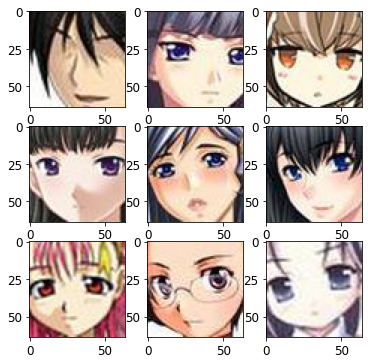

In [ ]:
# Plot some samples
fig, axs = plt.subplots(3, 3, figsize=(6,6))
axs = axs.flatten()

for i in range(9):
  ax = axs[i]
  ax.imshow( mpimg.imread(filenames[i]) )

plt.show()

In [ ]:
some_img = mpimg.imread(filenames[3]) # images with different sizes
print(f'Image shape: {some_img.shape}')
print(f'Number of samples: {len(filenames)}')

Image shape: (64, 64, 3)
Number of samples: 21941


In [ ]:
# Check the size of images
for i in range(2):
  some_img = Image.open(filenames[i])
    
  # summarize some details about the image
  print(some_img.format)
  print(some_img.size)
  print(some_img.mode)
  print()

JPEG
(64, 64)
RGB

JPEG
(64, 64)
RGB



<class 'numpy.ndarray'>
(64, 64, 3)

<class 'numpy.ndarray'>
(64, 64, 3)

<class 'numpy.ndarray'>
(64, 64, 3)



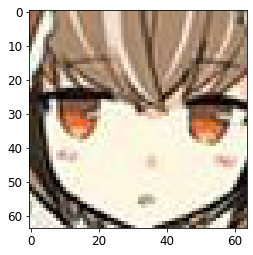

In [ ]:
for i in range(3):
  # load the image and convert into numpy array
  some_img = np.asarray( Image.open(filenames[i]) )
    
  # <class 'numpy.ndarray'>
  print(type(some_img))
    
  #  shape
  print(some_img.shape)

  print()

plt.figure()
plt.imshow(some_img)
plt.show()

# 2. Data preprocessing

In [ ]:
batch_size  = 32
noise_shape = 100
image_shape = (64, 64, 3)

dis_learning_rate = 0.0005
gen_learning_rate = 0.0005
dis_momentum = 0.9
gen_momentum = 0.9
dis_nesterov = True
gen_nesterov = True

In [ ]:
def norm_img(img):
  # image normalization to keep values between -1 and 1 for stability
  img = (img / 127.5) - 1
  return img


def denorm_img(img):
  # inverse operation of imahe normalization
  img = (img + 1) * 127.5
  return img.astype(np.uint8)


def sample_from_dataset(batch_size, image_shape, allfiles):
  # take a sample of batch_size random images from the dataset
  sample_dim = (batch_size,) + image_shape
  sample     = np.empty(sample_dim, dtype=np.float32)
  
  # get batch_size of images
  sample_imgs_paths = np.random.choice(allfiles, batch_size)

  for index, img_filename in enumerate(sample_imgs_paths):
    image = np.asarray( Image.open(filenames[index]) )
    image = norm_img(image)
    sample[index] = image
  return sample

Training dataset

In [ ]:
# Build X_train
n_samples = 20_000
X_train   = sample_from_dataset(n_samples, image_shape, filenames)
print(f'Sample shape: {X_train.shape}')

Sample shape: (20000, 64, 64, 3)


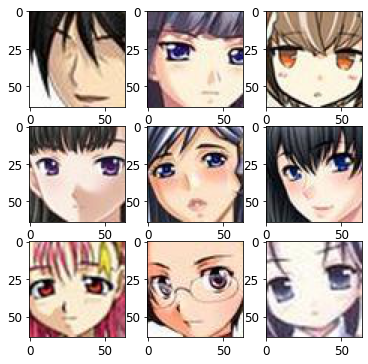

In [ ]:
# Plot some images of X_train
fig, axs = plt.subplots(3, 3, figsize=(6,6))
axs = axs.flatten()

for i in range(9):
  ax = axs[i]
  ax.imshow( denorm_img(X_train[i]) )

plt.show()

In [ ]:
# Directories to save results
img_save_dir   = 'results/'
save_model_dir = 'model/'

if not os.path.exists(img_save_dir):
  os.makedirs(img_save_dir)

if not os.path.exists(save_model_dir):
  os.makedirs(save_model_dir)

# 2. Build DCGAN

## 2.1 Generator

In [ ]:
def generator(noise_shape=100):

  gen_model = Sequential()

  gen_model.add(Input(shape=(noise_shape,)))
  gen_model.add(Dense(2048, input_dim=noise_shape))
  gen_model.add(LeakyReLU(alpha=0.2))
  gen_model.add(Dropout(0.2))

  gen_model.add(Dense(256 * 8 * 8))
  gen_model.add(BatchNormalization())
  gen_model.add(LeakyReLU(alpha=0.2))
  gen_model.add(Dropout(0.2))

  gen_model.add(Reshape((8, 8, 256), input_shape=(256 * 8 * 8,)))
  gen_model.add(UpSampling2D(size=(2, 2)))

  gen_model.add(Conv2D(128, kernel_size=5, padding='same'))
  gen_model.add(BatchNormalization(momentum=0.8))
  gen_model.add(LeakyReLU(alpha=0.2))

  gen_model.add(UpSampling2D(size=(2, 2)))

  gen_model.add(Conv2D(64, kernel_size=5, padding='same'))
  gen_model.add(BatchNormalization(momentum=0.8))
  gen_model.add(LeakyReLU(alpha=0.2))

  gen_model.add(UpSampling2D(size=(2, 2)))

  gen_model.add(Conv2D(3, kernel_size=5, padding='same'))
  gen_model.add(Activation('tanh'))

  # Define optimizers
  # gen_opt = SGD(lr=gen_learning_rate, momentum=gen_momentum, nesterov=gen_nesterov)
  gen_opt = Adam(lr=0.0002, beta_1=0.5)

  # Compile
  gen_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])

  return gen_model

In [ ]:
generator = generator(noise_shape)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16384)             0

## 2.2 Discriminator

In [ ]:
def discriminator(image_shape=(64, 64, 3)):

  dis_model = Sequential()
  dis_model.add(Input(shape=(image_shape)))

  dis_model.add( Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape) )
  dis_model.add(LeakyReLU(alpha=0.2))
  # dis_model.add(MaxPooling2D(pool_size=(2, 2)))

  dis_model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  dis_model.add(BatchNormalization())
  dis_model.add(LeakyReLU(alpha=0.2))

  dis_model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
  dis_model.add(BatchNormalization())
  dis_model.add(LeakyReLU(alpha=0.2))

  dis_model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
  dis_model.add(BatchNormalization())
  dis_model.add(LeakyReLU(alpha=0.2))

  dis_model.add(Flatten())
  dis_model.add(Dense(1024))
  dis_model.add(LeakyReLU(alpha=0.2))

  dis_model.add(Dense(1))
  dis_model.add(Activation('sigmoid'))

  # Define optimizers
  # dis_opt = SGD(lr=dis_learning_rate, momentum=dis_momentum, nesterov=dis_nesterov)
  dis_opt = Adam(lr=0.0002, beta_1=0.5)

  # Compile
  dis_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])

  return dis_model

In [ ]:
discriminator = discriminator(image_shape)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)        

Next, create an adversarial model. An adversarial contains both networks in a single model. The architecture of the adversarial model will be as follows:

*input -> generator -> discriminator -> output*

In [ ]:
# opt = SGD(lr=gen_learning_rate, momentum=gen_momentum, nesterov=gen_nesterov)
opt = Adam(lr=0.0002, beta_1=0.5)

gan = Sequential()
gan.add(generator)
discriminator.trainable = False
gan.add(discriminator)

gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         34872963  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 9945217   
Total params: 44,818,180
Trainable params: 34,839,811
Non-trainable params: 9,978,369
_________________________________________________________________


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(n_samples)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def gen_noise(batch_size, noise_shape):
  # input noise for the generator should follow a probability distribution, like in this case normal distribution
  return np.random.normal(0, 1, size=(batch_size, noise_shape)) # Mean = 0, std = 1

In [ ]:
def plot_multiple_images(images, epoch, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  
  plt.figure(figsize=(10, 6))
  
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow( denorm_img(image) )
    plt.axis('off')


  plt.tight_layout()
  plt.savefig(img_save_dir + 'epoch_' + str(epoch+1) + '_generated_images.png', bbox_inches='tight', pad_inches=0)

  plt.show()

In [ ]:
def train_gan(gan, dataset, batch_size, noise_shape, n_epochs=5):
  
  generator, discriminator = gan.layers

  disc_losses = []
  gan_losses  = []

  save_model_steps = 5
  
  for i in range(n_epochs):
    print(f'Epochs: {i+1}/{n_epochs}')
    
    for X_batch in dataset:
      # By default, Tensorflow uses float32. Need to convert data to tf.float32.
      X_batch = tf.cast(X_batch, tf.float32)

      # Phase 1 - Train the disciminator
      # generate a batch of fake images using the generator network:
      noise       = gen_noise(batch_size, noise_shape) # tf.random.normal(shape=[batch_size, codings_size], mean=0., stddev=1.)
      fake_images = generator.predict(noise)
      # fake_images = generator(noise)

      # Merge real and fake images
      X_real_and_fake = np.concatenate([X_batch, fake_images], axis=0)
      
      # add noise to the real label inputs (which will still be close to 1)
      real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2

      # add noise to the fake label inputs (which will still be close to 0)
      fake_data_Y = np.random.random_sample(batch_size) * 0.2

      # concatenate real and fake labels
      y_real_and_fake = np.concatenate((real_data_Y, fake_data_Y))

      # Train the discriminator
      generator.trainable     = False
      discriminator.trainable = True
      dis_loss = discriminator.train_on_batch(X_real_and_fake, y_real_and_fake)
      disc_losses.append(dis_loss[0])

      
      
      
      # Phase 2 - Train the generator
      noise = gen_noise(batch_size, noise_shape)
      y_generated = tf.constant([ [1] ] * batch_size)

      discriminator.trainable = False
      generator.trainable     = True

      g_loss = gan.train_on_batch(noise, y_generated)
      gan_losses.append(g_loss[0])
    # End - for: batch
  
    if (n_epochs == 1) or ( (i+1) % save_model_steps == 0):
      noise       = gen_noise(batch_size, noise_shape)
      fake_images = generator.predict(noise)

      plot_multiple_images(fake_images, i, n_cols=8)
    
    # save model
    if (save_model_steps is not None) and (((i+1) % save_model_steps) == 0):
      print('-----------------------------------------------------------------')
      print('Average Discriminator loss: %f' % (np.mean(disc_losses)))
      print('Average GAN loss: %f' % (np.mean(gan_losses)))
      print('-----------------------------------------------------------------')
      discriminator.trainable = True
      generator.trainable     = True
      generator.save(save_model_dir + 'epoch_' + str(i+1) + '_generator.hdf5')
      discriminator.save(save_model_dir + 'epoch_' + str(i+1) + '_discriminator.hdf5')
  # End - for: epochs
# End - def    

### 2.3 Train GAN with n_epochs = 1

Epochs: 1/1


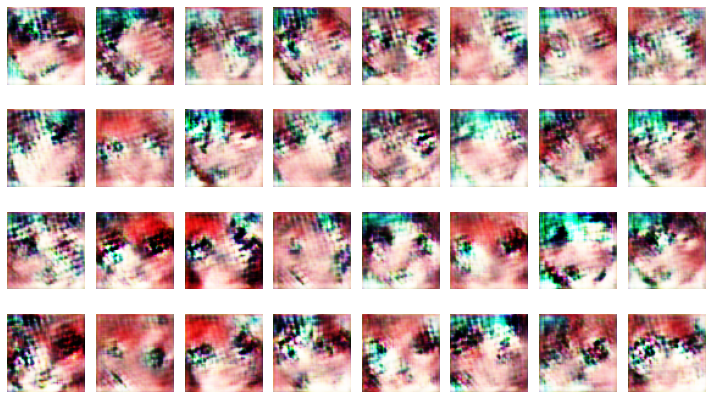

In [ ]:
# noise_shape = codings_size = shape of the central hidden layer
train_gan(gan, dataset, batch_size, noise_shape, n_epochs=1)

### 2.4 Train GAN with n_epochs = 10

Epochs: 1/10
Epochs: 2/10
Epochs: 3/10
Epochs: 4/10
Epochs: 5/10


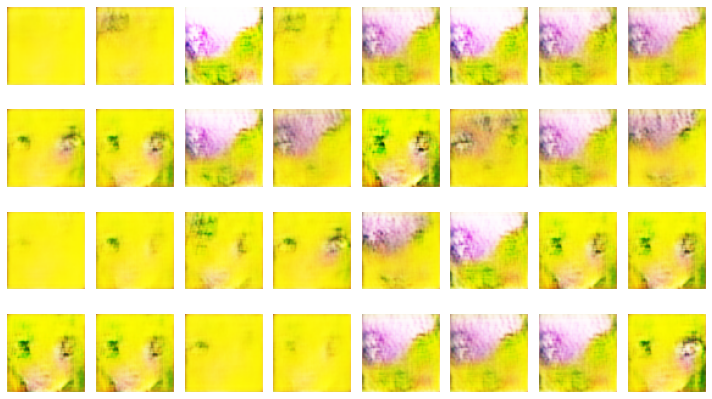

-----------------------------------------------------------------
Average Discriminator loss: 0.346865
Average GAN loss: 1.299885
-----------------------------------------------------------------
Epochs: 6/10
Epochs: 7/10
Epochs: 8/10
Epochs: 9/10
Epochs: 10/10


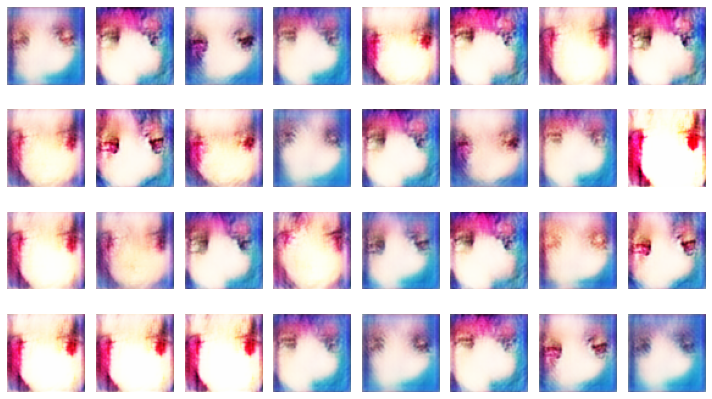

-----------------------------------------------------------------
Average Discriminator loss: 0.340091
Average GAN loss: 1.269554
-----------------------------------------------------------------


In [ ]:
# noise_shape = codings_size = shape of the central hidden layer
train_gan(gan, dataset, batch_size, noise_shape, n_epochs=10)